# Imports

In [46]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
import numpy as np
import math
import tensorflow as tf
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation
import h5py
from keras.optimizers import Adamax, Nadam
import sys
from writeNNet import saveNNet

from interval import interval, inf

from safe_train import propagate_interval, check_intervals, plot_policy, normalize_point, normalize_interval

import matplotlib.pyplot as plt

# Options

In [84]:
ver = 4  # Neural network version
hu = 45  # Number of hidden units in each hidden layer in network
saveEvery = 3  # Epoch frequency of saving
totalEpochs = 20  # Total number of training epochs
BATCH_SIZE = 2**8
EPOCH_TO_PROJECT = 5
trainingDataFiles = (
    "../TrainingData/VertCAS_TrainingData_v2_%02d.h5"  # File format for training data
)
nnetFiles = (
    "../networks/SafeVertCAS_pra%02d_v%d_45HU_%03d.nnet"  # File format for .nnet files
)
advisories = {
    "COC": 0,
    "DNC": 1,
    "DND": 2,
    "DES1500": 3,
    "CL1500": 4,
    "SDES1500": 5,
    "SCL1500": 6,
    "SDES2500": 7,
    "SCL2500": 8,
}
action_names = list([str(key) for key in advisories.keys()])
pra = 1

In [4]:
print("Loading Data for VertCAS, pra %02d, Network Version %d" % (pra, ver))
f = h5py.File(trainingDataFiles % pra, "r")
X_train = np.array(f["X"])
Q = np.array(f["y"])
means = np.array(f["means"])
ranges = np.array(f["ranges"])
min_inputs = np.array(f["min_inputs"])
max_inputs = np.array(f["max_inputs"])
print(f"min inputs: {min_inputs}")
print(f"max inputs: {max_inputs}")

N, numOut = Q.shape
print(f"Setting up model with {numOut} outputs and {N} training examples")
num_batches = N / BATCH_SIZE

# Asymmetric loss function
lossFactor = 40.0

# NOTE(nskh): from HorizontalCAS which was updated to use TF
def asymMSE(y_true, y_pred):
    d = y_true - y_pred
    maxes = tf.argmax(y_true, axis=1)
    maxes_onehot = tf.one_hot(maxes, numOut)
    others_onehot = maxes_onehot - 1
    d_opt = d * maxes_onehot
    d_sub = d * others_onehot
    a = lossFactor * (numOut - 1) * (tf.square(d_opt) + tf.abs(d_opt))
    b = tf.square(d_opt)
    c = lossFactor * (tf.square(d_sub) + tf.abs(d_sub))
    d = tf.square(d_sub)
    loss = tf.where(d_sub > 0, c, d) + tf.where(d_opt > 0, a, b)
    return tf.reduce_mean(loss)

Loading Data for VertCAS, pra 01, Network Version 4
min inputs: [-8000.  -100.  -100.     0.]
max inputs: [8000.  100.  100.   40.]
Setting up model with 9 outputs and 4053465 training examples


# Training: Standard

In [5]:
totalEpochs = 20
saveEvery = 1

Metal device set to: Apple M1 Pro


2023-07-12 08:50:46.433530: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-12 08:50:46.433641: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-07-12 08:50:46.645271: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-07-12 08:50:47.101087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15834/15834 [==============================] - 366s 23ms/step - loss: 0.1600 - accuracy: 0.9271
[interval([-50293.269056424215, 34674.39405893897]), interval([-61483.13519870827, 45269.39027954018]), interval([-49958.98184376453, 50629.11803827713]), interval([-57870.93048482473, 48995.425328134195]), interval([-56234.72201661974, 39075.80070733629]), interval([-47048.15080425722, 39255.36609948296]), interval([-54348.23616026087, 35506.85389862296]), interval([-48630.33664884354, 38830.02315037298]), interval([-42508.33744661245, 36730.10989264737])]
using normalized points
 62/203 [========>.....................] - ETA: 0s

2023-07-12 08:56:52.639887: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


203/203 [==============================] - 1s 2ms/step


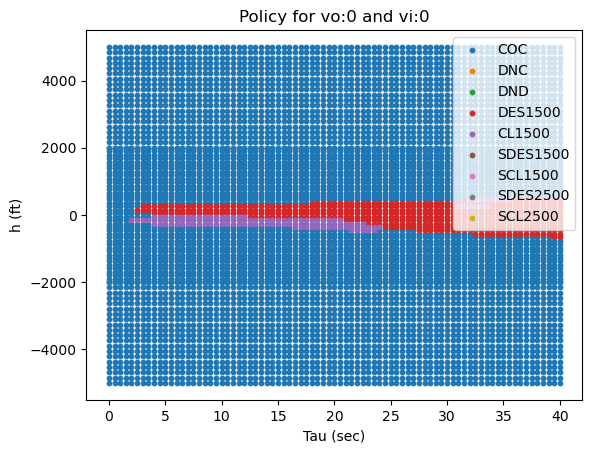

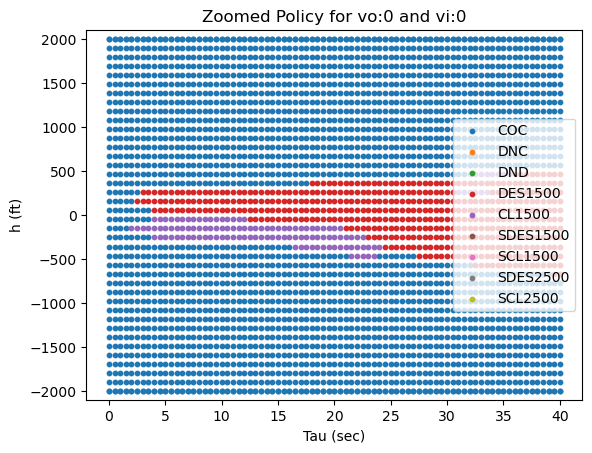

15834/15834 [==============================] - 376s 24ms/step - loss: 0.0463 - accuracy: 0.9569
[interval([-72605.68205872446, 49087.32219073952]), interval([-96807.64775057454, 69669.08434192583]), interval([-79045.68649925932, 80369.69918586103]), interval([-90694.56722552112, 74537.5559059149]), interval([-90412.62611150047, 55597.34611943614]), interval([-73354.26795999017, 64587.332117940365]), interval([-84945.22006571438, 54065.929705373994]), interval([-69814.70488978752, 55013.5400917905]), interval([-68318.99095623249, 54052.24177444871])]
using normalized points
203/203 [==============================] - 0s 2ms/step


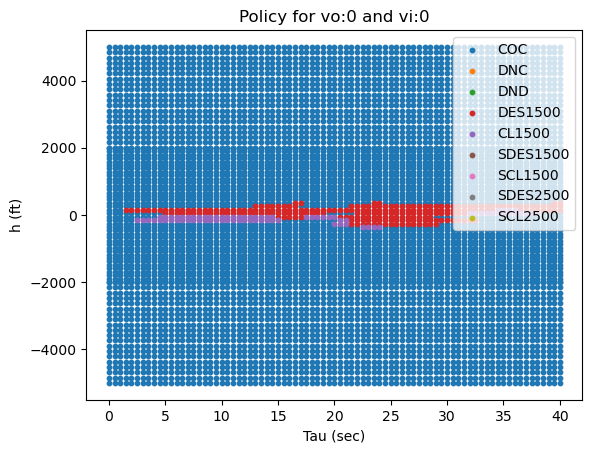

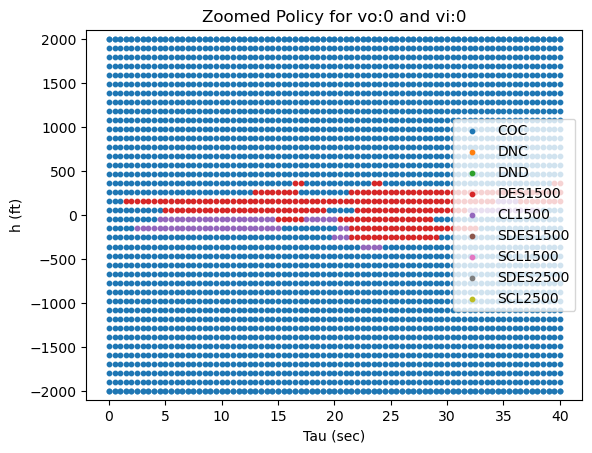

15834/15834 [==============================] - 383s 24ms/step - loss: 0.0338 - accuracy: 0.9618
[interval([-85612.83519808, 58369.46111541983]), interval([-120683.77950179428, 85179.85801024873]), interval([-98798.45996950463, 96481.82574744702]), interval([-114897.62756047038, 88448.65608893165]), interval([-116225.34330613745, 62155.85928561628]), interval([-90179.75195571626, 85787.08094522118]), interval([-110191.11011983025, 63907.841674840936]), interval([-82099.79607475869, 65835.04821982057]), interval([-86019.74490197595, 59180.87754452246])]
using normalized points
203/203 [==============================] - 1s 3ms/step


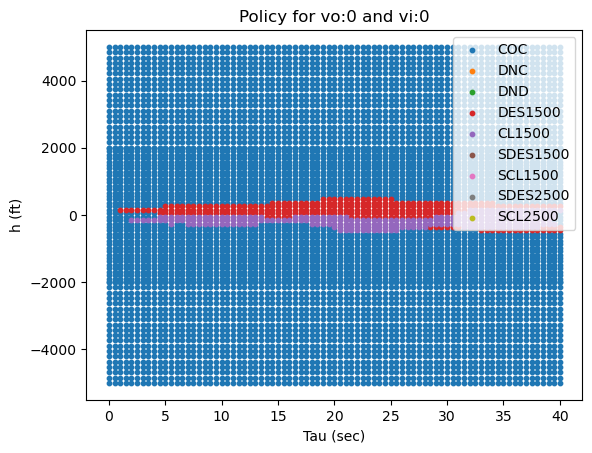

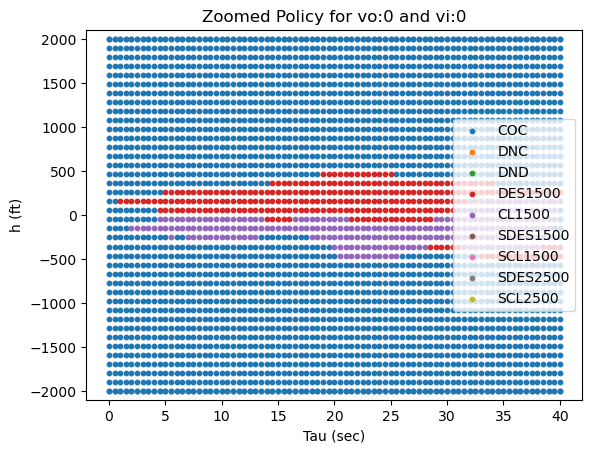

15834/15834 [==============================] - 357s 23ms/step - loss: 0.0272 - accuracy: 0.9650
[interval([-91693.7638281746, 61274.44594610666]), interval([-131536.52739174533, 91937.19791916147]), interval([-108293.79147512295, 98046.65675081851]), interval([-121985.57484037621, 94973.84492144948]), interval([-125784.7359134403, 67980.64017903656]), interval([-96981.94032186158, 98058.64539619387]), interval([-121386.66980653584, 66428.43487646291]), interval([-85487.725301565, 73609.93519078425]), interval([-91742.35406101574, 59751.03146436984])]
using normalized points
203/203 [==============================] - 1s 2ms/step


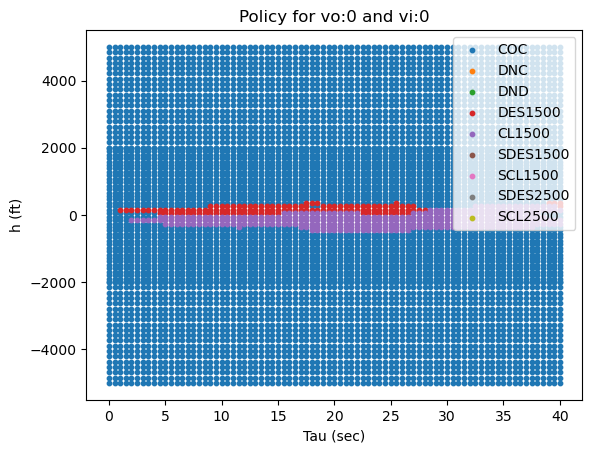

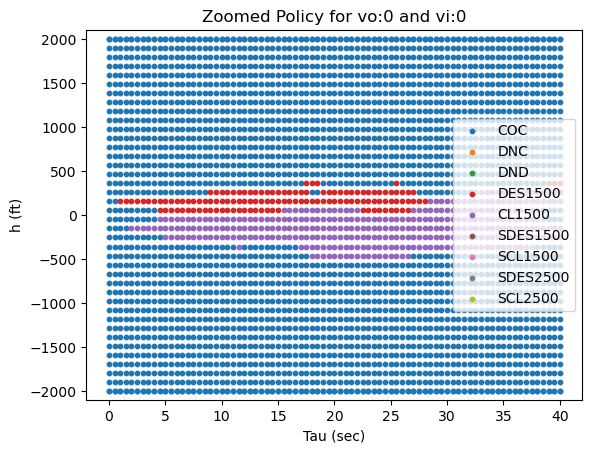

15834/15834 [==============================] - 364s 23ms/step - loss: 0.0224 - accuracy: 0.9675
[interval([-97754.69420721242, 62531.40230759414]), interval([-141560.4669599356, 99300.94199765791]), interval([-120749.8915879599, 101805.06874172961]), interval([-129483.99493901597, 102443.16528748495]), interval([-135103.12777558423, 73257.91561978945]), interval([-101305.54904329024, 104754.40052882896]), interval([-127927.36314319908, 69632.19508594014]), interval([-88139.75288867932, 81223.41688840519]), interval([-96500.79781434941, 64539.67929564786])]
using normalized points
203/203 [==============================] - 1s 2ms/step


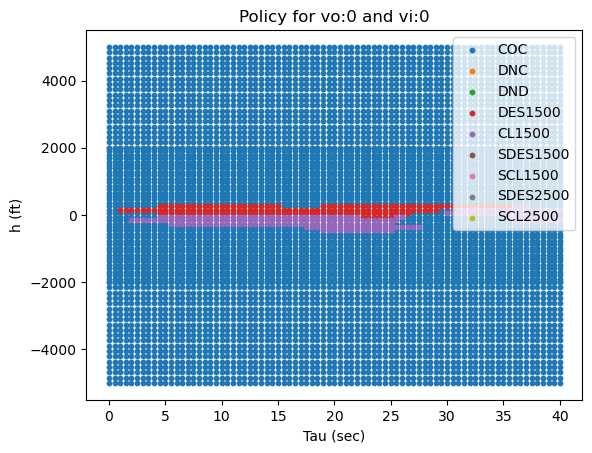

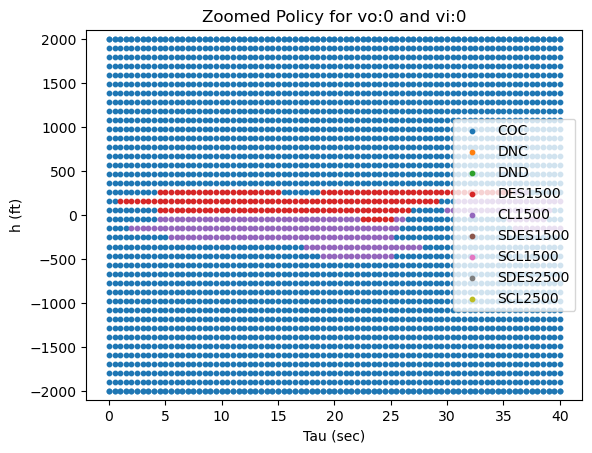

15834/15834 [==============================] - 382s 24ms/step - loss: 0.0196 - accuracy: 0.9694
[interval([-100941.85827925881, 62906.3583168654]), interval([-152887.51916882707, 109619.2132542498]), interval([-131007.8122883607, 106913.45096580003]), interval([-137000.99668788695, 111135.35719822696]), interval([-139689.11740147052, 75447.08418678604]), interval([-107170.244868321, 113104.2629835367]), interval([-132155.65416816663, 75036.10265312332]), interval([-91254.6089957763, 89136.39949421267]), interval([-101280.83451958655, 69218.94706005472])]
using normalized points
203/203 [==============================] - 0s 2ms/step


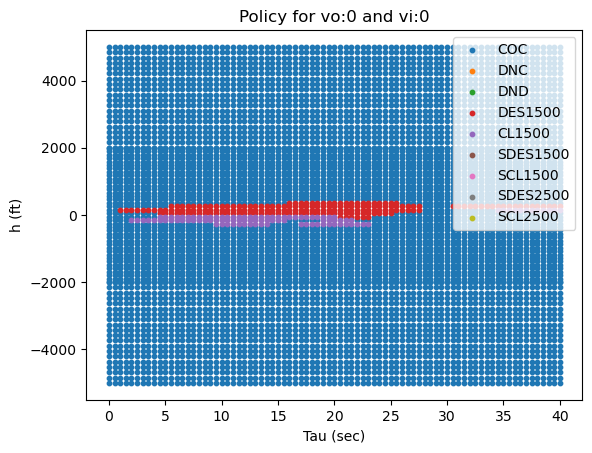

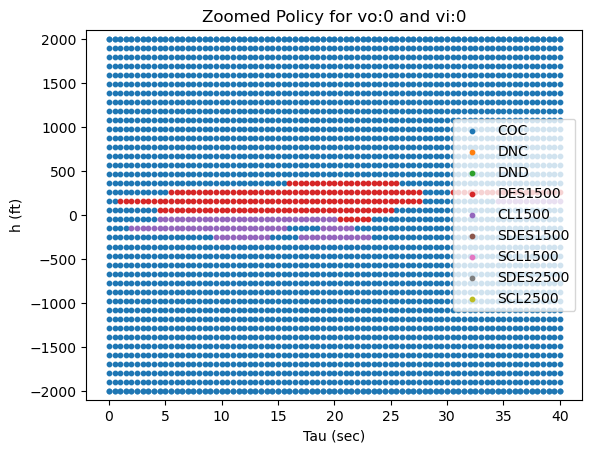

15834/15834 [==============================] - 363s 23ms/step - loss: 0.0179 - accuracy: 0.9705
[interval([-101575.6742025381, 61195.39140228288]), interval([-158678.36402257052, 115208.67190652978]), interval([-139152.9724913816, 110010.46166017269]), interval([-140401.30245015866, 121457.97270860008]), interval([-142561.13191535423, 76646.2985728877]), interval([-106355.46967440259, 117726.3850027772]), interval([-132297.59278342602, 79406.22730947731]), interval([-93346.28357873982, 96706.79537273553]), interval([-101468.62456740568, 74417.23915047356])]
using normalized points
203/203 [==============================] - 0s 2ms/step


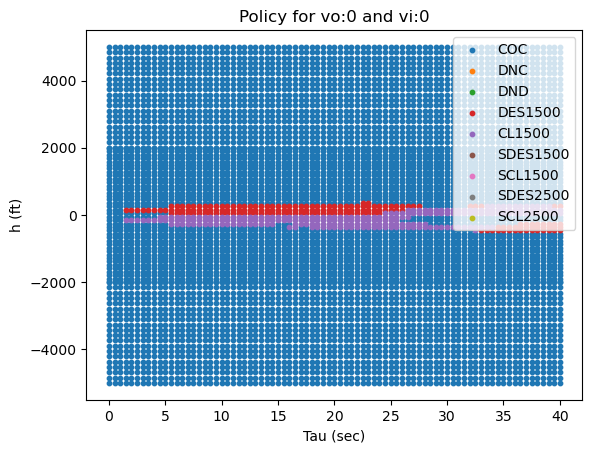

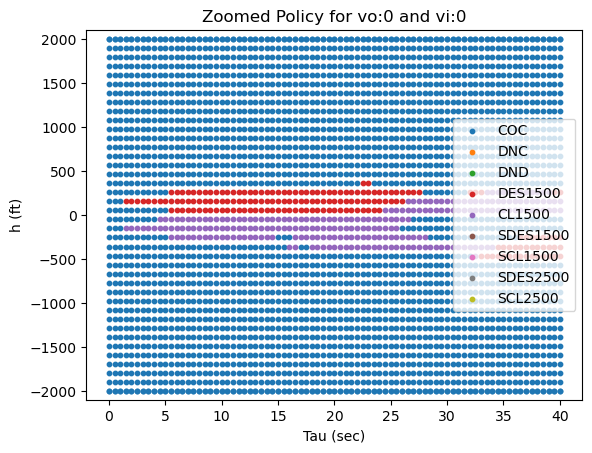

15834/15834 [==============================] - 379s 24ms/step - loss: 0.0163 - accuracy: 0.9715
[interval([-98007.62341125788, 55909.41299887904]), interval([-157499.2723998228, 119394.3173406544]), interval([-139636.10326213096, 106642.66672064344]), interval([-138865.13263976882, 126296.20160179677]), interval([-134943.15987875665, 73012.75398568071]), interval([-106484.47772817535, 119685.19646360441]), interval([-122971.85060670704, 75339.59573707644]), interval([-96103.40707402656, 102353.17523806979]), interval([-98607.14357528817, 75217.45710989795])]
using normalized points
203/203 [==============================] - 0s 2ms/step


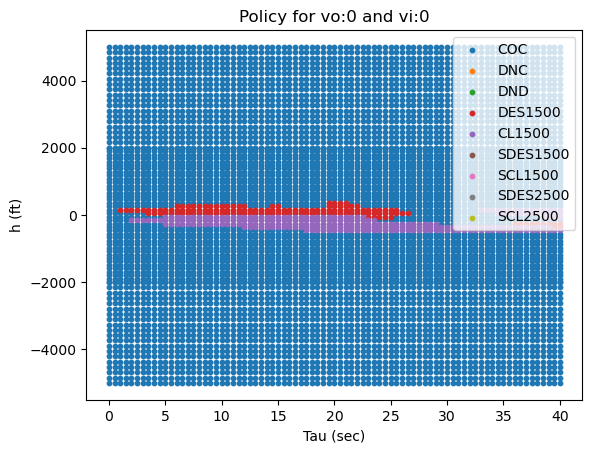

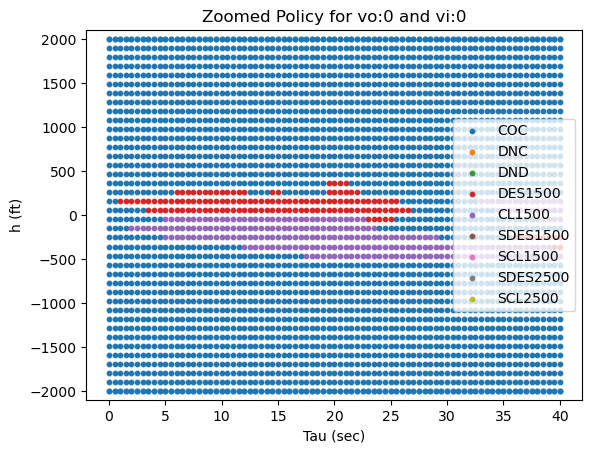

15834/15834 [==============================] - 365s 23ms/step - loss: 0.0151 - accuracy: 0.9723
[interval([-94120.47057271392, 50039.03801179993]), interval([-153640.8879847695, 122781.83607520138]), interval([-139569.49771335575, 104295.70744201167]), interval([-139115.49522083398, 133879.84517516475]), interval([-128864.1480208459, 73729.48313839435]), interval([-107333.30007908426, 128390.61046797878]), interval([-117201.4407813497, 72346.89477669177]), interval([-95879.30681018048, 107418.79825594877]), interval([-96548.38530451368, 74823.47941072787])]
using normalized points
203/203 [==============================] - 0s 2ms/step


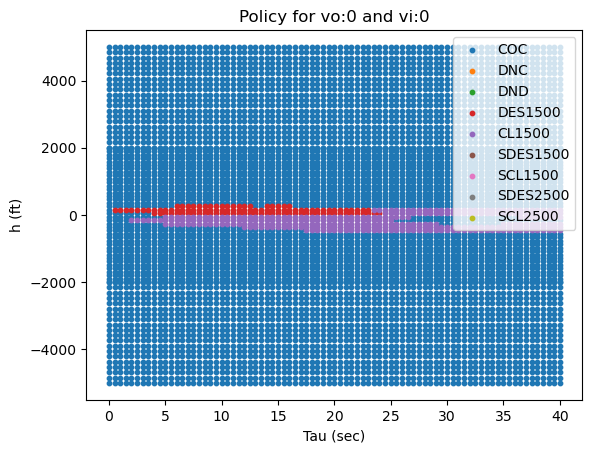

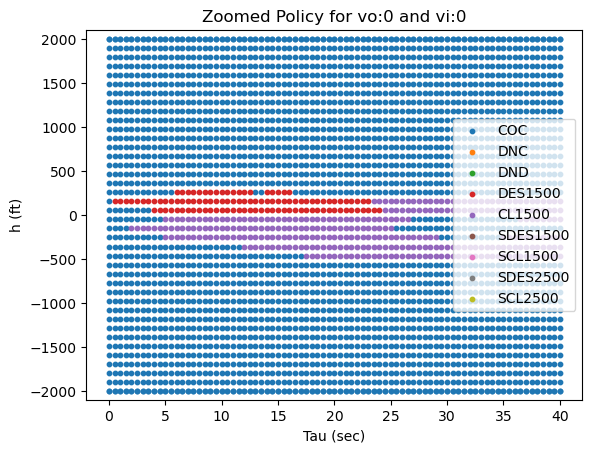

15834/15834 [==============================] - 359s 23ms/step - loss: 0.0143 - accuracy: 0.9726
[interval([-94449.74466446658, 48048.4553199886]), interval([-155014.11863931257, 127302.91618291696]), interval([-139834.4370396035, 105385.44798364596]), interval([-142281.50310063193, 145023.05117377883]), interval([-127377.5701798462, 74294.25282693027]), interval([-107746.47190807821, 131818.05817155106]), interval([-113161.77266881475, 71506.68192437133]), interval([-95564.53203829884, 111205.91663099646]), interval([-96818.84472179262, 75096.09939149875])]
using normalized points
203/203 [==============================] - 0s 2ms/step


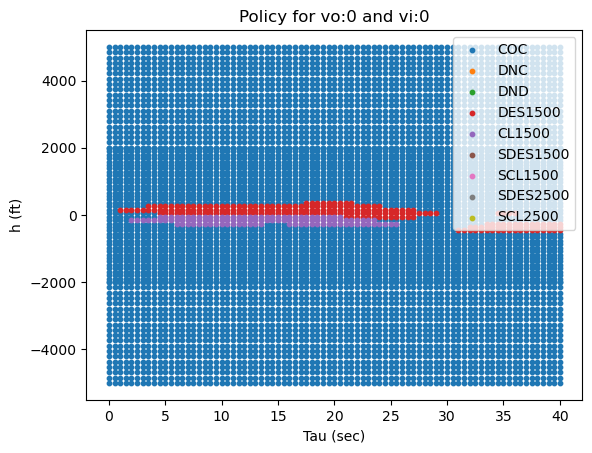

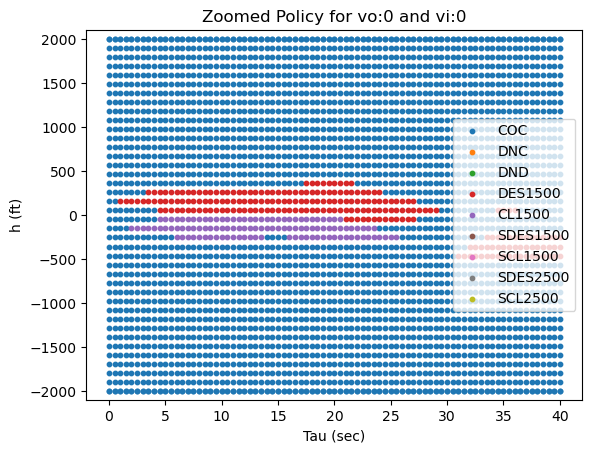

15834/15834 [==============================] - 506s 32ms/step - loss: 0.0135 - accuracy: 0.9734
[interval([-90016.29217505456, 42931.36594386342]), interval([-149264.78376075797, 125671.3200925314]), interval([-134939.3421848858, 102542.85910495874]), interval([-139221.71777661607, 144922.2324539195]), interval([-120651.3539543878, 77346.54714895414]), interval([-104182.62567680163, 128727.72884451674]), interval([-101791.02266061731, 68111.90076526869]), interval([-95044.6481209372, 110252.90543578903]), interval([-94223.78486490226, 75742.24588722253])]
using normalized points
203/203 [==============================] - 0s 2ms/step


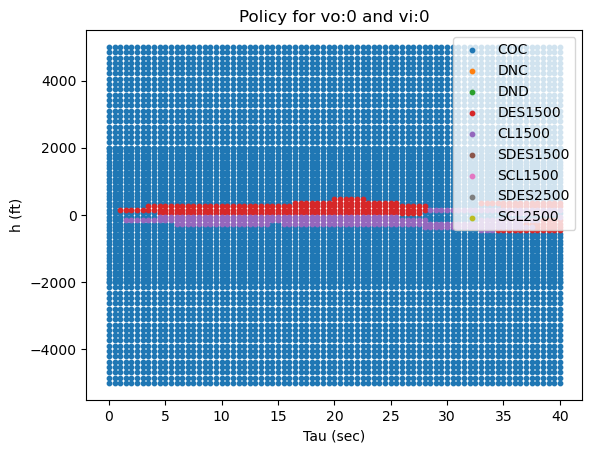

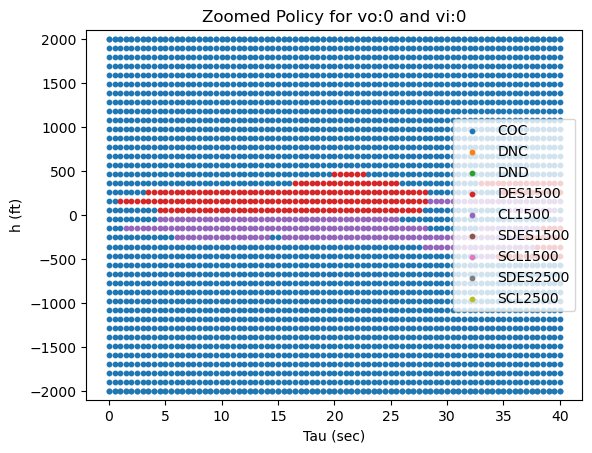

15834/15834 [==============================] - 395s 25ms/step - loss: 0.0129 - accuracy: 0.9739
[interval([-91273.7528718775, 40806.63007914052]), interval([-155606.94694101877, 133865.27256339125]), interval([-143476.49270028702, 109974.63008759623]), interval([-147112.48022646873, 152484.35031718994]), interval([-121134.89466528615, 82107.38372829706]), interval([-110271.71523164459, 137010.72920853487]), interval([-102298.92368381956, 76342.93557656623]), interval([-99911.13046086612, 117215.82387112243]), interval([-96967.98226016958, 85735.25794222202])]
using normalized points
203/203 [==============================] - 1s 3ms/step


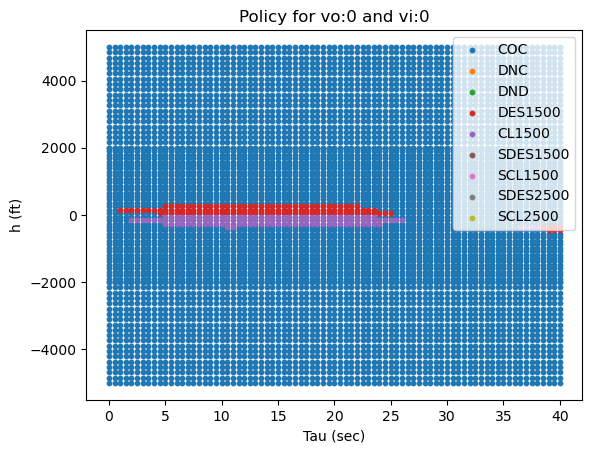

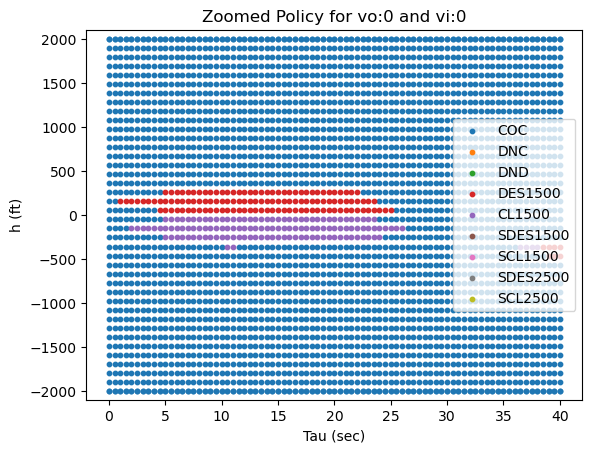

15834/15834 [==============================] - 380s 24ms/step - loss: 0.0120 - accuracy: 0.9747
[interval([-92148.43811933255, 37522.342235408454]), interval([-153230.5284442916, 136027.30605412662]), interval([-149455.78381106575, 109604.16149032855]), interval([-145618.52789115827, 155549.6309444546]), interval([-116801.72029501028, 84366.54086995119]), interval([-109566.78057543469, 140950.18483721148]), interval([-95984.26773728443, 75865.04684579003]), interval([-100387.36284146164, 119895.98507710599]), interval([-93974.979492133, 88689.99505962046])]
using normalized points
203/203 [==============================] - 0s 2ms/step


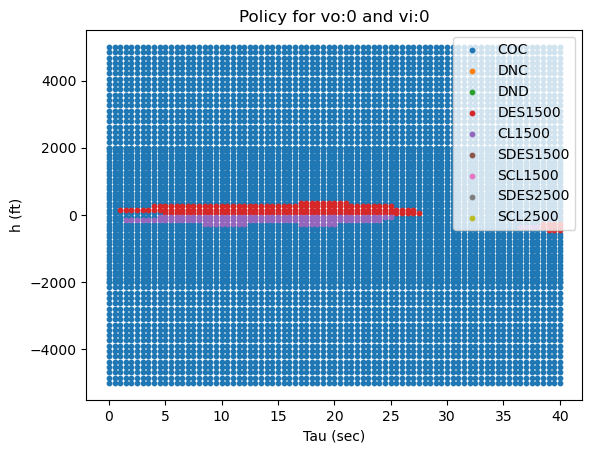

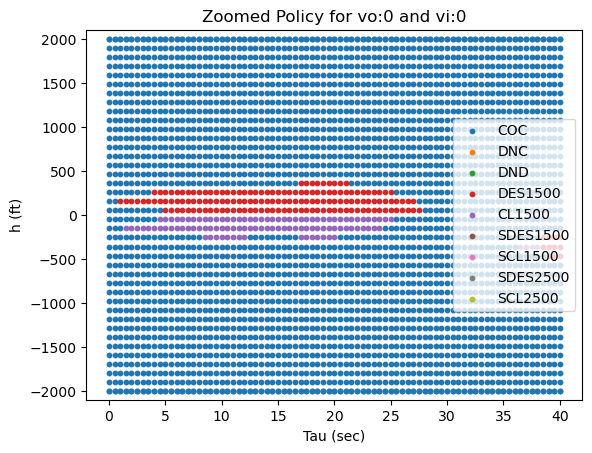

15834/15834 [==============================] - 379s 24ms/step - loss: 0.0116 - accuracy: 0.9750
[interval([-93780.34244625858, 34317.774980266324]), interval([-152253.31375747157, 140886.59413247832]), interval([-153783.24925003314, 112912.169230693]), interval([-145709.58120908463, 160415.01148679366]), interval([-111842.80113297803, 88871.20792418199]), interval([-108835.47821710554, 142508.5289636188]), interval([-90031.79760303182, 82663.32701933842]), interval([-98191.43443952789, 128389.51281366321]), interval([-90498.81434118275, 91542.4299508403])]
using normalized points
203/203 [==============================] - 0s 2ms/step


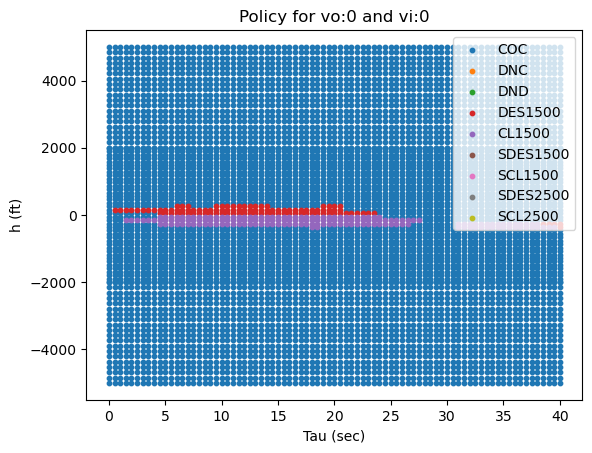

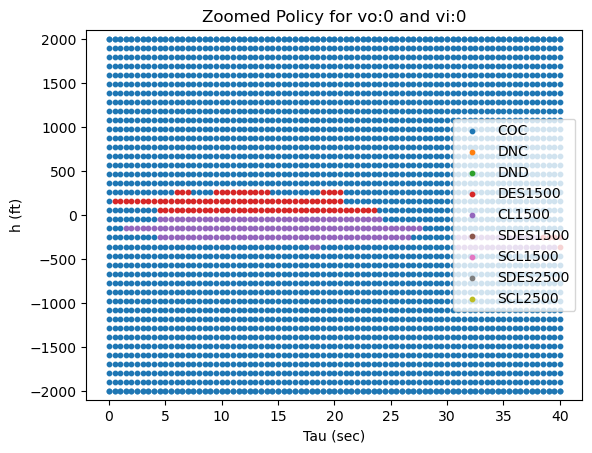

15834/15834 [==============================] - 367s 23ms/step - loss: 0.0112 - accuracy: 0.9752
[interval([-97446.6720217912, 34260.55017637189]), interval([-160952.31978400738, 153634.41370811226]), interval([-163384.56227348867, 119791.45675672092]), interval([-155033.86898235334, 172598.86497776187]), interval([-115994.93251406743, 91871.24304739124]), interval([-116060.78430439119, 151613.6650087501]), interval([-94131.07362357176, 88800.564490079]), interval([-105439.56921603407, 139234.618632069]), interval([-92776.36436327362, 96595.98954771084])]
using normalized points
203/203 [==============================] - 1s 2ms/step


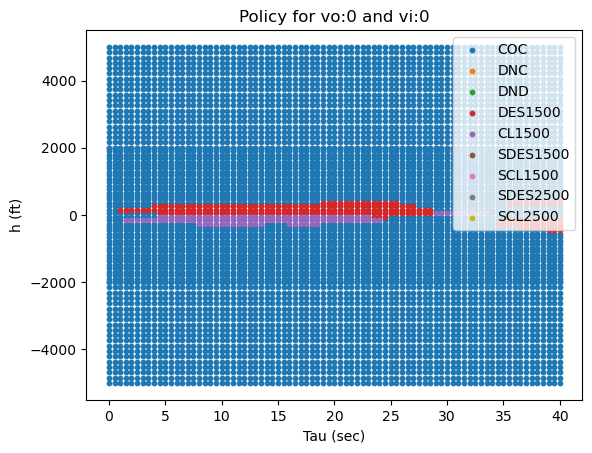

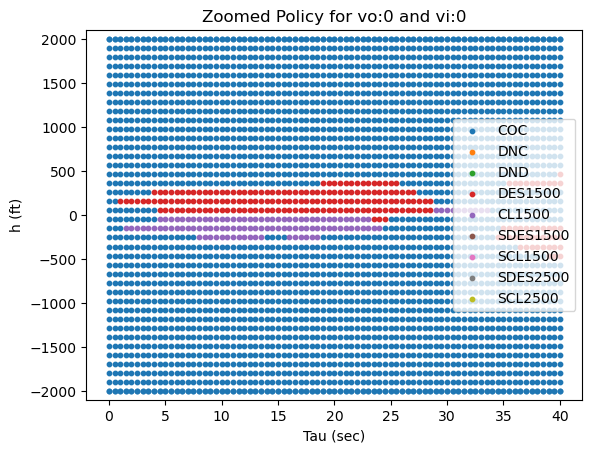

15834/15834 [==============================] - 367s 23ms/step - loss: 0.0106 - accuracy: 0.9757
[interval([-97664.0139167099, 31218.394888150382]), interval([-160641.8951761681, 157580.82126983828]), interval([-165652.0164072172, 121135.78105307429]), interval([-154774.77947961903, 175555.41780836563]), interval([-113840.50174144804, 94829.55878545281]), interval([-117751.73834690661, 149606.07118176084]), interval([-93672.47338819763, 89000.72652089121]), interval([-107312.57444298103, 140987.63994758128]), interval([-91102.14806015, 97457.22198519997])]
using normalized points
203/203 [==============================] - 0s 2ms/step


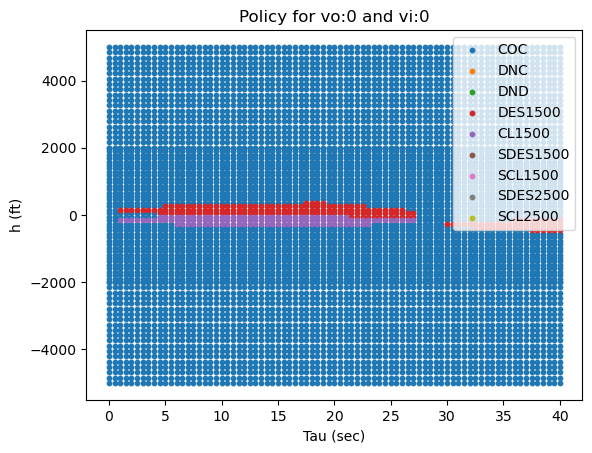

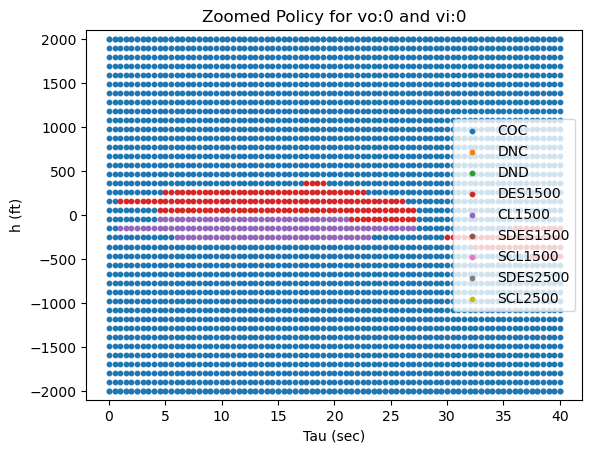

15834/15834 [==============================] - 386s 24ms/step - loss: 0.0105 - accuracy: 0.9760
[interval([-105726.38110851639, 31350.288529923127]), interval([-167226.13103210542, 171910.38842753175]), interval([-171944.6122836262, 130685.14666394616]), interval([-162016.38347337412, 191118.19854925183]), interval([-115414.27702684954, 99556.40613832868]), interval([-123276.38749877506, 158910.6030032838]), interval([-96669.83338437851, 95376.47628401784]), interval([-112758.30585168213, 153264.8710861843]), interval([-92392.51529348921, 108162.70189909734])]
using normalized points
203/203 [==============================] - 1s 3ms/step


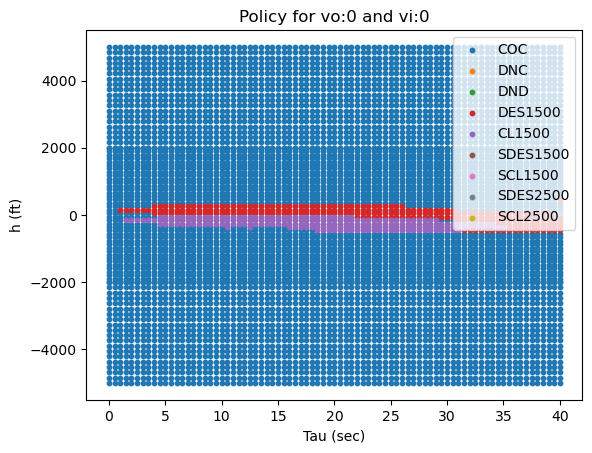

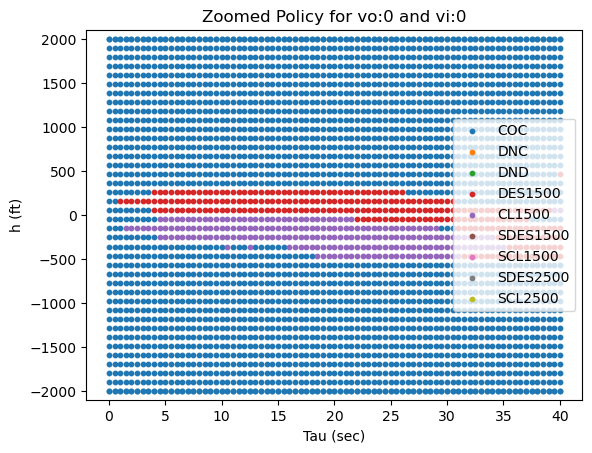

15834/15834 [==============================] - 374s 24ms/step - loss: 0.0101 - accuracy: 0.9762
[interval([-104669.99675208934, 29598.044634119105]), interval([-163931.6982190023, 168293.23005043648]), interval([-166073.5346108892, 123284.55869377952]), interval([-158605.12015049407, 185880.4460930343]), interval([-112142.38717346931, 96402.03577338197]), interval([-123669.67539577444, 157638.81490840344]), interval([-95862.44088447567, 94259.03435827982]), interval([-112838.61562819144, 152040.2825146347]), interval([-89446.2777434953, 108123.33809944717])]
using normalized points
203/203 [==============================] - 0s 2ms/step


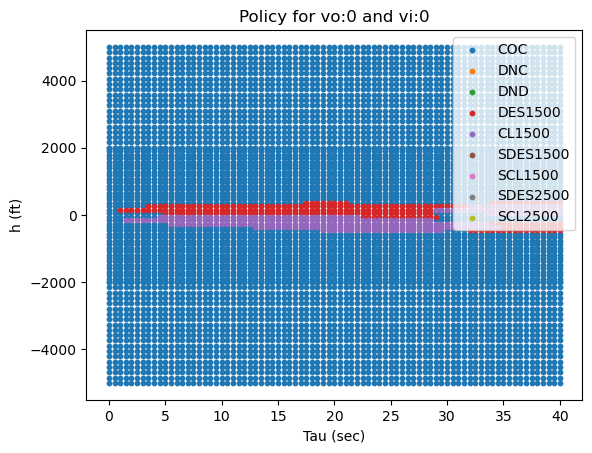

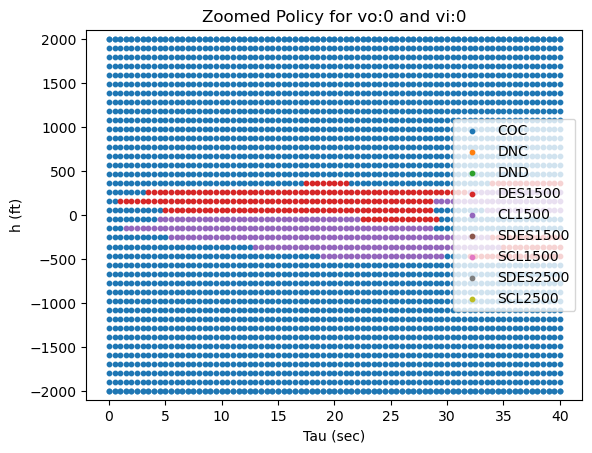

15834/15834 [==============================] - 382s 24ms/step - loss: 0.0095 - accuracy: 0.9766
[interval([-109789.13114154765, 30730.312001128812]), interval([-169136.95530240817, 178117.73875660318]), interval([-166685.84586572705, 123362.56923092656]), interval([-163674.8930742231, 193969.61837329628]), interval([-112989.83380126559, 100182.6305380185]), interval([-129100.16948552453, 163881.95004321844]), interval([-97734.6179528233, 96849.08971844282]), interval([-116984.61267105446, 154547.88816650686]), interval([-92588.1189574905, 115533.43751201336])]
using normalized points
203/203 [==============================] - 0s 2ms/step


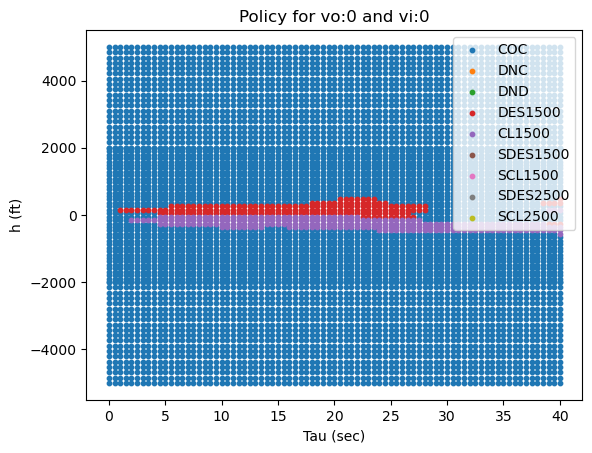

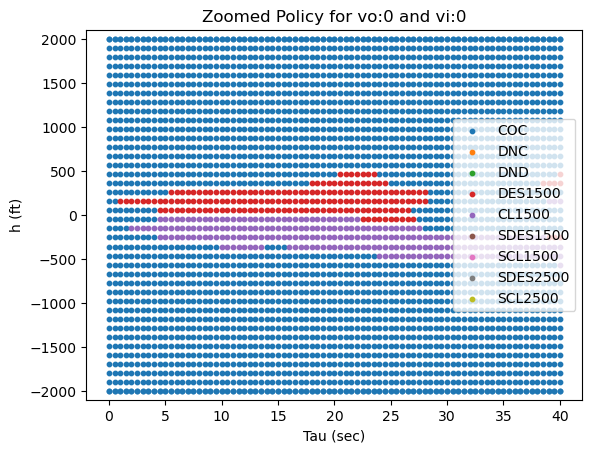

15834/15834 [==============================] - 376s 24ms/step - loss: 0.0094 - accuracy: 0.9770
[interval([-111209.30864987867, 29976.291706212105]), interval([-175910.44032382264, 189513.01711564633]), interval([-162320.55571209674, 128422.80657481185]), interval([-167803.07973720547, 203355.66473231188]), interval([-111685.8602199711, 103111.63446064164]), interval([-138442.73192985708, 170520.85572499826]), interval([-94742.42110794899, 99921.8587519926]), interval([-122966.47936881435, 161670.73015905445]), interval([-92101.17285227521, 119652.54945771574])]
using normalized points
203/203 [==============================] - 0s 2ms/step


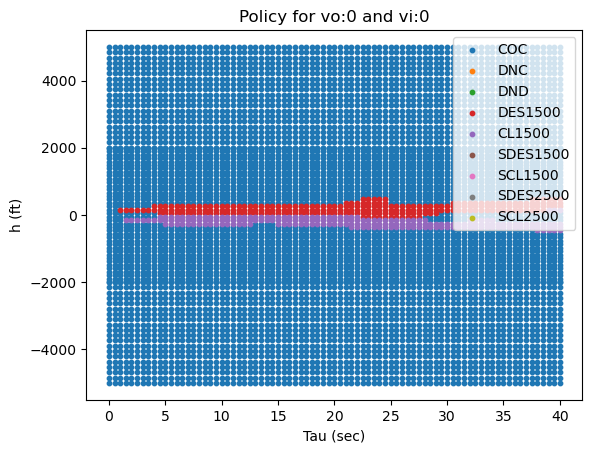

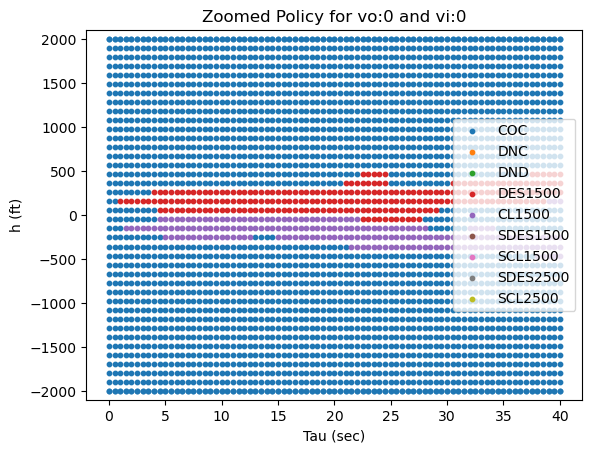

In [6]:
# # Define model architecture
# model = Sequential()
# # model.add(Dense(hu, init='uniform', activation='relu', input_dim=4))
# # model.add(Dense(hu, init='uniform', activation='relu'))
# # model.add(Dense(hu, init='uniform', activation='relu'))
# # model.add(Dense(hu, init='uniform', activation='relu'))
# # model.add(Dense(hu, init='uniform', activation='relu'))
# # model.add(Dense(hu, init='uniform', activation='relu'))
# model.add(Dense(hu, activation="relu", input_dim=4))
# model.add(Dense(hu, activation="relu"))
# model.add(Dense(hu, activation="relu"))
# model.add(Dense(hu, activation="relu"))
# model.add(Dense(hu, activation="relu"))
# model.add(Dense(hu, activation="relu"))

# # model.add(Dense(numOut, init="uniform"))
# model.add(Dense(numOut))
# opt = Nadam(learning_rate=0.0003)
# model.compile(loss=asymMSE, optimizer=opt, metrics=["accuracy"])

# # # Train and write nnet files
# epoch = saveEvery
# while epoch <= totalEpochs:
#     model.fit(X_train, Q, epochs=saveEvery, batch_size=2**8, shuffle=True)
#     saveFile = nnetFiles % (pra, ver, epoch)
#     saveNNet(model, saveFile, means, ranges, min_inputs, max_inputs)
#     epoch += saveEvery
#     output_interval, penultimate_interval = propagate_interval(
#         [
#             interval[400, 500],
#             interval[50, 51],
#             interval[-51, -50],
#             interval[20, 21],
#         ],
#         model,
#         graph=False,
#     )
#     print(output_interval)
#     plot_policy(model, f"images/standard_vcas_policy_viz_vo50_vi-50_epoch{epoch}.pdf", zoom=True)

In [7]:
model.save("models/july12-standard-acas-20epochs")

INFO:tensorflow:Assets written to: models/july12-standard-acas-20epochs/assets


## Normalized Interval Analysis

In [8]:
cocinterval = [
    interval[400, 500],
    interval[50, 51],
    interval[-51, -50],
    interval[20, 21],
]

In [10]:
cocinterval

[interval([400.0, 500.0]),
 interval([50.0, 51.0]),
 interval([-51.0, -50.0]),
 interval([20.0, 21.0])]

using normalized points
203/203 [==============================] - 0s 2ms/step


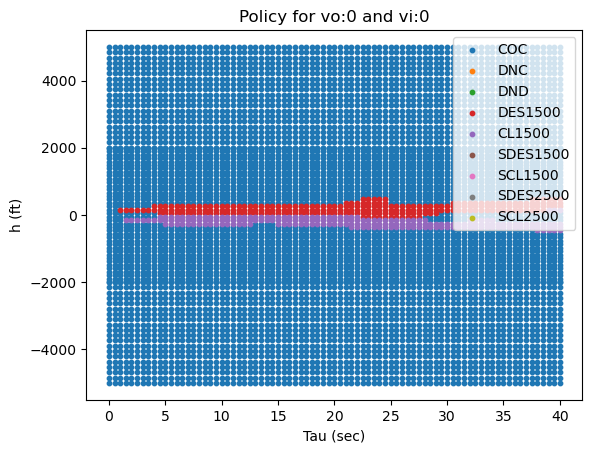

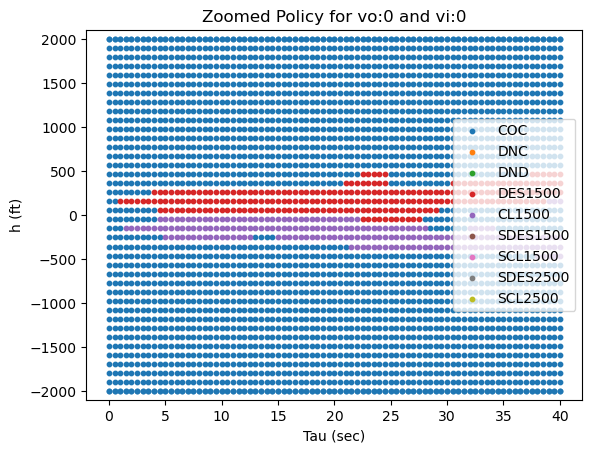

In [24]:
plot_policy(model, f"images/standard_vcas_policy_viz_vo50_vi-50_epoch{epoch}.pdf", zoom=True)

In [13]:
norm_coc_interval = normalize_interval(cocinterval)
norm_coc_interval

[interval([0.025, 0.03125]),
 interval([0.25, 0.255]),
 interval([-0.255, -0.25]),
 interval([0.0, 0.025])]

In [16]:
output_interval, _ = propagate_interval(
        norm_coc_interval,
        model,
        graph=False,
    )
output_interval

[interval([-7.3531164322530715, 2.29725660218155]),
 interval([-12.396850955939739, 12.847539863777145]),
 interval([-11.649842875891467, 8.894975169798768]),
 interval([-11.76344280443033, 14.004742623079586]),
 interval([-8.108866287402956, 7.029449395180842]),
 interval([-10.036483737828055, 11.355621123357226]),
 interval([-7.244979768054754, 6.568443080234955]),
 interval([-8.924607936269176, 10.729884022544415]),
 interval([-7.041225413151666, 7.940262917462579])]

In [20]:
coc_point = np.array([[450, 50, -50, 20]])
y_pred = model.predict(normalize_point(coc_point))
y_pred

1/1 [==============================] - 0s 11ms/step


array([[ 0.14844796,  0.09689691, -0.21305254,  0.10832778, -0.21157673,
        -0.19992809, -0.53504366, -0.20521548, -0.51728743]],
      dtype=float32)

In [23]:
list(advisories.keys())[np.argmax(y_pred)]

'COC'

In [38]:
des_interval = [
    interval[100, 110],
    interval[0, 0.5],
    interval[0, 0.5],
    interval[20, 21]
]
output_interval, _ = propagate_interval(
    normalize_interval(des_interval),
    model
)
output_interval

[interval([-6.230902078042526, 1.8854520704766622]),
 interval([-10.387188857200448, 11.001923230933386]),
 interval([-9.814140508690539, 7.4279651751179125]),
 interval([-9.572613252486349, 11.368333221407537]),
 interval([-6.623563034875351, 5.931287787982548]),
 interval([-8.264350087165779, 9.075911323215749]),
 interval([-6.044248780001703, 5.4194106424490425]),
 interval([-7.356067835827801, 8.932028386384586]),
 interval([-5.866602224929723, 6.66093723995122])]

In [88]:
des_point = np.array([[100, 0, 0, 20]])
y_pred = model.predict(normalize_point(des_point))
print(y_pred)

1/1 [==============================] - 0s 16ms/step
[[ 0.11075691 -0.07173046 -0.26435402  0.13520066  0.10144678 -0.2241059
  -0.23546076 -0.22331922 -0.22403666]]


In [89]:
des_point = np.array([[110, 0.5, 0.5, 21]])
y_pred = model.predict(normalize_point(des_point))
print(y_pred)

1/1 [==============================] - 0s 11ms/step
[[ 0.11156188 -0.06196393 -0.27556762  0.1342926   0.10110674 -0.22359648
  -0.23287316 -0.22311988 -0.2224029 ]]


In [90]:
des_point = np.array([[110, 0, 0, 21]])
y_pred = model.predict(normalize_point(des_point))
print(y_pred)

1/1 [==============================] - 0s 12ms/step
[[ 0.11176199 -0.06325972 -0.26040828  0.1333798   0.10234901 -0.22256835
  -0.2325584  -0.22204253 -0.2216597 ]]


In [1]:
des_point = np.array([[110, -0.5, -0.5, 21]])
y_pred = model.predict(normalize_point(des_point))
print(y_pred)

NameError: name 'np' is not defined

In [86]:
action_names

['COC',
 'DNC',
 'DND',
 'DES1500',
 'CL1500',
 'SDES1500',
 'SCL1500',
 'SDES2500',
 'SCL2500']

## Plotting input intervals

304/304 [==============================] - 1s 2ms/step


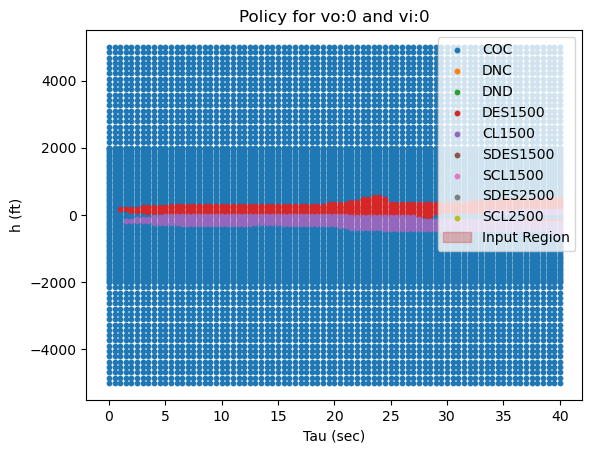

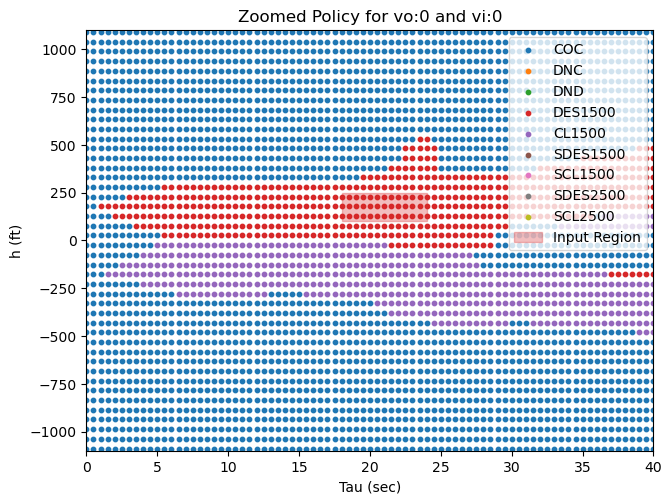

In [79]:
des_interval = [
    interval[100, 250],
    interval[0, 0.1],
    interval[0, 0.1],
    interval[18, 24]
]
plot_policy(model, savefig=False, zoom=True, intervals=des_interval, intervalcolor="C3")

In [68]:
des_point = np.array([[100, 0, 0, 20]])
y_pred = model.predict(normalize_point(des_point))
print(y_pred)

1/1 [==============================] - 0s 12ms/step
[[ 0.11075691 -0.07173046 -0.26435402  0.13520066  0.10144678 -0.2241059
  -0.23546076 -0.22331922 -0.22403666]]


In [29]:
list(advisories.keys())[np.argmax(y_pred)]

'DES1500'

In [34]:
tf.nn.softmax(y_pred).numpy()

array([[0.13531496, 0.11274377, 0.0929902 , 0.13866332, 0.13406101,
        0.09680922, 0.09571617, 0.09688541, 0.09681592]], dtype=float32)

In [33]:
list(advisories.keys())[np.argmax(tf.nn.softmax(y_pred).numpy())]

'DES1500'

In [93]:
model.save('model-for-steven.keras')

## Retraining with new $v_o, v_i$

In [107]:
vo = 0
vi = 0

In [109]:
hu

45

2023-07-07 12:03:01.395710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15834/15834 [==============================] - 397s 25ms/step - loss: 0.1527 - accuracy: 0.9258
[interval([-34670.45884438339, 39707.995223846156]), interval([-66921.03100768849, 47521.804260915735]), interval([-65734.31277004155, 57581.81829324191]), interval([-64650.38283097892, 40740.96546677708]), interval([-74136.72867611113, 42860.134208366035]), interval([-57489.47703322734, 43939.386224360154]), interval([-57070.51064055664, 35444.69073933754]), interval([-48056.19801438621, 35092.70144191657]), interval([-50891.68935078238, 41794.7345662634])]
 40/203 [====>.........................] - ETA: 0s

2023-07-07 12:09:38.322453: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


203/203 [==============================] - 1s 3ms/step


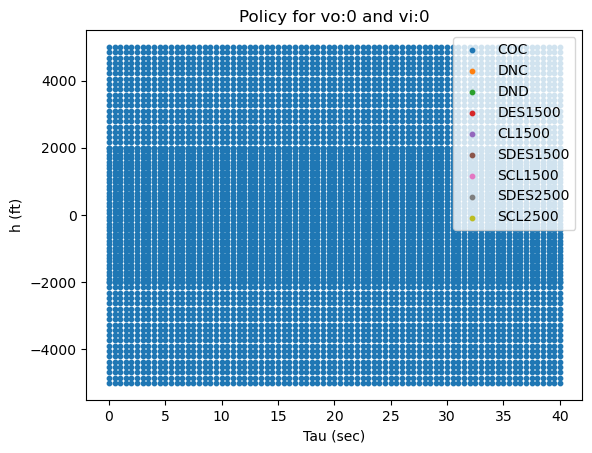

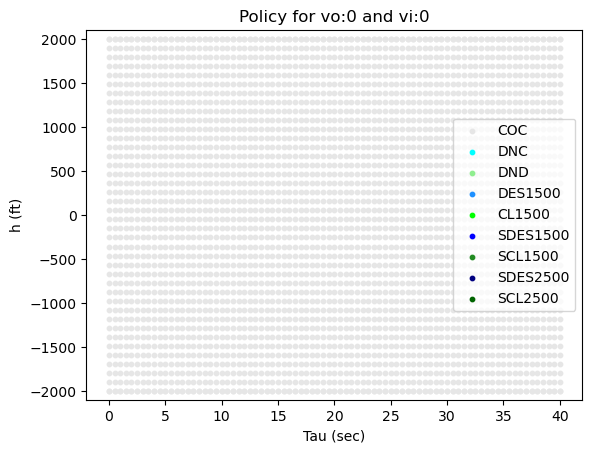

15834/15834 [==============================] - 407s 26ms/step - loss: 0.0477 - accuracy: 0.9570
[interval([-51138.26486444937, 57561.10893173179]), interval([-95056.76454337989, 60140.223680226576]), interval([-97982.31213481128, 77964.90093030018]), interval([-99445.00419813274, 61058.929800085956]), interval([-107560.71191682934, 50512.50421746389]), interval([-87735.78119900465, 59234.19041131335]), interval([-80159.4404369921, 44303.8434187791]), interval([-73710.26901454505, 49296.558546720014]), interval([-74266.00238553523, 51077.93158511311])]
203/203 [==============================] - 0s 2ms/step


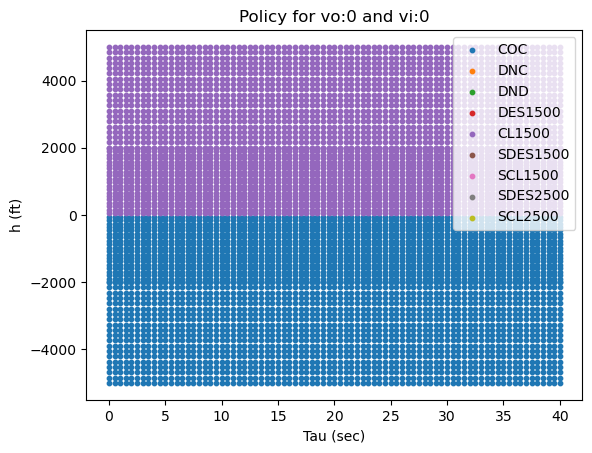

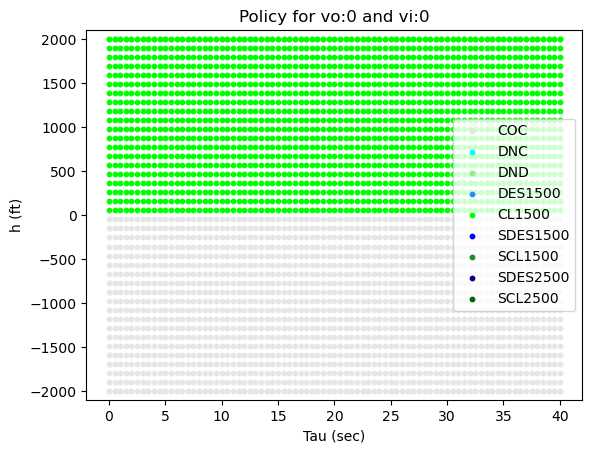

15834/15834 [==============================] - 401s 25ms/step - loss: 0.0343 - accuracy: 0.9624
[interval([-67777.96065294831, 71082.42059386364]), interval([-119823.16874456024, 72263.30257523533]), interval([-121925.0521866425, 93353.81661713327]), interval([-128364.21668327945, 72612.88108927269]), interval([-135543.02419564748, 60925.474662568726]), interval([-113440.21421425242, 67969.67347888686]), interval([-101605.18057117931, 51112.8076201469]), interval([-101388.09745839394, 58472.73680156185]), interval([-97761.5138402273, 57531.276768716685])]
203/203 [==============================] - 1s 2ms/step


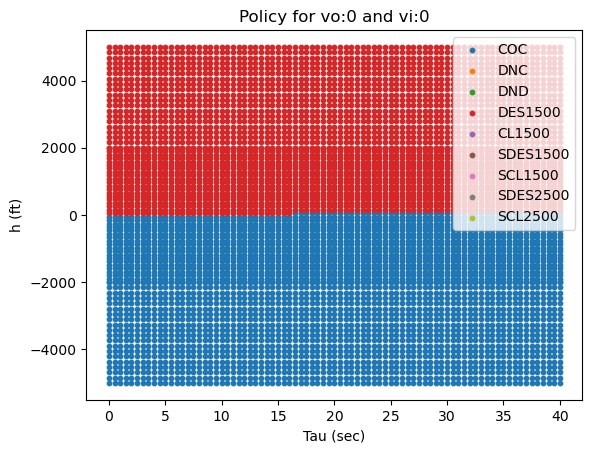

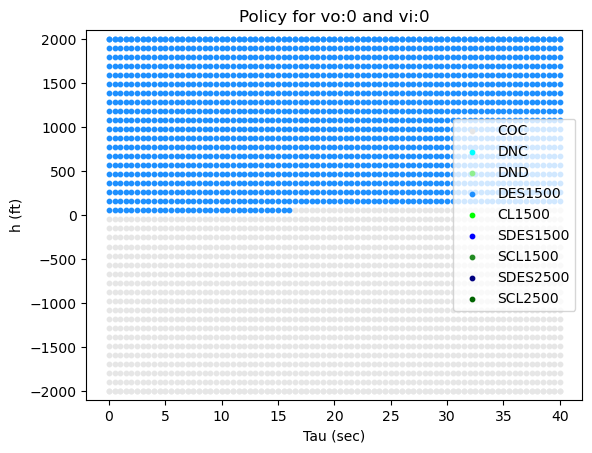

15834/15834 [==============================] - 395s 25ms/step - loss: 0.0278 - accuracy: 0.9658
[interval([-76851.76250849635, 75252.29667443522]), interval([-132620.56656005193, 78065.9131506884]), interval([-136671.84793892593, 101182.5999018884]), interval([-145178.60201020262, 80253.97513616986]), interval([-147787.9612302251, 68757.8556162187]), interval([-128038.73968458283, 75701.87823367068]), interval([-113539.65848185077, 53307.096478004954]), interval([-115025.45127241142, 63214.902456010605]), interval([-110177.02463177765, 62163.44567347777])]
203/203 [==============================] - 0s 2ms/step


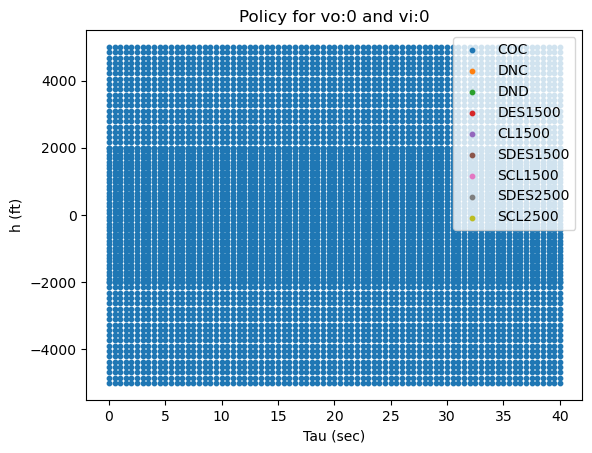

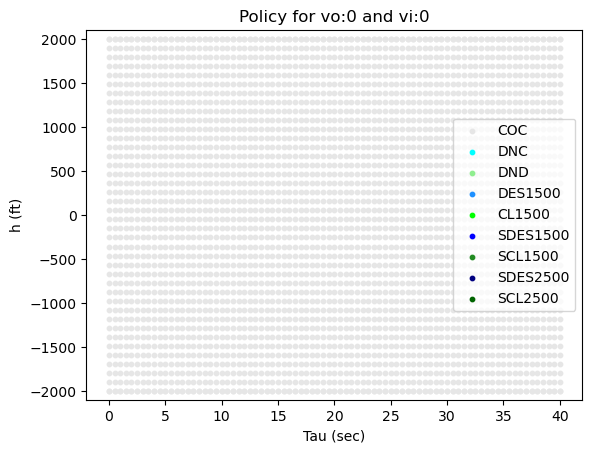

15834/15834 [==============================] - 393s 25ms/step - loss: 0.0240 - accuracy: 0.9681
[interval([-83067.93420184524, 81215.49271784138]), interval([-145779.18151295948, 82179.33673917654]), interval([-153184.62347018838, 107699.06219805568]), interval([-161075.22999048964, 94904.355830962]), interval([-162362.0002861649, 79633.94166440933]), interval([-141315.5034560415, 89134.5015289648]), interval([-126613.14394616958, 55431.16054021294]), interval([-126400.81277652144, 68616.64117743318]), interval([-122557.73152149972, 68479.67107142271])]
203/203 [==============================] - 0s 2ms/step


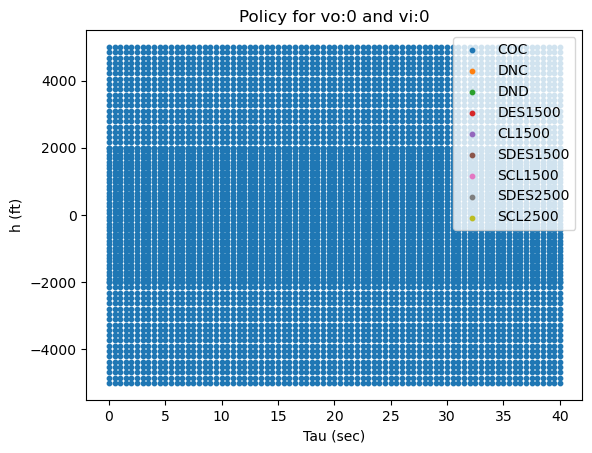

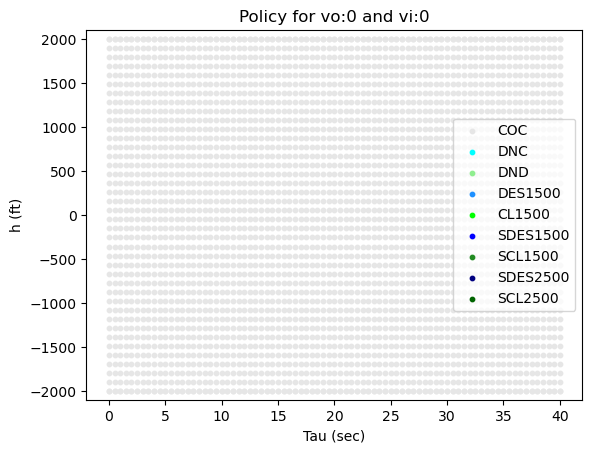

15834/15834 [==============================] - 397s 25ms/step - loss: 0.0211 - accuracy: 0.9701
[interval([-84209.87611037184, 83854.01694568759]), interval([-151090.43680192388, 79590.57183949546]), interval([-160450.00901541006, 108807.60821825844]), interval([-165144.32678923217, 98159.3165020838]), interval([-170627.39515075518, 82204.24088606541]), interval([-145763.24373608388, 89150.1913383275]), interval([-135298.30092864967, 54673.99853860353]), interval([-127900.07570697887, 68423.53959260507]), interval([-132626.1775297171, 69841.78946358264])]
203/203 [==============================] - 0s 2ms/step


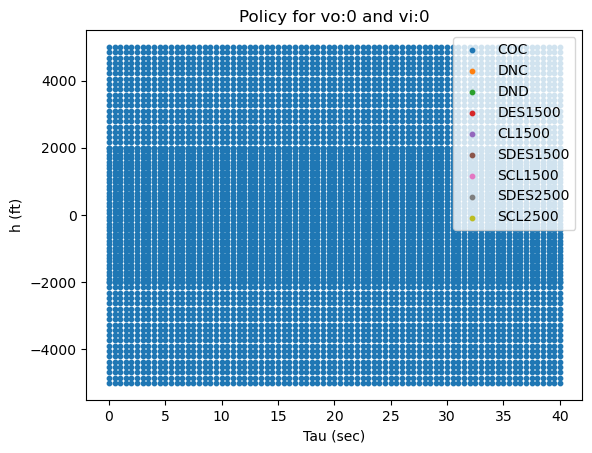

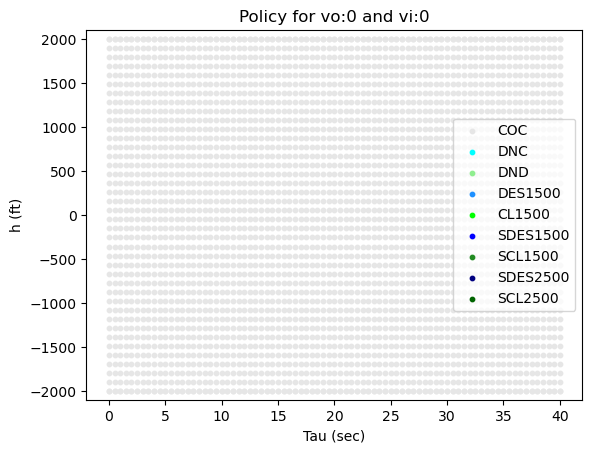

15834/15834 [==============================] - 391s 25ms/step - loss: 0.0191 - accuracy: 0.9712
[interval([-87456.33252877767, 86391.8724673078]), interval([-160990.2656344598, 80123.8997695954]), interval([-167599.2843720588, 116589.3057152479]), interval([-171295.03310236096, 100844.01657927709]), interval([-181723.7865654748, 86574.62670507377]), interval([-153770.82633520407, 91495.72132406184]), interval([-146132.71403864634, 59269.96117430604]), interval([-132034.16532044404, 68853.49915090807]), interval([-142102.53703208492, 72425.58465596508])]
203/203 [==============================] - 0s 2ms/step


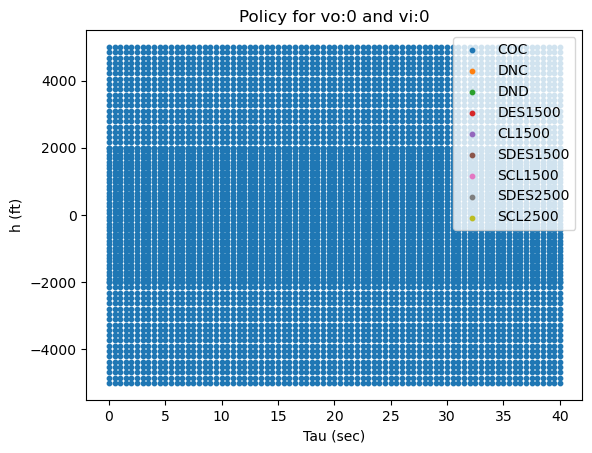

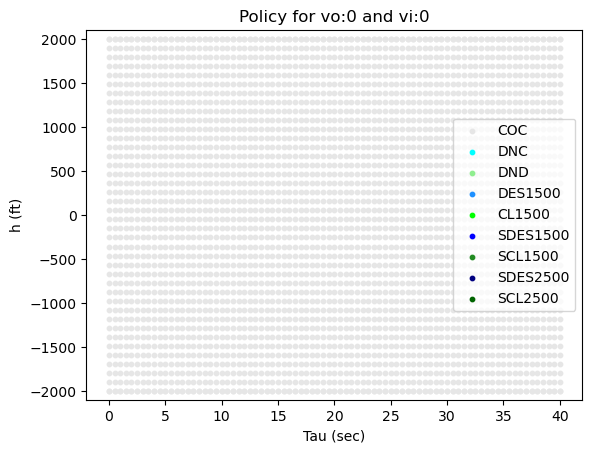

15834/15834 [==============================] - 392s 25ms/step - loss: 0.0176 - accuracy: 0.9722
[interval([-87234.84728301948, 85431.46615951395]), interval([-164656.2245506007, 78177.88514270993]), interval([-169979.72735132117, 116461.28986521257]), interval([-167350.83414665586, 99931.92155565946]), interval([-182945.998535835, 84505.08923144842]), interval([-155890.66560341342, 89340.03211685909]), interval([-152350.19680342101, 57699.75812442548]), interval([-133044.52359480166, 68141.78078834548]), interval([-144551.83011883087, 69849.60857630191])]
203/203 [==============================] - 0s 2ms/step


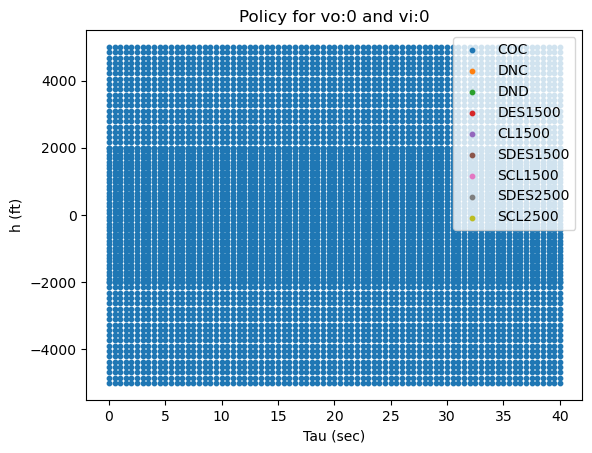

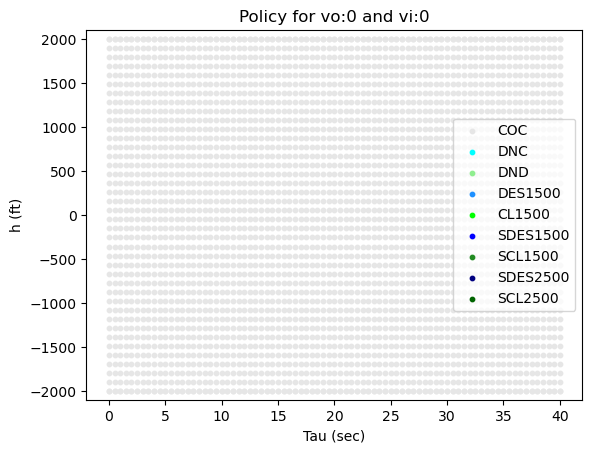

15834/15834 [==============================] - 393s 25ms/step - loss: 0.0164 - accuracy: 0.9730
[interval([-89038.97141251413, 88462.53264254211]), interval([-173409.0097462067, 78543.80456399985]), interval([-177243.22239114798, 122228.51377211622]), interval([-168014.38223173874, 101385.93930098305]), interval([-187723.079789426, 84397.29695159705]), interval([-163856.94840712193, 92029.67669569446]), interval([-155673.80093159666, 58644.996192512874]), interval([-137545.68819369844, 68839.72023919382]), interval([-147925.42705061508, 73266.95047635792])]
203/203 [==============================] - 0s 2ms/step


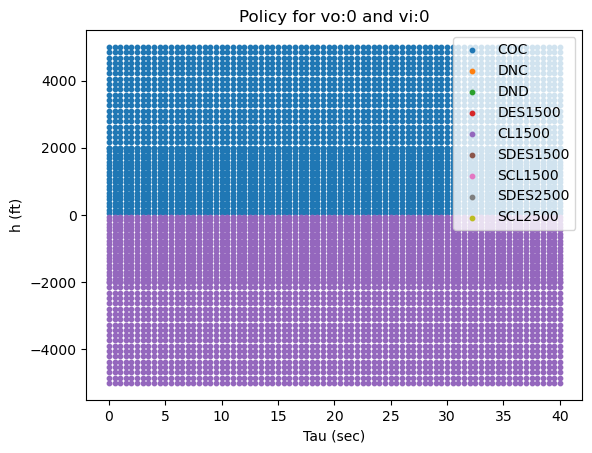

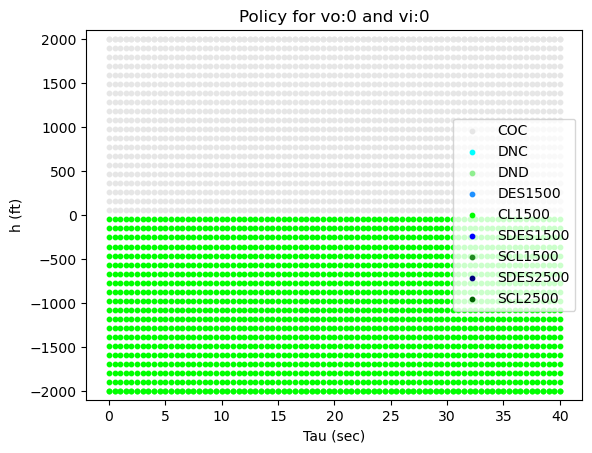

15834/15834 [==============================] - 392s 25ms/step - loss: 0.0153 - accuracy: 0.9736
[interval([-90514.90009203268, 83184.12753894461]), interval([-170532.12167137593, 81844.87371952769]), interval([-177452.33979953543, 130684.5717168277]), interval([-163883.11477601007, 99775.29989722901]), interval([-184907.8783503383, 84079.52825629342]), interval([-160553.04971320517, 94895.00609592324]), interval([-153835.97102650063, 58160.87276249475]), interval([-136097.59790735846, 75338.65646638435]), interval([-144365.15923496627, 74501.99274563449])]
203/203 [==============================] - 1s 3ms/step


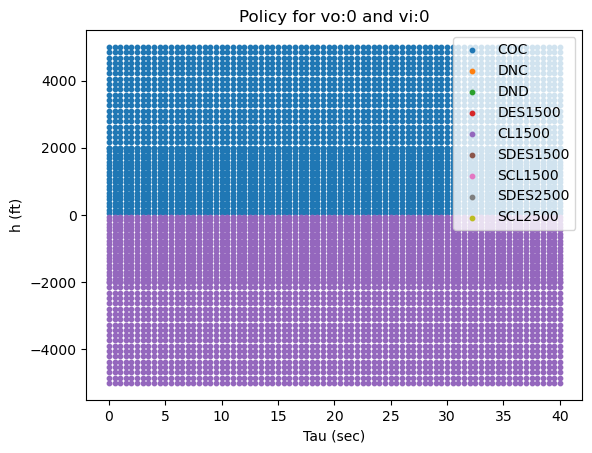

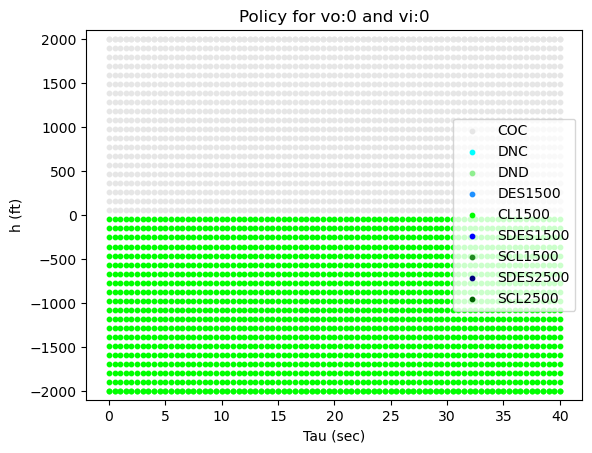

15834/15834 [==============================] - 394s 25ms/step - loss: 0.0144 - accuracy: 0.9743
[interval([-90637.05857812622, 83802.30087764667]), interval([-174676.17242466524, 83508.78815994968]), interval([-181137.42822302718, 133089.50081037421]), interval([-164381.7470661577, 98719.0586158388]), interval([-187936.79816772108, 85474.10617212689]), interval([-161820.68580242395, 94112.55036993664]), interval([-153941.3590537941, 56304.40999780632]), interval([-137626.47427236818, 76114.04370134085]), interval([-143984.47834496753, 76468.3030420343])]
203/203 [==============================] - 0s 2ms/step


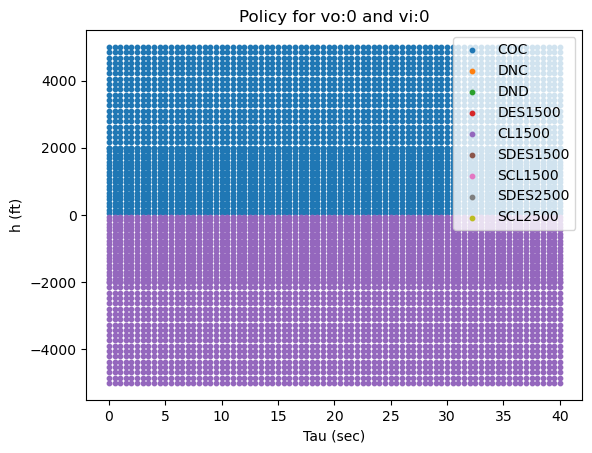

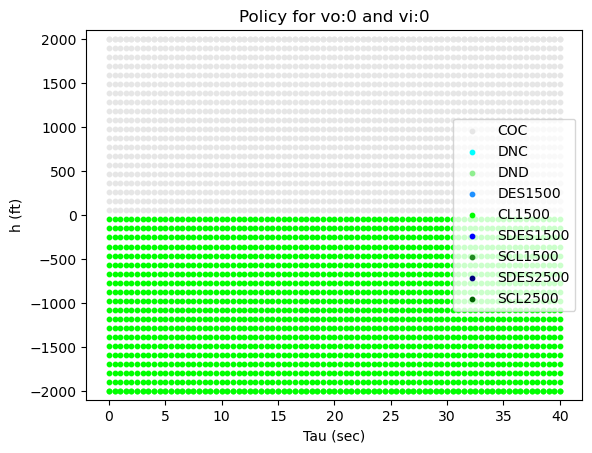

15834/15834 [==============================] - 394s 25ms/step - loss: 0.0137 - accuracy: 0.9747
[interval([-90178.71191002258, 85334.73425959348]), interval([-178677.22468357426, 83236.13806680063]), interval([-183476.36903381627, 141917.36518686268]), interval([-167105.0362198965, 99145.5701955663]), interval([-191265.65426857464, 85092.11819357252]), interval([-166663.17607514752, 96953.15575706703]), interval([-151654.14678283042, 56688.481987244915]), interval([-139409.68334360298, 83490.3787365595]), interval([-143768.89599298564, 79997.42250928289])]
203/203 [==============================] - 0s 2ms/step


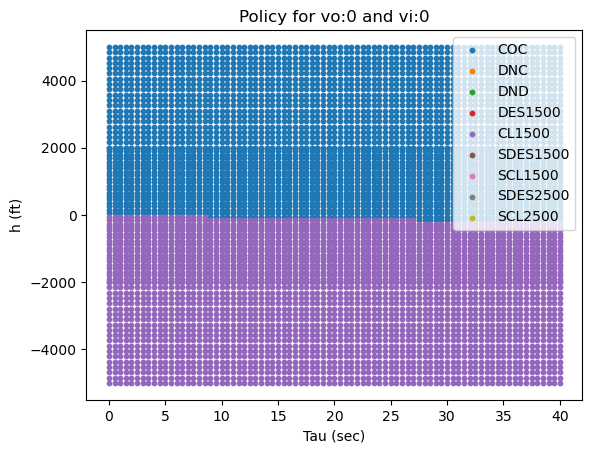

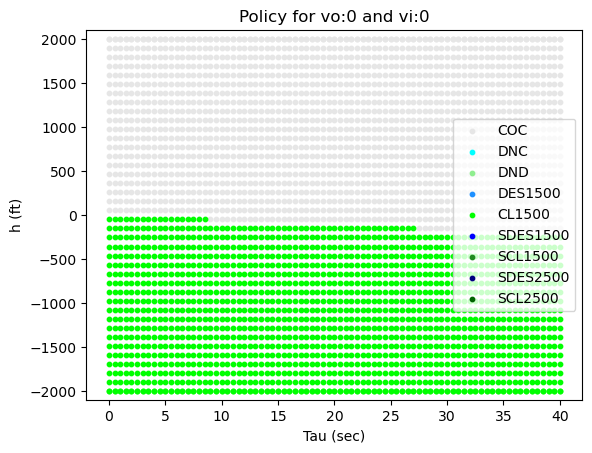

15834/15834 [==============================] - 389s 25ms/step - loss: 0.0130 - accuracy: 0.9752
[interval([-90819.93362568533, 87635.38578177041]), interval([-188253.0374784164, 84661.96716578897]), interval([-188871.33355838712, 147053.55718969845]), interval([-170909.54825399205, 104357.7813265514]), interval([-193798.1746046277, 86631.25086400761]), interval([-173039.54812786446, 98889.30490200962]), interval([-149033.98883645344, 59346.82246025784]), interval([-144534.8229330258, 83428.08981593711]), interval([-147013.1577173728, 81654.55805995643])]
203/203 [==============================] - 0s 2ms/step


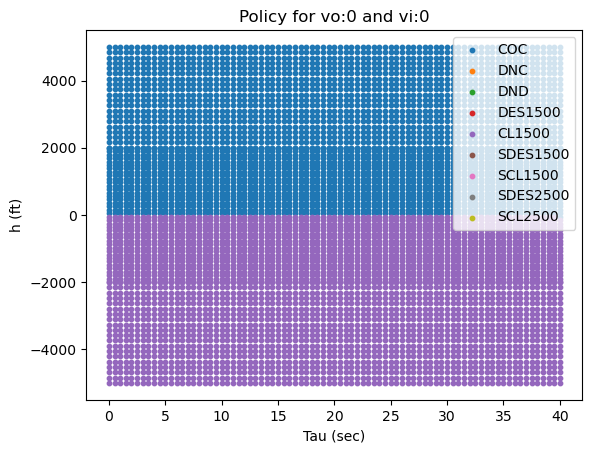

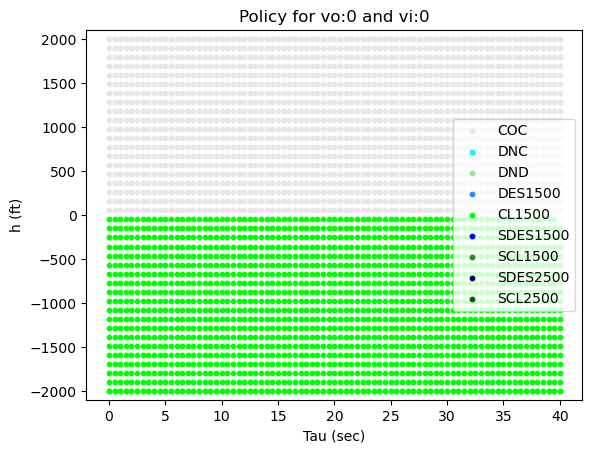

15834/15834 [==============================] - 388s 25ms/step - loss: 0.0123 - accuracy: 0.9757
[interval([-95788.84837062303, 91316.52646623737]), interval([-200257.9444548595, 90377.65461237943]), interval([-198780.24195723387, 158415.6835844506]), interval([-178854.25965858364, 111394.86743486366]), interval([-199541.32054386512, 92189.02179710228]), interval([-180629.132385549, 104157.64376532251]), interval([-152430.0015874465, 62910.37601822206]), interval([-148344.8712648158, 88041.71686505481]), interval([-151443.0611484297, 86727.14030955613])]
203/203 [==============================] - 0s 2ms/step


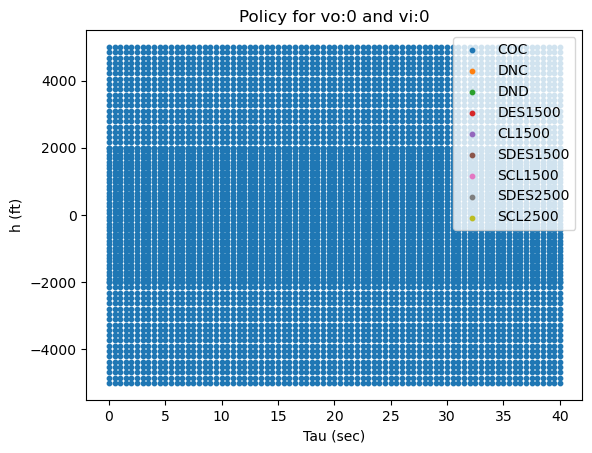

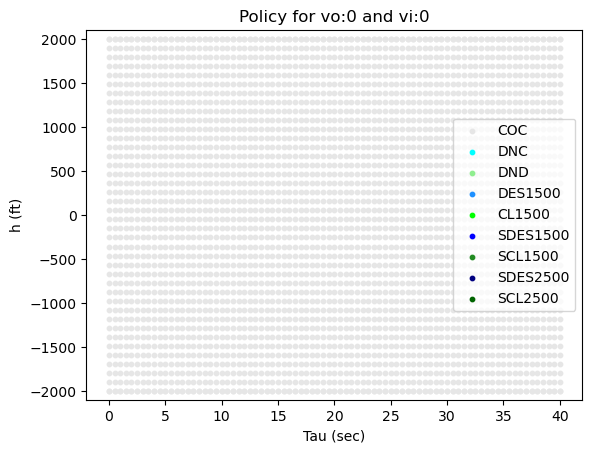

15834/15834 [==============================] - 391s 25ms/step - loss: 0.0119 - accuracy: 0.9760
[interval([-101278.71556444034, 93857.96622534975]), interval([-212258.7001651812, 96380.48124564387]), interval([-210409.9590163468, 173031.96957666066]), interval([-191998.99543984002, 121467.51477521188]), interval([-210774.16768150602, 99417.22470000878]), interval([-193304.61221454843, 117574.66700549364]), interval([-157850.96715275574, 67977.78252189067]), interval([-157146.4051217281, 93152.63731689462]), interval([-160069.2358166575, 93747.96032853716])]
203/203 [==============================] - 0s 2ms/step


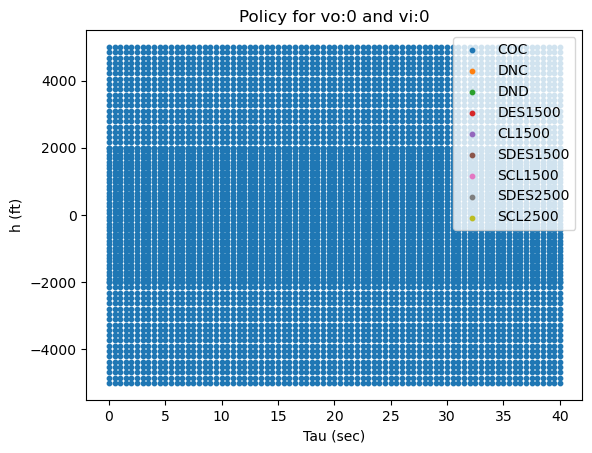

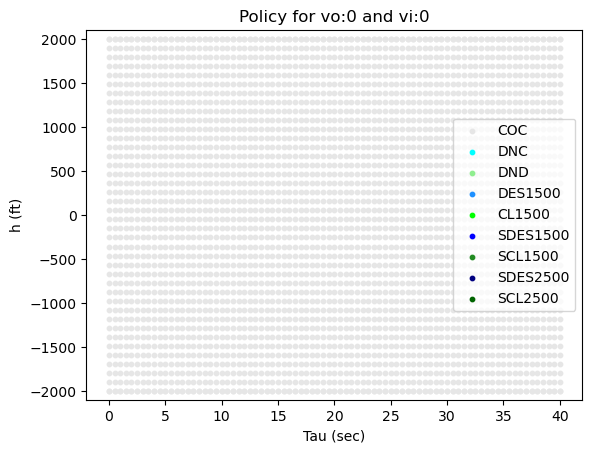

15834/15834 [==============================] - 391s 25ms/step - loss: 0.0114 - accuracy: 0.9763
[interval([-111749.59787105235, 95935.2772813311]), interval([-217555.0461410874, 108053.66865731293]), interval([-219067.52168808487, 182222.07266697063]), interval([-197055.86527158294, 127657.73514969154]), interval([-219294.6413897027, 111305.09491352244]), interval([-198862.22059144935, 121550.4753163765]), interval([-163612.01683672972, 74332.13360129615]), interval([-160921.79422781116, 106412.7681881616]), interval([-166693.316973149, 102658.28182137638])]
203/203 [==============================] - 0s 2ms/step


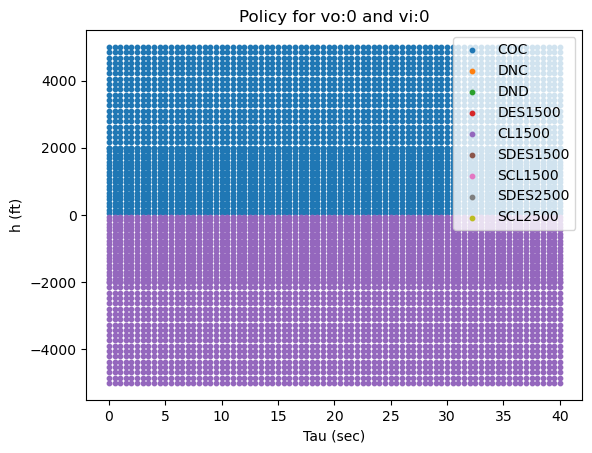

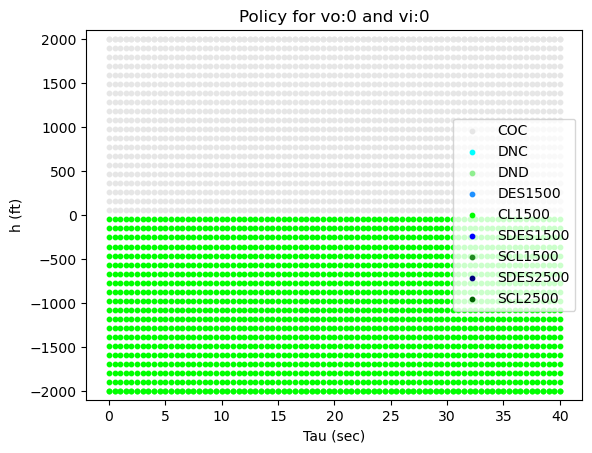

15834/15834 [==============================] - 393s 25ms/step - loss: 0.0110 - accuracy: 0.9765
[interval([-113668.97791384094, 98654.89690141077]), interval([-220325.88595879797, 111551.53985285721]), interval([-227656.96760228393, 186022.3899794707]), interval([-202060.01015702033, 132203.46260733058]), interval([-226851.30210861104, 114932.20743139689]), interval([-201166.25663688115, 125704.75103807091]), interval([-169512.45053286728, 75595.34562536015]), interval([-164754.25583654956, 111872.62640028729]), interval([-174107.8953092856, 109715.06773067688])]
203/203 [==============================] - 0s 2ms/step


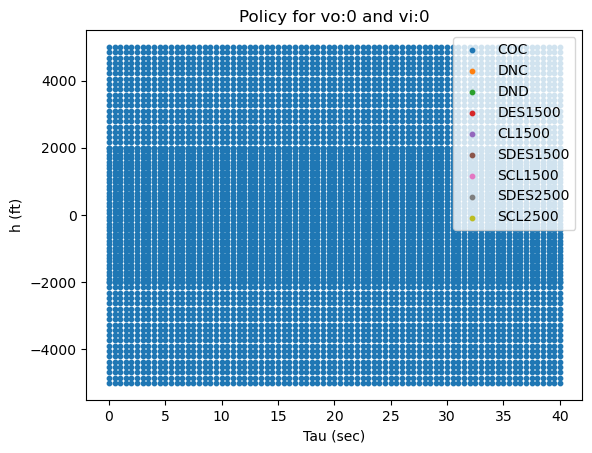

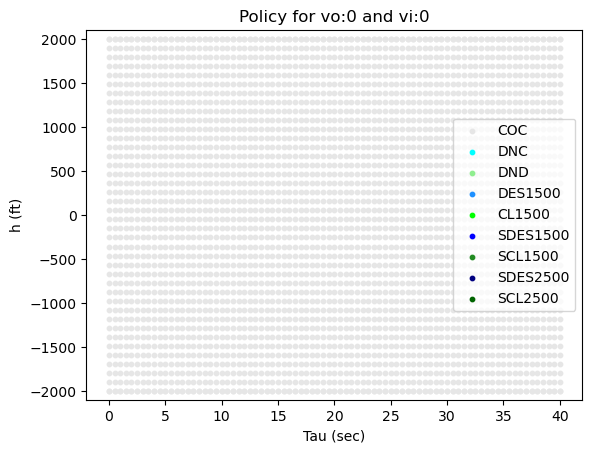

15834/15834 [==============================] - 396s 25ms/step - loss: 0.0102 - accuracy: 0.9770
[interval([-114418.82131295901, 98643.57474404933]), interval([-217908.80349443734, 112175.89526697507]), interval([-225086.2965026598, 185302.57989974917]), interval([-201666.29724841198, 134697.48310853465]), interval([-222468.14024160535, 117481.90724926001]), interval([-199396.12558987574, 124329.0489401848]), interval([-167401.24783989252, 77576.77423874583]), interval([-164963.01501554257, 114514.2716942028]), interval([-174177.7291730741, 111484.61247554638])]
203/203 [==============================] - 1s 2ms/step


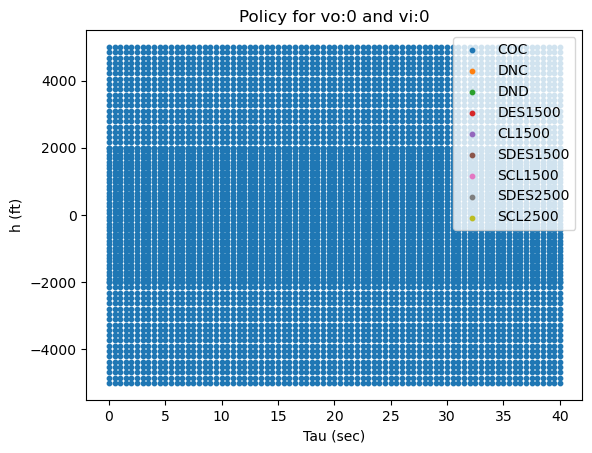

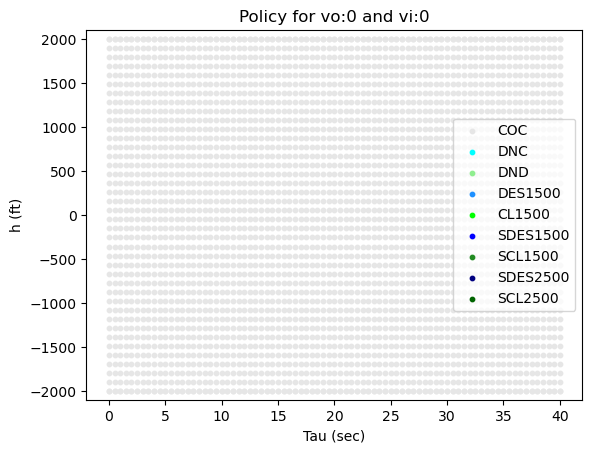

15834/15834 [==============================] - 394s 25ms/step - loss: 0.0100 - accuracy: 0.9771
[interval([-115877.64649965877, 99891.51652986524]), interval([-219279.59591974638, 112255.70284367821]), interval([-229757.68282132028, 191298.6212637772]), interval([-210303.35095650147, 138447.45729627585]), interval([-224353.75204504895, 121782.37541163809]), interval([-206876.20265990705, 130626.77075342256]), interval([-171400.9676110164, 82845.23447976675]), interval([-173022.85845512414, 120980.36902174949]), interval([-176607.70209081887, 121413.82119906085])]
203/203 [==============================] - 0s 2ms/step


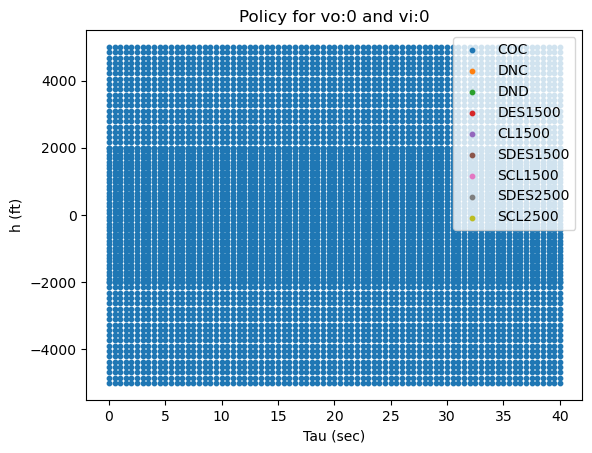

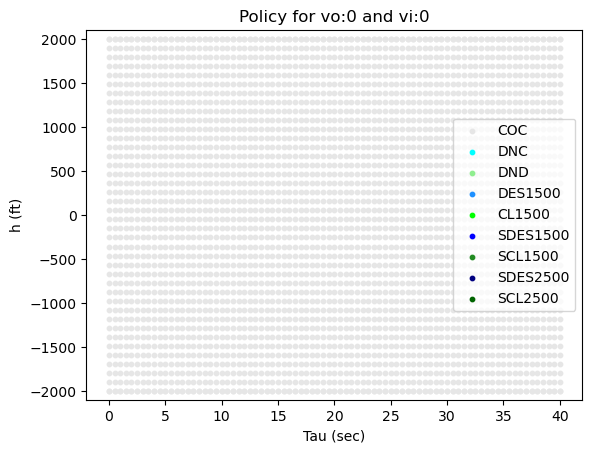

15834/15834 [==============================] - 399s 25ms/step - loss: 0.0096 - accuracy: 0.9776
[interval([-118326.43803415663, 100972.60170752348]), interval([-218698.84430894238, 113104.8614825424]), interval([-236588.13682857205, 198759.55858754634]), interval([-212036.3053667492, 141636.25203942845]), interval([-224962.93452839964, 124940.30120446393]), interval([-208356.1371302399, 128790.66002042574]), interval([-172462.84894761047, 85274.85396790906]), interval([-171775.52206782, 123892.88083257062]), interval([-177056.9338717453, 125884.20566088748])]
203/203 [==============================] - 1s 2ms/step


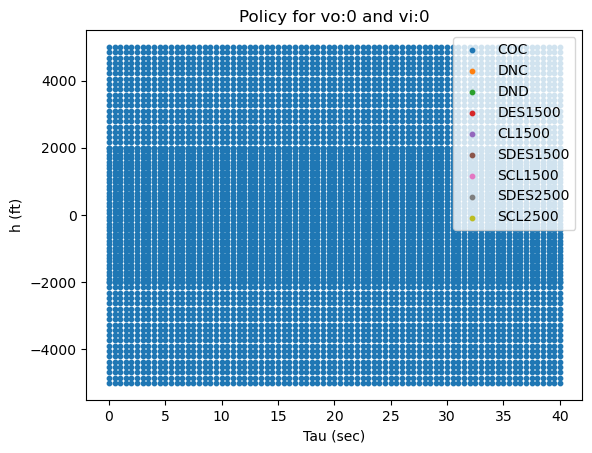

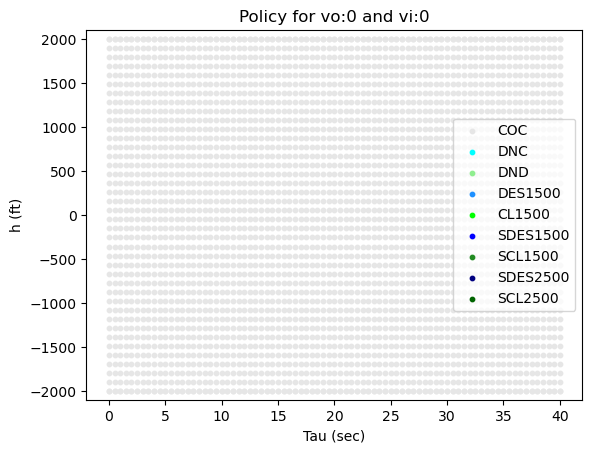

In [108]:
# Define model architecture
model = Sequential()
# model.add(Dense(hu, init='uniform', activation='relu', input_dim=4))
# model.add(Dense(hu, init='uniform', activation='relu'))
# model.add(Dense(hu, init='uniform', activation='relu'))
# model.add(Dense(hu, init='uniform', activation='relu'))
# model.add(Dense(hu, init='uniform', activation='relu'))
# model.add(Dense(hu, init='uniform', activation='relu'))
model.add(Dense(hu, activation="relu", input_dim=4))
model.add(Dense(hu, activation="relu"))
model.add(Dense(hu, activation="relu"))
model.add(Dense(hu, activation="relu"))
model.add(Dense(hu, activation="relu"))
model.add(Dense(hu, activation="relu"))

# model.add(Dense(numOut, init="uniform"))
model.add(Dense(numOut))
opt = Nadam(learning_rate=0.0003)
model.compile(loss=asymMSE, optimizer=opt, metrics=["accuracy"])

# # Train and write nnet files
epoch = saveEvery
while epoch <= totalEpochs:
    model.fit(X_train, Q, epochs=saveEvery, batch_size=2**8, shuffle=True)
    saveFile = nnetFiles % (pra, ver, epoch)
    saveNNet(model, saveFile, means, ranges, min_inputs, max_inputs)
    epoch += saveEvery
    output_interval, penultimate_interval = propagate_interval(
        [
            interval[400, 500],
            interval[50, 51],
            interval[-51, -50],
            interval[20, 21],
        ],
        model,
        graph=False,
    )
    print(output_interval)
    plot_policy(model, f"images/standard_vcas_policy_viz_vo{vo}_vi{vi}_epoch{epoch}.pdf", zoom=True, vo=vo, vi=vi)

In [116]:
X_train

array([[-0.5   , -0.5   , -0.5   , -0.5   ],
       [-0.4375, -0.5   , -0.5   , -0.5   ],
       [-0.375 , -0.5   , -0.5   , -0.5   ],
       ...,
       [ 0.375 ,  0.5   ,  0.5   ,  0.5   ],
       [ 0.4375,  0.5   ,  0.5   ,  0.5   ],
       [ 0.5   ,  0.5   ,  0.5   ,  0.5   ]])

In [120]:
advisory_indices = np.argmax(model.predict(np.array([
    [200, 0, 0, 12],
    [0, 0, 0, 10],
    [-200, 0, 0, 20],
    [-400, 0, 0, 2],
    [400, 0, 0, 2],
    [400, 0, 0, 4],
    [400, 0, 0, 6],
    [400, 0, 0, 8],
])), axis=1)
[action_names[idx] for idx in advisory_indices]

1/1 [==============================] - 0s 13ms/step


['COC', 'DND', 'COC', 'COC', 'COC', 'COC', 'COC', 'COC']

In [ ]:
advisory_indices = np.argmin(model.predict(np.array([
    [200, 0, 0, 12],
    [0, 0, 0, 10],
    [-200, 0, 0, 20],
    [-400, 0, 0, 2],
    [400, 0, 0, 2],
    [400, 0, 0, 4],
    [400, 0, 0, 6],
    [400, 0, 0, 8],
])), axis=1)
[action_names[idx] for idx in advisory_indices]

## Weird results: not what's expected

Should be giving CL/DES1500 for these close-in points above, not a lot of COCs.

Retrain for more epochs? 

In [125]:
totalEpochs = 40
saveEvery = 2

Epoch 1/2


2023-07-10 11:34:08.920420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15834/15834 [==============================] - 377s 24ms/step - loss: 0.1385 - accuracy: 0.9362
Epoch 2/2
15834/15834 [==============================] - 384s 24ms/step - loss: 0.0444 - accuracy: 0.9605
[interval([-51165.83797091159, 52600.46556009127]), interval([-91841.83253472892, 53944.44091988108]), interval([-81143.61781229264, 73327.23377210894]), interval([-59936.13876054185, 60884.304074675856]), interval([-79984.1053738774, 69959.7048821798]), interval([-57504.354485416865, 56188.83312055562]), interval([-69428.80190602923, 49015.6885781918]), interval([-55031.78321871416, 53852.16584610748]), interval([-74527.19743005479, 42973.91540171803])]
 40/203 [====>.........................] - ETA: 0s

2023-07-10 11:46:50.220385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


203/203 [==============================] - 1s 2ms/step


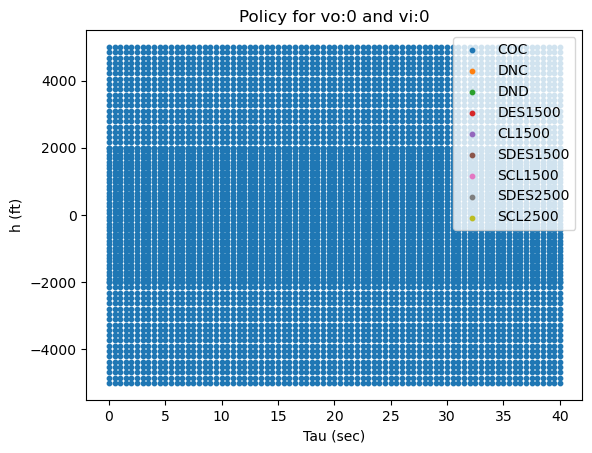

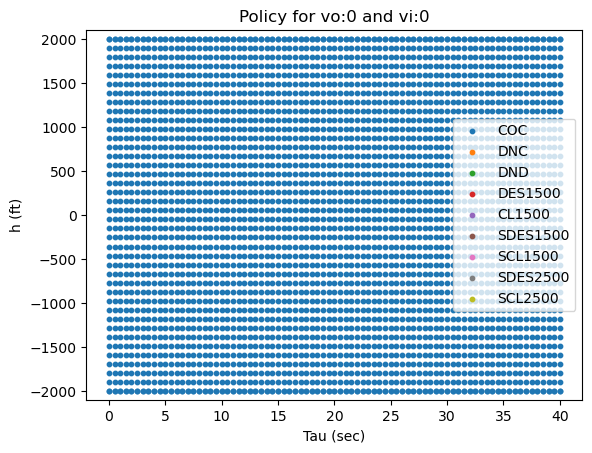

1/1 [==============================] - 0s 79ms/step
['COC', 'CL1500', 'COC', 'COC', 'COC', 'COC', 'COC', 'COC']
Epoch 1/2


2023-07-10 11:46:51.637218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15834/15834 [==============================] - 384s 24ms/step - loss: 0.0324 - accuracy: 0.9650
Epoch 2/2
15834/15834 [==============================] - 384s 24ms/step - loss: 0.0263 - accuracy: 0.9671
[interval([-62732.204154378895, 60621.68386789242]), interval([-130447.9004601565, 65353.577808481845]), interval([-107242.90150900738, 88417.57582664234]), interval([-80624.76403938483, 64141.3208674018]), interval([-108957.73960081441, 102702.63444460132]), interval([-76008.75069276738, 60068.039561258694]), interval([-88943.10441784738, 78795.49517638625]), interval([-75618.44489124774, 58280.54883226938]), interval([-88211.70328301338, 47286.216237723165])]
203/203 [==============================] - 0s 2ms/step


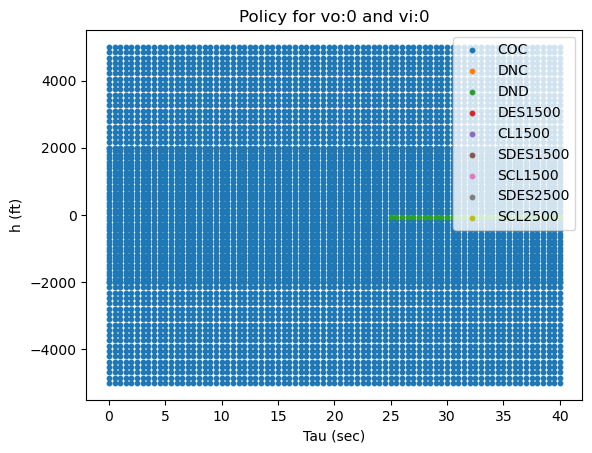

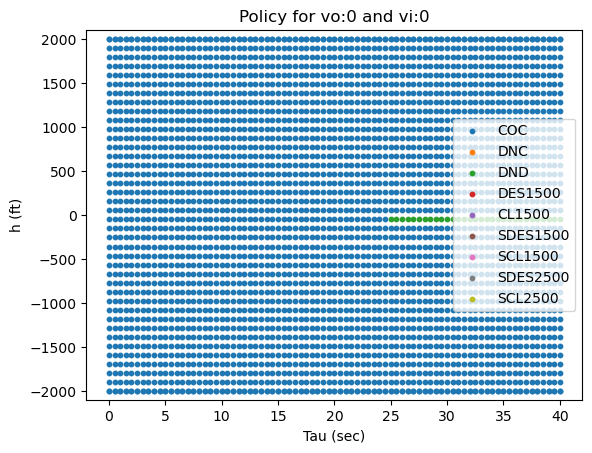

1/1 [==============================] - 0s 14ms/step
['COC', 'COC', 'COC', 'COC', 'COC', 'COC', 'COC', 'COC']
Epoch 1/2
15834/15834 [==============================] - 377s 24ms/step - loss: 0.0224 - accuracy: 0.9688
Epoch 2/2
15834/15834 [==============================] - 563s 36ms/step - loss: 0.0200 - accuracy: 0.9702
[interval([-60092.698754094155, 58460.957926482966]), interval([-136393.96402533082, 66391.19115559931]), interval([-109492.29587602738, 89507.06659719773]), interval([-84177.02841216173, 59984.27454380217]), interval([-117562.39913094965, 109187.51119854816]), interval([-80388.03035705686, 62218.14365683686]), interval([-93894.79351873441, 86535.95503386]), interval([-77211.9891778805, 55693.59041596654]), interval([-81762.51532784327, 46568.83263912749])]
203/203 [==============================] - 1s 2ms/step


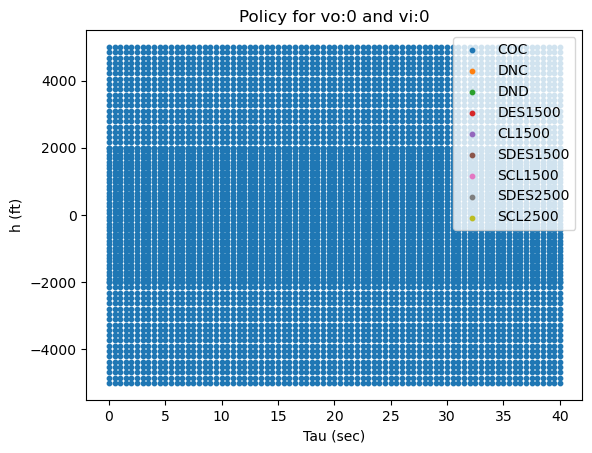

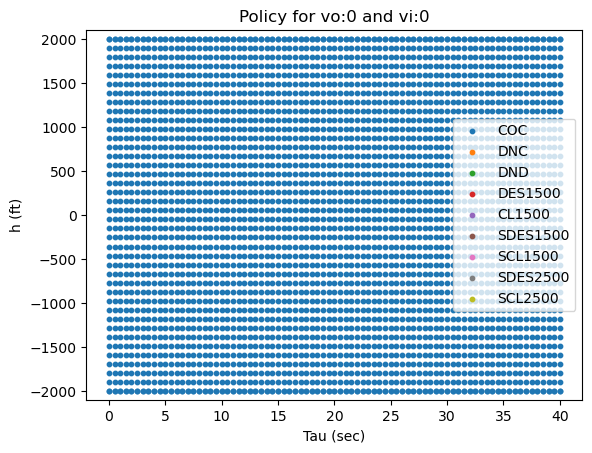

1/1 [==============================] - 0s 18ms/step
['COC', 'COC', 'COC', 'COC', 'COC', 'COC', 'COC', 'COC']
Epoch 1/2
15834/15834 [==============================] - 393s 25ms/step - loss: 0.0180 - accuracy: 0.9714
Epoch 2/2
15834/15834 [==============================] - 372s 24ms/step - loss: 0.0169 - accuracy: 0.9721
[interval([-56956.87062420886, 55317.109720071356]), interval([-135722.02288028318, 65076.915197106755]), interval([-113464.5975431273, 93541.64122587602]), interval([-81928.82385811914, 58399.796973425764]), interval([-122878.87061656377, 107971.52672831061]), interval([-86524.78983632513, 67408.19675004632]), interval([-97664.35754431314, 85935.94922794268]), interval([-78509.15748732329, 52735.567142384774]), interval([-81794.12148367893, 48934.022437827145])]
203/203 [==============================] - 0s 2ms/step


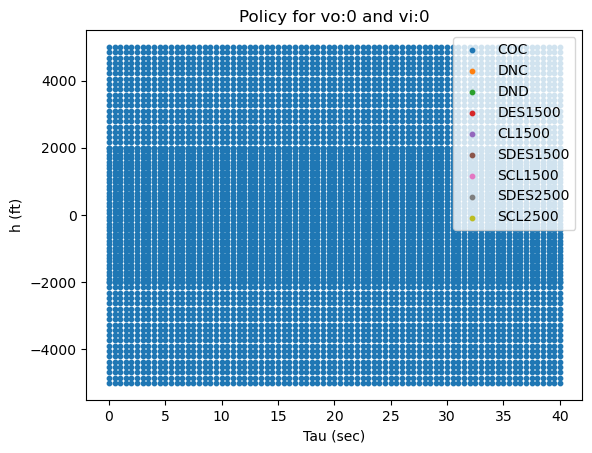

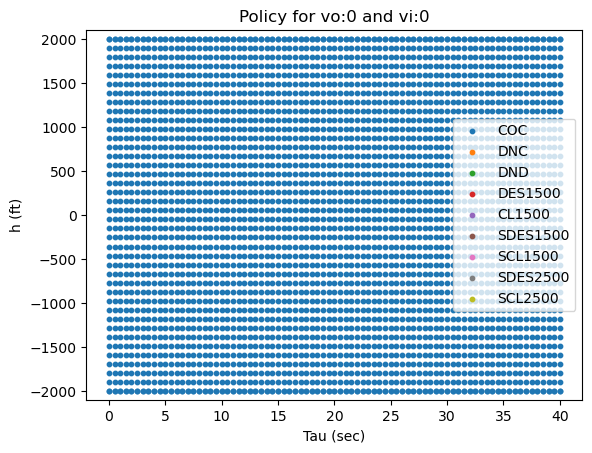

1/1 [==============================] - 0s 12ms/step
['COC', 'COC', 'COC', 'COC', 'COC', 'COC', 'COC', 'COC']
Epoch 1/2
15834/15834 [==============================] - 376s 24ms/step - loss: 0.0158 - accuracy: 0.9727
Epoch 2/2
15834/15834 [==============================] - 375s 24ms/step - loss: 0.0148 - accuracy: 0.9733
[interval([-55113.431557421776, 53130.30326351369]), interval([-140202.2827292305, 65140.75203560697]), interval([-122685.88207279691, 97385.23905471171]), interval([-83043.90604970446, 58635.39234777682]), interval([-130915.29772794349, 110379.50442546788]), interval([-94066.67956571603, 72031.16050537552]), interval([-104513.38627999667, 87003.45356010826]), interval([-80894.51746717404, 49924.15410516014]), interval([-86401.99012152512, 53925.76252194369])]
203/203 [==============================] - 1s 3ms/step


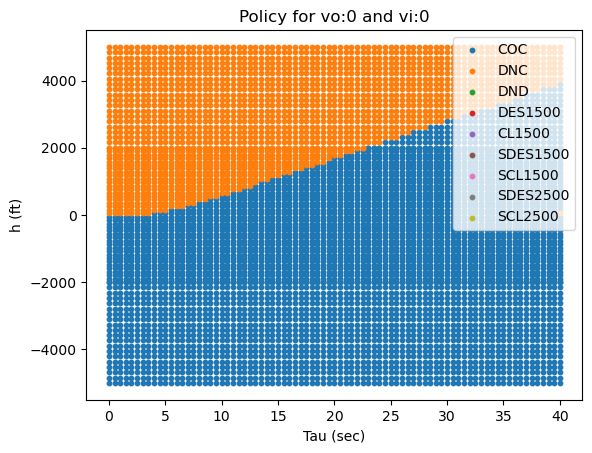

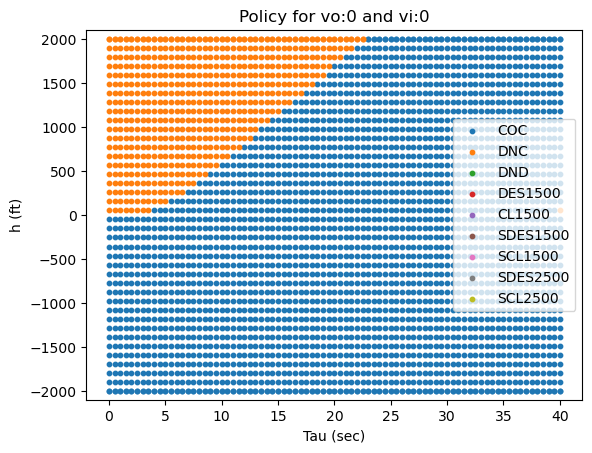

1/1 [==============================] - 0s 12ms/step
['COC', 'COC', 'COC', 'COC', 'DNC', 'DNC', 'DNC', 'DNC']
Epoch 1/2
15834/15834 [==============================] - 390s 25ms/step - loss: 0.0140 - accuracy: 0.9738
Epoch 2/2
15834/15834 [==============================] - 396s 25ms/step - loss: 0.0132 - accuracy: 0.9744
[interval([-50741.60814957041, 48716.41361087702]), interval([-138701.3855546858, 63381.51818207]), interval([-121454.74090219713, 95862.80867751625]), interval([-79670.44340047217, 57093.634158808054]), interval([-132034.13901657838, 106398.40664922688]), interval([-91773.15669709454, 71772.48543632562]), interval([-107452.2725101726, 87532.19272982191]), interval([-76591.42112792013, 46935.97224026691]), interval([-85380.69993083773, 55111.13748937758])]
203/203 [==============================] - 0s 2ms/step


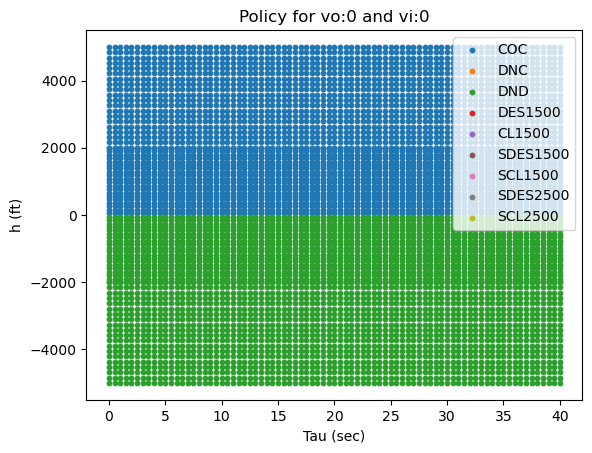

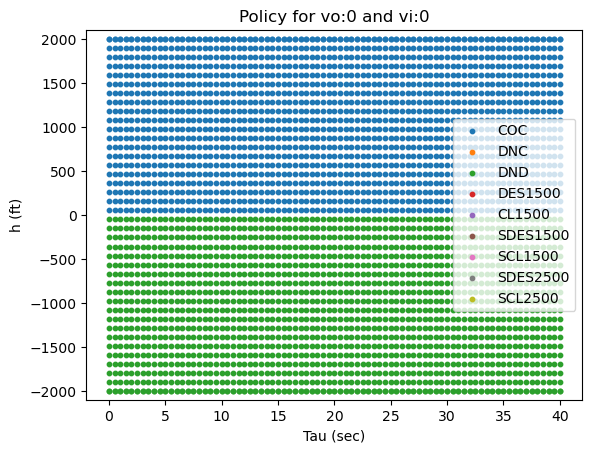

1/1 [==============================] - 0s 19ms/step
['COC', 'COC', 'DND', 'DND', 'COC', 'COC', 'COC', 'COC']
Epoch 1/2
15834/15834 [==============================] - 409s 26ms/step - loss: 0.0126 - accuracy: 0.9749
Epoch 2/2
15834/15834 [==============================] - 394s 25ms/step - loss: 0.0119 - accuracy: 0.9752
[interval([-47344.93801093494, 44973.12550848565]), interval([-132577.44720859115, 60772.40811758801]), interval([-119488.03266732594, 90946.96269579096]), interval([-76611.9846964841, 55224.40781929773]), interval([-130780.431693736, 103497.64535893628]), interval([-91162.49914080628, 70907.91469608864]), interval([-110024.61120825123, 86723.31731194841]), interval([-73720.92709982963, 44018.259372850946]), interval([-83390.43317358411, 54628.74737598963])]
203/203 [==============================] - 0s 2ms/step


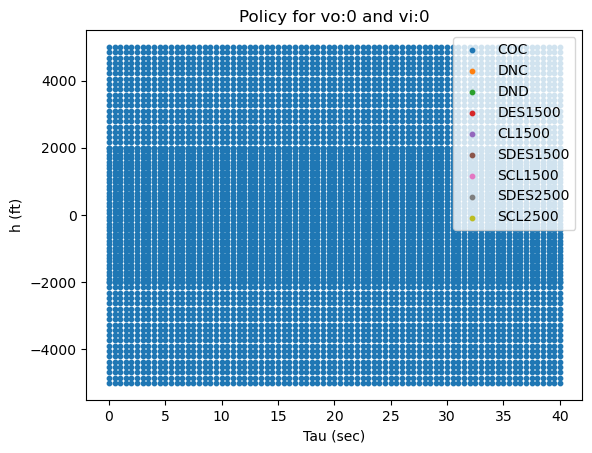

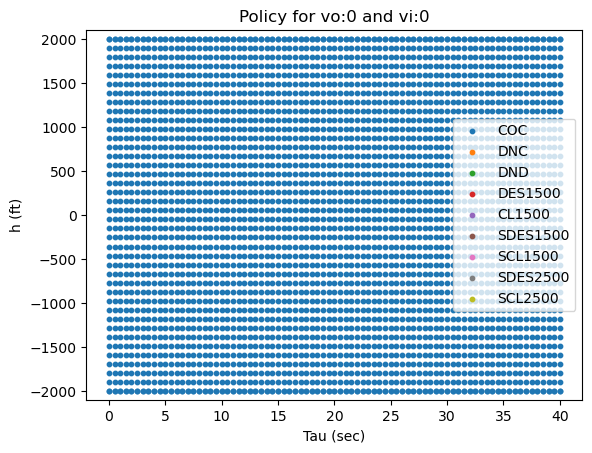

1/1 [==============================] - 0s 14ms/step
['COC', 'COC', 'COC', 'COC', 'COC', 'COC', 'COC', 'COC']
Epoch 1/2
15834/15834 [==============================] - 400s 25ms/step - loss: 0.0113 - accuracy: 0.9755
Epoch 2/2
15834/15834 [==============================] - 413s 26ms/step - loss: 0.0109 - accuracy: 0.9758
[interval([-46362.4113524945, 43218.281995687285]), interval([-130474.26672059837, 57896.16301894385]), interval([-121597.15048828095, 92150.78877453234]), interval([-75647.17532577853, 54291.67778855962]), interval([-134073.0589037547, 107421.49116880978]), interval([-89522.30068191532, 72045.02712752672]), interval([-116313.86464116725, 91871.90070127309]), interval([-71364.58241965796, 49912.526839642356]), interval([-85625.59570822486, 57618.56765893681])]
203/203 [==============================] - 1s 2ms/step


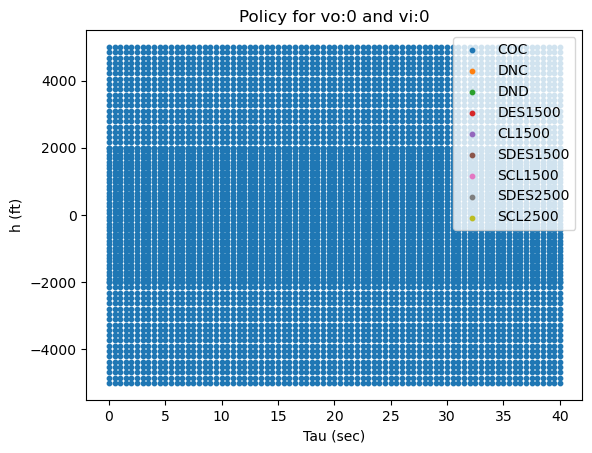

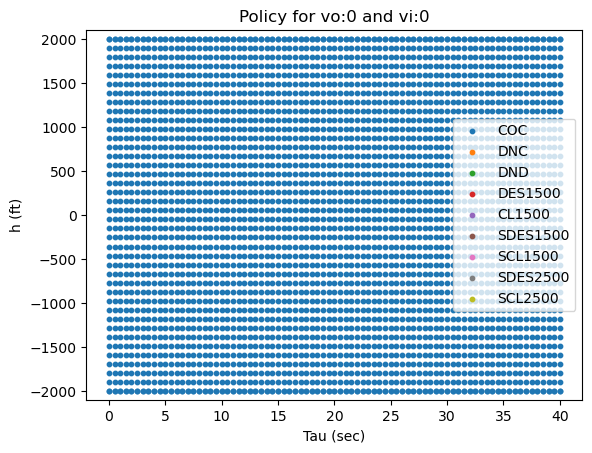

1/1 [==============================] - 0s 12ms/step
['COC', 'COC', 'COC', 'COC', 'COC', 'COC', 'COC', 'COC']
Epoch 1/2
15834/15834 [==============================] - 407s 26ms/step - loss: 0.0104 - accuracy: 0.9762
Epoch 2/2
15834/15834 [==============================] - 388s 25ms/step - loss: 0.0100 - accuracy: 0.9763
[interval([-44924.45070934532, 40458.26309592851]), interval([-126792.43440192082, 55478.47340433363]), interval([-120685.94520061262, 85587.93883686638]), interval([-74786.85856387376, 54959.14123674459]), interval([-135880.6967239678, 107114.92386647068]), interval([-85267.55556296282, 69396.35856692366]), interval([-123105.69988643324, 92407.88301365473]), interval([-71952.67297917532, 49577.07661452922]), interval([-86230.5072423595, 57907.20834466115])]
203/203 [==============================] - 0s 2ms/step


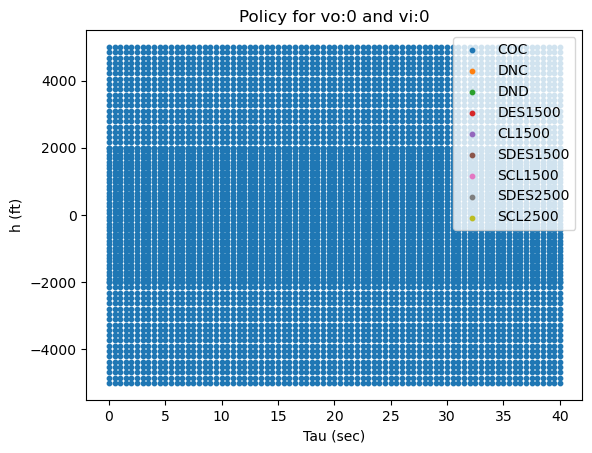

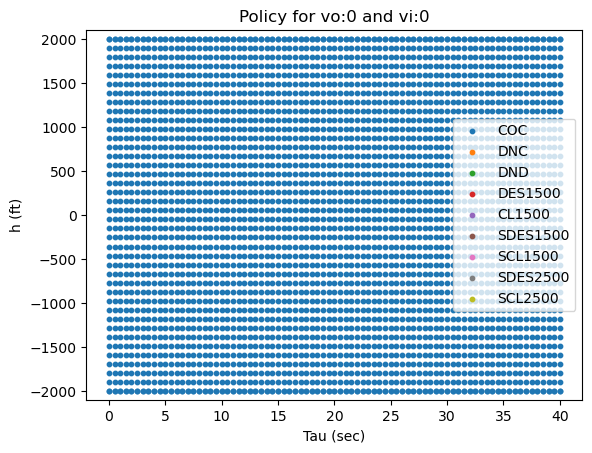

1/1 [==============================] - 0s 24ms/step
['COC', 'COC', 'COC', 'COC', 'COC', 'COC', 'COC', 'COC']
Epoch 1/2
15834/15834 [==============================] - 380s 24ms/step - loss: 0.0098 - accuracy: 0.9766
Epoch 2/2
15834/15834 [==============================] - 374s 24ms/step - loss: 0.0094 - accuracy: 0.9769
[interval([-45926.628666435856, 41375.78564264219]), interval([-129577.69179881364, 57967.79921152022]), interval([-127676.69140894442, 81862.39165141871]), interval([-76214.94111102664, 57429.37548285521]), interval([-144438.91734279218, 110030.87469498378]), interval([-90708.72139627126, 71756.66064293339]), interval([-134423.48538010585, 97096.95624354301]), interval([-75277.1055230028, 52311.41291510701]), interval([-92674.99962300659, 58713.034024131994])]
203/203 [==============================] - 0s 2ms/step


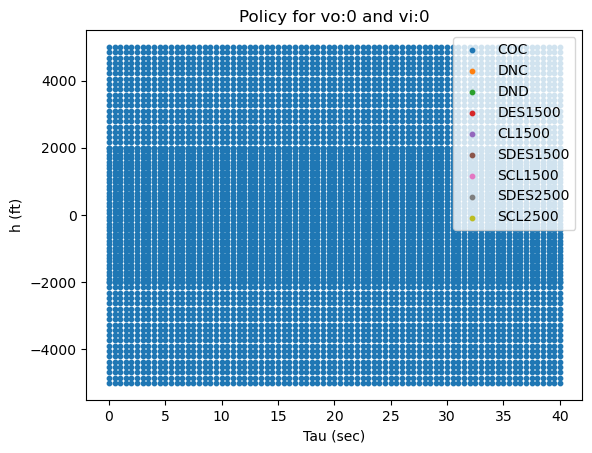

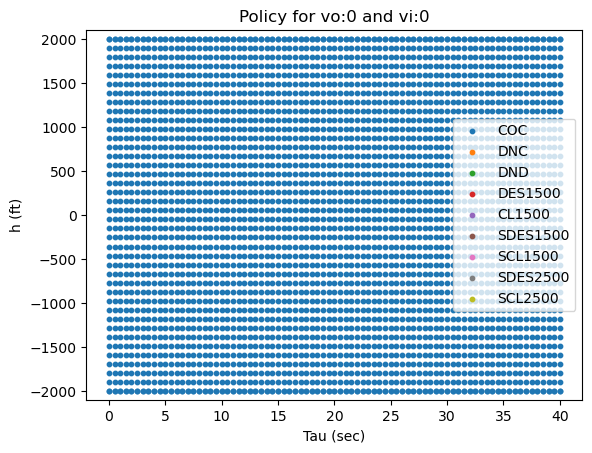

1/1 [==============================] - 0s 11ms/step
['COC', 'COC', 'COC', 'COC', 'COC', 'COC', 'COC', 'COC']
Epoch 1/2
15834/15834 [==============================] - 376s 24ms/step - loss: 0.0091 - accuracy: 0.9772
Epoch 2/2
15834/15834 [==============================] - 377s 24ms/step - loss: 0.0088 - accuracy: 0.9775
[interval([-43524.1251901477, 38482.97431868496]), interval([-120468.0148877247, 54014.942530893124]), interval([-125184.91271886339, 77964.03959755477]), interval([-71300.77685882057, 56135.93285820725]), interval([-143105.76589725752, 103247.59382217737]), interval([-90594.14843406917, 70715.31758589593]), interval([-135598.2447399988, 93935.4734896104]), interval([-73670.04304993841, 49236.39857542823]), interval([-91858.42609651465, 56874.5300967111])]
203/203 [==============================] - 0s 2ms/step


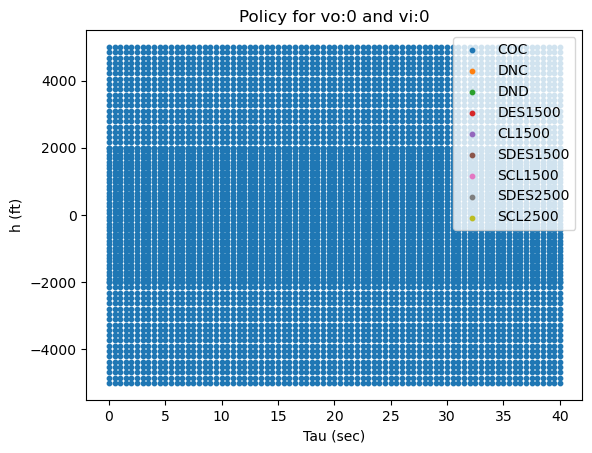

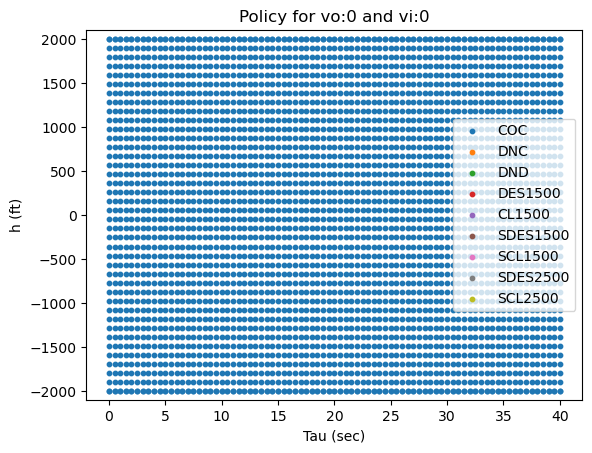

1/1 [==============================] - 0s 18ms/step
['COC', 'COC', 'COC', 'COC', 'COC', 'COC', 'COC', 'COC']
Epoch 1/2
15834/15834 [==============================] - 388s 25ms/step - loss: 0.0086 - accuracy: 0.9776
Epoch 2/2
15834/15834 [==============================] - 379s 24ms/step - loss: 0.0082 - accuracy: 0.9780
[interval([-45603.443468466205, 39537.07362336114]), interval([-118699.59133516956, 52192.77916427672]), interval([-130451.99728659815, 78708.74795656702]), interval([-71857.10663212424, 56003.6081684752]), interval([-149940.82843183936, 105071.34040151059]), interval([-93328.67716327526, 71708.25258534955]), interval([-142778.92541228098, 94678.64016239914]), interval([-76560.26293906396, 46923.16199907829]), interval([-98513.78309769329, 58750.16310245682])]
203/203 [==============================] - 0s 2ms/step


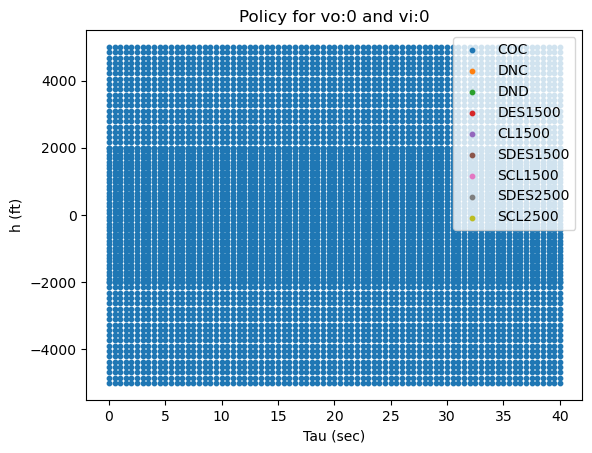

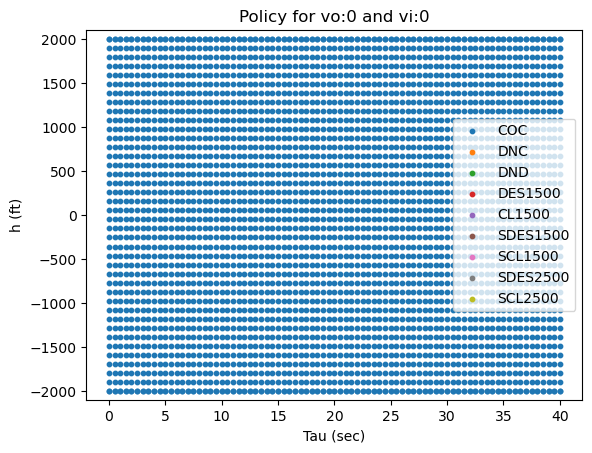

1/1 [==============================] - 0s 12ms/step
['COC', 'COC', 'COC', 'COC', 'COC', 'COC', 'COC', 'COC']
Epoch 1/2
15834/15834 [==============================] - 380s 24ms/step - loss: 0.0080 - accuracy: 0.9782
Epoch 2/2
15834/15834 [==============================] - 380s 24ms/step - loss: 0.0078 - accuracy: 0.9784
[interval([-45394.70649006577, 36776.072942606756]), interval([-109680.03885709011, 48995.40755376231]), interval([-130583.28397874898, 76988.1931691687]), interval([-69821.11212063367, 54183.46579898036]), interval([-148653.55274475642, 101275.26918548207]), interval([-88950.63813102218, 66986.34134268867]), interval([-143430.17815344923, 93681.17929164389]), interval([-75175.88861888331, 42595.46959633045]), interval([-98767.97893148697, 58669.80378990569])]
203/203 [==============================] - 0s 2ms/step


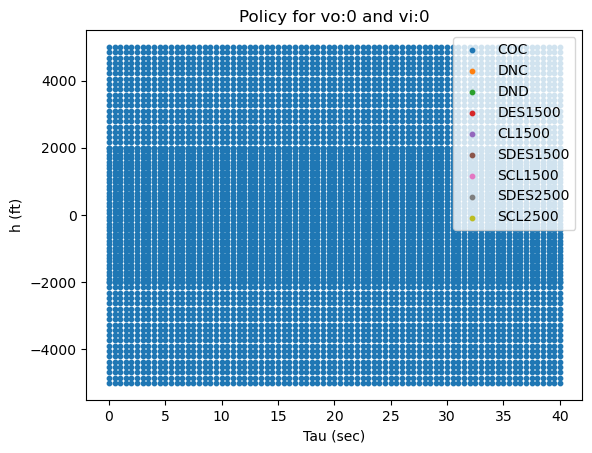

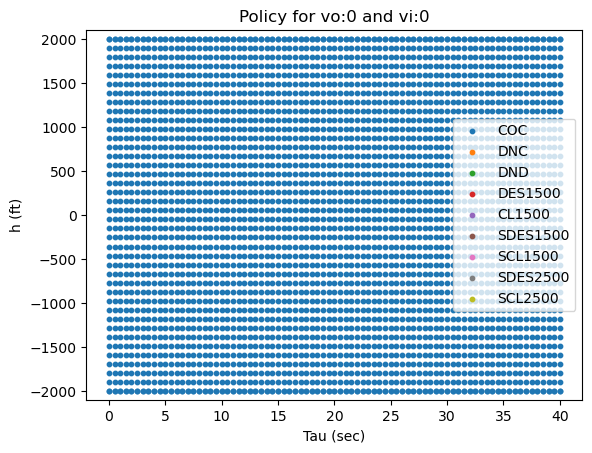

1/1 [==============================] - 0s 10ms/step
['COC', 'COC', 'COC', 'COC', 'COC', 'COC', 'COC', 'COC']
Epoch 1/2
15834/15834 [==============================] - 377s 24ms/step - loss: 0.0076 - accuracy: 0.9786
Epoch 2/2
15834/15834 [==============================] - 383s 24ms/step - loss: 0.0076 - accuracy: 0.9787
[interval([-47519.267312767886, 38689.75526445111]), interval([-113509.67227532298, 48410.19041222599]), interval([-137640.419601322, 83551.03464120718]), interval([-72910.83322876725, 56524.20607001075]), interval([-156211.543499742, 106956.75983414149]), interval([-93775.75636476859, 69031.22625730664]), interval([-153048.56270710222, 98998.84460529374]), interval([-78806.98050623611, 41739.39484449094]), interval([-106471.84096178776, 61288.71494030881])]
203/203 [==============================] - 1s 2ms/step


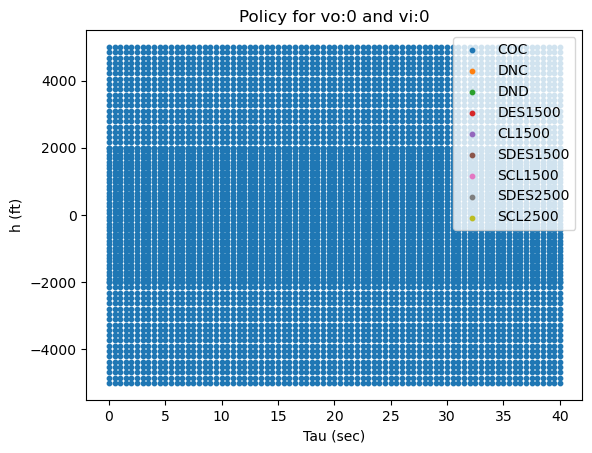

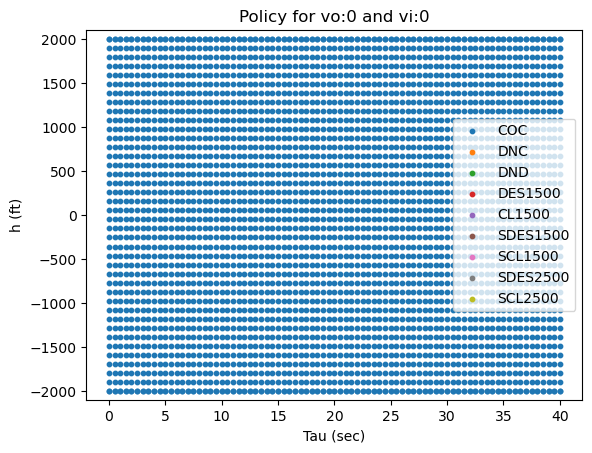

1/1 [==============================] - 0s 12ms/step
['COC', 'COC', 'COC', 'COC', 'COC', 'COC', 'COC', 'COC']
Epoch 1/2
15834/15834 [==============================] - 390s 25ms/step - loss: 0.0072 - accuracy: 0.9788
Epoch 2/2
15834/15834 [==============================] - 383s 24ms/step - loss: 0.0072 - accuracy: 0.9790
[interval([-48644.22885348076, 37982.57293652894]), interval([-112308.00375685873, 45411.93965426474]), interval([-141152.03169347657, 87156.95719303883]), interval([-73951.5409947643, 55818.462434793015]), interval([-161997.2633812562, 109343.65825403789]), interval([-91023.83169149597, 66906.63882334995]), interval([-157112.77065102756, 98742.64512853329]), interval([-79295.58253446796, 39532.281813803784]), interval([-111199.10269193456, 63707.28025444508])]
203/203 [==============================] - 0s 2ms/step


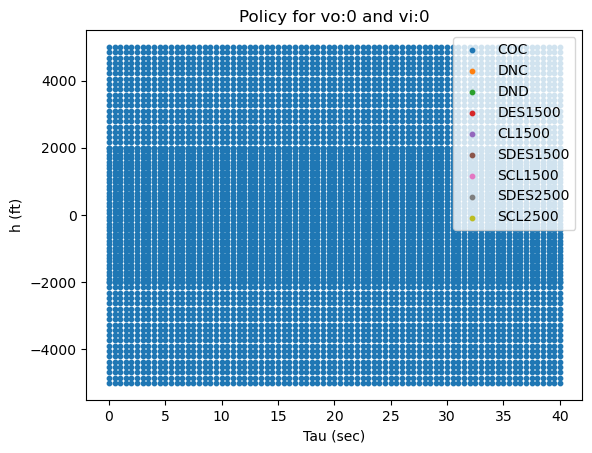

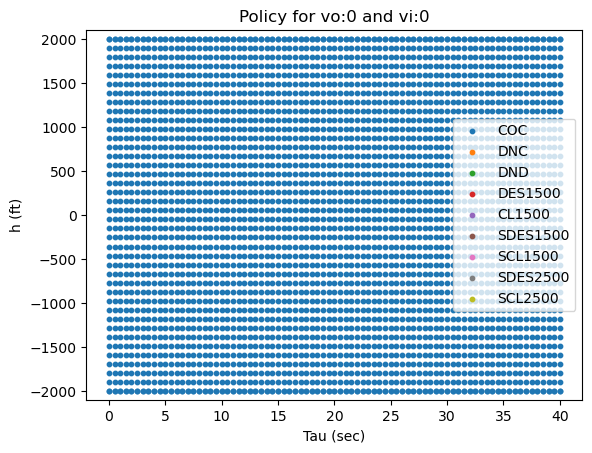

1/1 [==============================] - 0s 11ms/step
['COC', 'COC', 'COC', 'COC', 'COC', 'COC', 'COC', 'COC']
Epoch 1/2
15834/15834 [==============================] - 379s 24ms/step - loss: 0.0068 - accuracy: 0.9793
Epoch 2/2
15834/15834 [==============================] - 375s 24ms/step - loss: 0.0068 - accuracy: 0.9794
[interval([-51173.610329472474, 38446.53230122069]), interval([-113449.58987702102, 44226.92496459745]), interval([-148845.05324356086, 93376.3350905786]), interval([-77048.5529107369, 58772.33128746006]), interval([-165312.93434605777, 112747.23660592506]), interval([-92440.29644065755, 67651.2455786963]), interval([-160228.97436504942, 101799.65940959616]), interval([-78388.45924852291, 40559.402600144706]), interval([-113564.7423454125, 66377.65013770823])]
203/203 [==============================] - 1s 6ms/step


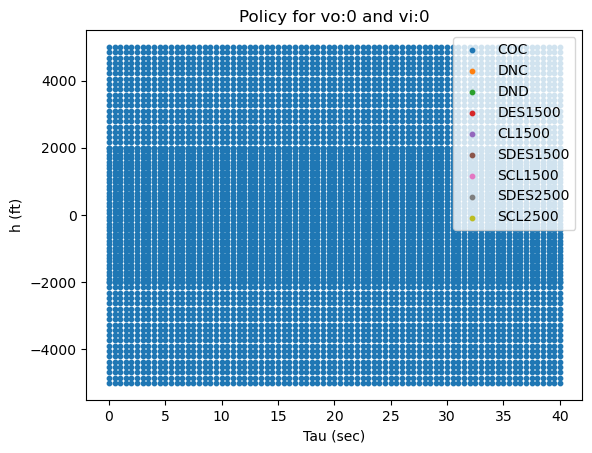

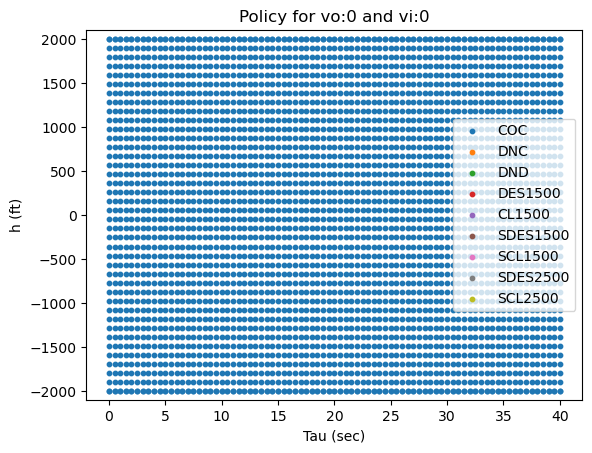

1/1 [==============================] - 0s 13ms/step
['COC', 'COC', 'COC', 'COC', 'COC', 'COC', 'COC', 'COC']
Epoch 1/2
15834/15834 [==============================] - 400s 25ms/step - loss: 0.0066 - accuracy: 0.9796
Epoch 2/2
15834/15834 [==============================] - 386s 24ms/step - loss: 0.0065 - accuracy: 0.9796
[interval([-50439.18403117768, 37320.473915567934]), interval([-110400.92526854711, 40565.54265150335]), interval([-143520.17350857536, 92434.53928186244]), interval([-74400.68013445601, 55694.71377212625]), interval([-159380.15802240325, 110274.63406065389]), interval([-88062.9255855686, 61528.1257005585]), interval([-152939.4739421851, 98898.85763642612]), interval([-74816.82434446707, 37067.044921419976]), interval([-108055.58334679228, 66887.49399436549])]
203/203 [==============================] - 0s 2ms/step


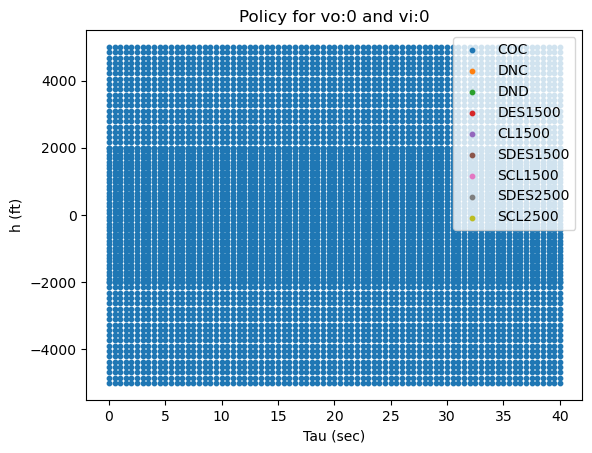

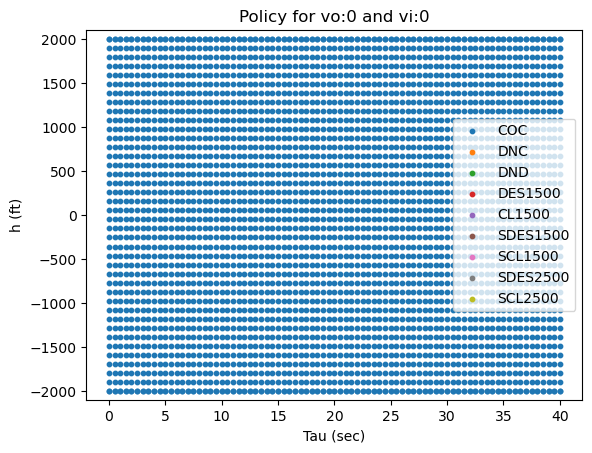

1/1 [==============================] - 0s 13ms/step
['COC', 'COC', 'COC', 'COC', 'COC', 'COC', 'COC', 'COC']
Epoch 1/2
15834/15834 [==============================] - 388s 25ms/step - loss: 0.0064 - accuracy: 0.9797
Epoch 2/2
15834/15834 [==============================] - 384s 24ms/step - loss: 0.0063 - accuracy: 0.9800
[interval([-50276.4584358947, 36780.172634897026]), interval([-109247.55676078063, 39221.329217650156]), interval([-146013.31560802707, 94102.18325610027]), interval([-73372.7043507889, 53808.82862287043]), interval([-159643.12910527486, 108634.90523659112]), interval([-85906.83086966438, 62100.13533959976]), interval([-151816.7887159924, 98483.40499365657]), interval([-73954.23294356823, 35422.322083557585]), interval([-112027.70000815163, 67744.36885425549])]
203/203 [==============================] - 0s 2ms/step


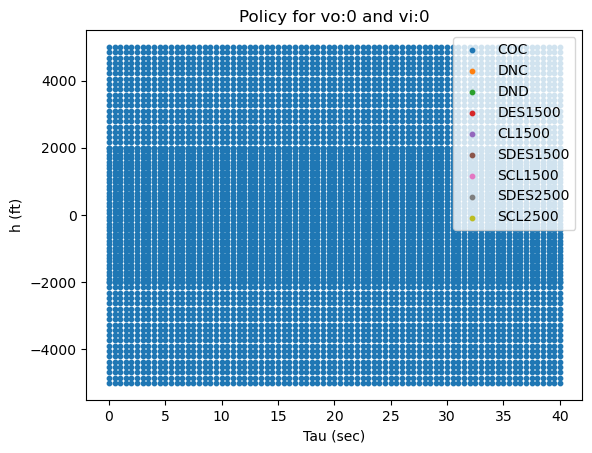

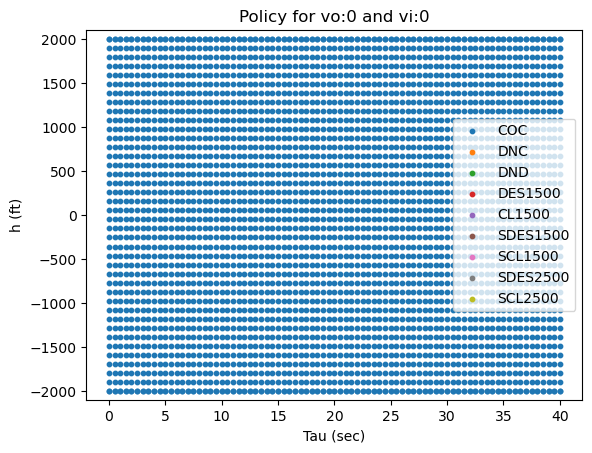

1/1 [==============================] - 0s 11ms/step
['COC', 'COC', 'COC', 'COC', 'COC', 'COC', 'COC', 'COC']
Epoch 1/2
15834/15834 [==============================] - 374s 24ms/step - loss: 0.0062 - accuracy: 0.9803
Epoch 2/2
15834/15834 [==============================] - 374s 24ms/step - loss: 0.0062 - accuracy: 0.9803
[interval([-49117.42442595726, 37789.67575793223]), interval([-108173.5498338745, 37568.194428528885]), interval([-148803.9488679856, 95970.92569729223]), interval([-74451.19765339766, 54191.47095973999]), interval([-159577.90929994156, 110448.01819680406]), interval([-83633.09901887584, 58567.72498383798]), interval([-151350.57171458885, 98896.13385563761]), interval([-70418.21757596167, 33322.23159394525]), interval([-111165.20949839031, 68911.10772908937])]
203/203 [==============================] - 0s 2ms/step


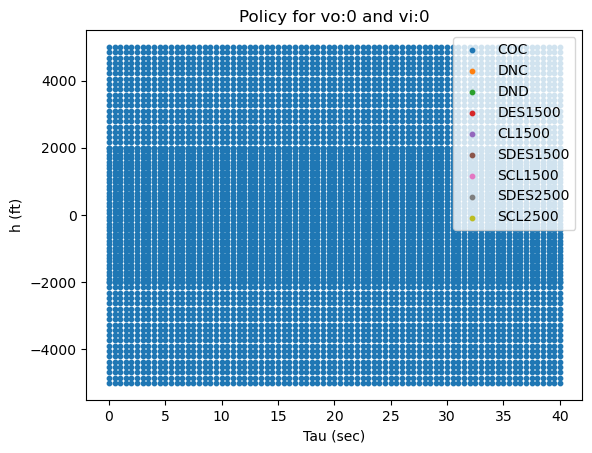

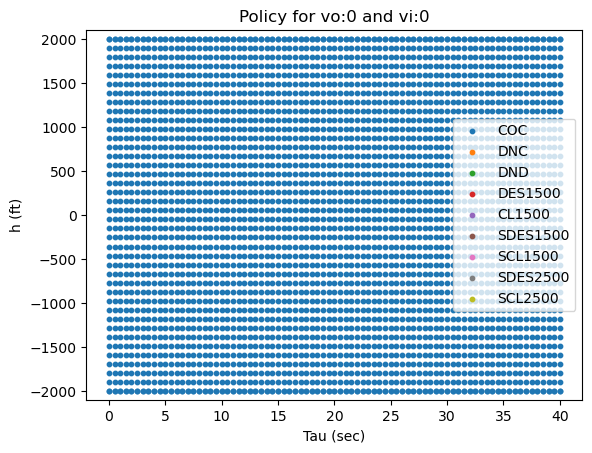

1/1 [==============================] - 0s 12ms/step
['COC', 'COC', 'COC', 'COC', 'COC', 'COC', 'COC', 'COC']
Epoch 1/2
15834/15834 [==============================] - 374s 24ms/step - loss: 0.0060 - accuracy: 0.9804
Epoch 2/2
15834/15834 [==============================] - 376s 24ms/step - loss: 0.0061 - accuracy: 0.9805
[interval([-49795.2269388458, 36393.174507538424]), interval([-108068.51282146732, 36906.526978019254]), interval([-147872.66536933323, 98937.21855857698]), interval([-77087.9267123145, 53978.10147246631]), interval([-162261.9938193998, 114107.90108450418]), interval([-82672.78187296951, 56714.63151102036]), interval([-147808.16306148836, 102543.44295343224]), interval([-69644.63999762938, 34074.33701325668]), interval([-108228.38846158759, 72109.1485970115])]
203/203 [==============================] - 0s 2ms/step


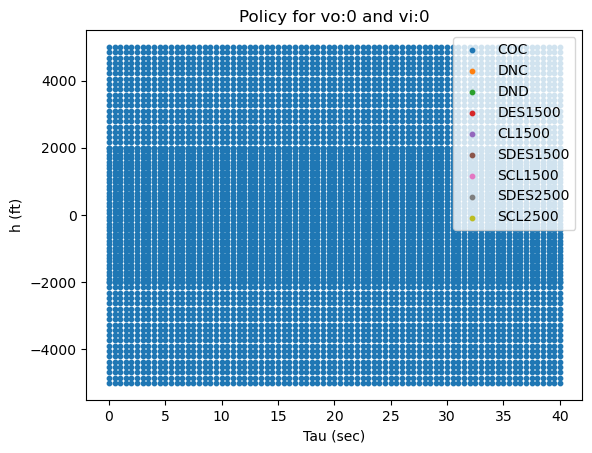

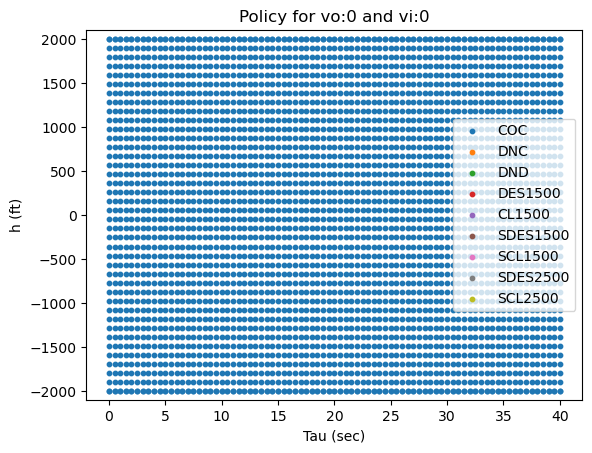

1/1 [==============================] - 0s 12ms/step
['COC', 'COC', 'COC', 'COC', 'COC', 'COC', 'COC', 'COC']


In [126]:
# Define model architecture
model = Sequential()
# model.add(Dense(hu, init='uniform', activation='relu', input_dim=4))
# model.add(Dense(hu, init='uniform', activation='relu'))
# model.add(Dense(hu, init='uniform', activation='relu'))
# model.add(Dense(hu, init='uniform', activation='relu'))
# model.add(Dense(hu, init='uniform', activation='relu'))
# model.add(Dense(hu, init='uniform', activation='relu'))
model.add(Dense(hu, activation="relu", input_dim=4))
model.add(Dense(hu, activation="relu"))
model.add(Dense(hu, activation="relu"))
model.add(Dense(hu, activation="relu"))
model.add(Dense(hu, activation="relu"))
model.add(Dense(hu, activation="relu"))

# model.add(Dense(numOut, init="uniform"))
model.add(Dense(numOut))
opt = Nadam(learning_rate=0.0003)
model.compile(loss=asymMSE, optimizer=opt, metrics=["accuracy"])

# # Train and write nnet files
epoch = saveEvery
while epoch <= totalEpochs:
    model.fit(X_train, Q, epochs=saveEvery, batch_size=2**8, shuffle=True)
    saveFile = nnetFiles % (pra, ver, epoch)
    saveNNet(model, saveFile, means, ranges, min_inputs, max_inputs)
    epoch += saveEvery
    output_interval, penultimate_interval = propagate_interval(
        [
            interval[400, 500],
            interval[50, 51],
            interval[-51, -50],
            interval[20, 21],
        ],
        model,
        graph=False,
    )
    print(output_interval)
    plot_policy(model, f"images/standard_vcas_policy_viz_vo{vo}_vi{vi}_epoch{epoch}.pdf", zoom=True, vo=vo, vi=vi)
    
    # Print out some advisories at a few sample points
    advisory_indices = np.argmax(
        model.predict(
            np.array(
                [
                    [200, 0, 0, 12],
                    [0, 0, 0, 10],
                    [-200, 0, 0, 20],
                    [-400, 0, 0, 2],
                    [400, 0, 0, 2],
                    [400, 0, 0, 4],
                    [400, 0, 0, 6],
                    [400, 0, 0, 8],
                ]
            )
        ),
        axis=1,
    )
    print([action_names[idx] for idx in advisory_indices])

# Train for lots of epochs

In [129]:
totalEpochs = 100
saveEvery = 5
vi, vo = 0, 0

Epoch 1/5


2023-07-10 22:48:33.591226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15834/15834 [==============================] - 409s 26ms/step - loss: 0.1547 - accuracy: 0.9270
Epoch 2/5
15834/15834 [==============================] - 388s 24ms/step - loss: 0.0457 - accuracy: 0.9557
Epoch 3/5
15834/15834 [==============================] - 390s 25ms/step - loss: 0.0326 - accuracy: 0.9616
Epoch 4/5
15834/15834 [==============================] - 397s 25ms/step - loss: 0.0265 - accuracy: 0.9640
Epoch 5/5
 41/203 [=====>........................] - ETA: 0s

2023-07-10 23:21:54.556580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


203/203 [==============================] - 1s 3ms/step


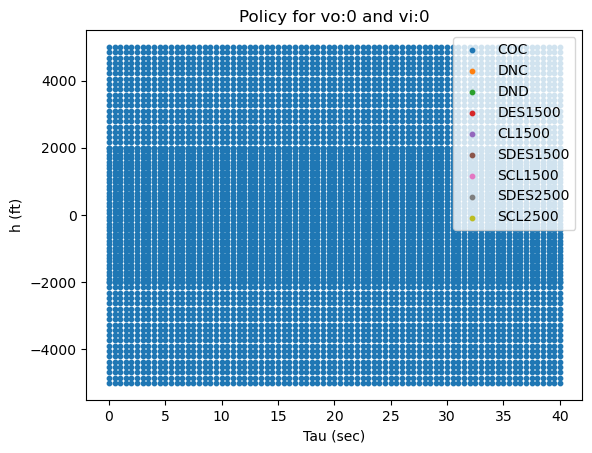

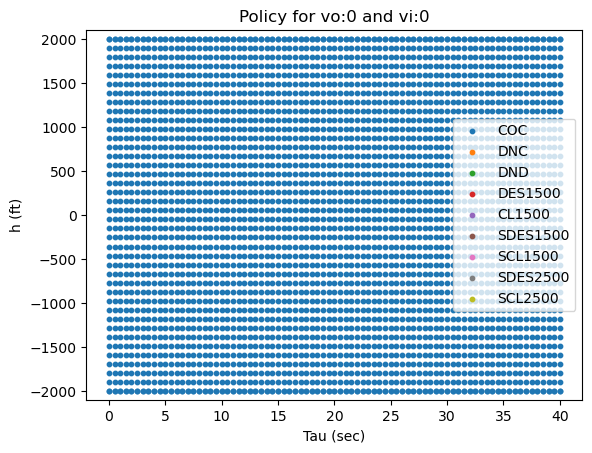

1/1 [==============================] - 0s 99ms/step


2023-07-10 23:21:56.017133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


['COC', 'DND', 'COC', 'COC', 'COC', 'COC', 'COC', 'COC']
Epoch 1/5
15834/15834 [==============================] - 389s 25ms/step - loss: 0.0203 - accuracy: 0.9680
Epoch 2/5
15834/15834 [==============================] - 408s 26ms/step - loss: 0.0188 - accuracy: 0.9690
Epoch 3/5
15834/15834 [==============================] - 416s 26ms/step - loss: 0.0174 - accuracy: 0.9699
Epoch 4/5
15834/15834 [==============================] - 411s 26ms/step - loss: 0.0164 - accuracy: 0.9707
Epoch 5/5
203/203 [==============================] - 1s 2ms/step


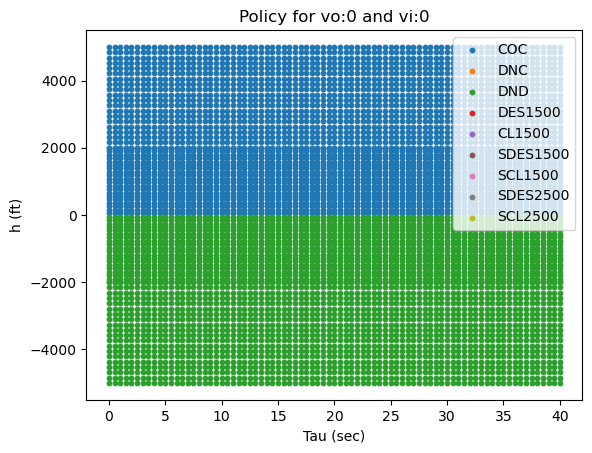

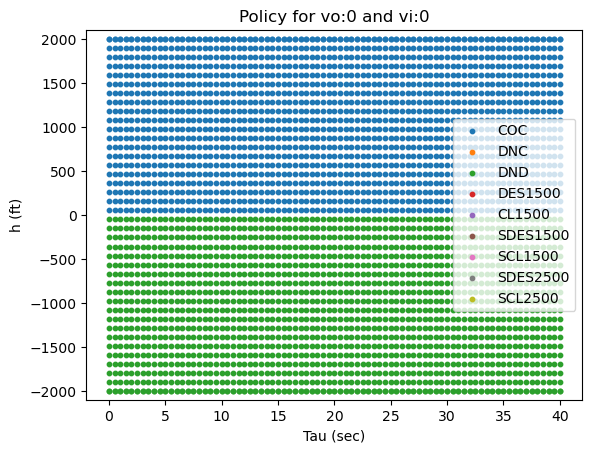

1/1 [==============================] - 0s 13ms/step
['COC', 'COC', 'DND', 'DND', 'COC', 'COC', 'COC', 'COC']
Epoch 1/5
15834/15834 [==============================] - 402s 25ms/step - loss: 0.0147 - accuracy: 0.9717
Epoch 2/5
15834/15834 [==============================] - 403s 25ms/step - loss: 0.0141 - accuracy: 0.9720
Epoch 3/5
15834/15834 [==============================] - 405s 26ms/step - loss: 0.0133 - accuracy: 0.9724
Epoch 4/5
15834/15834 [==============================] - 404s 26ms/step - loss: 0.0128 - accuracy: 0.9728
Epoch 5/5
203/203 [==============================] - 1s 3ms/step


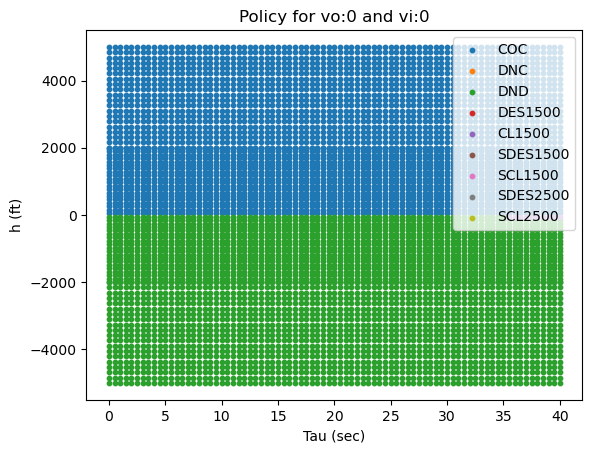

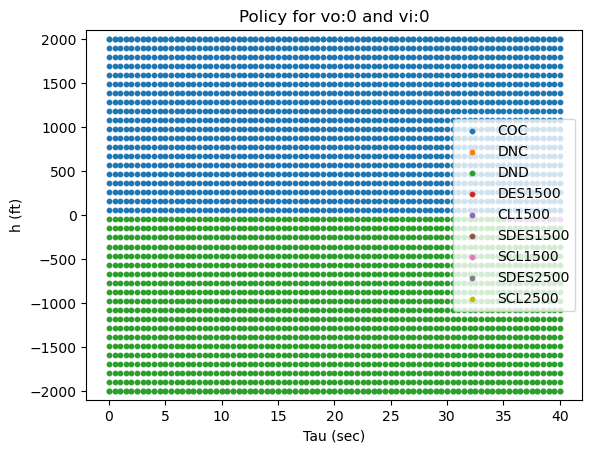

1/1 [==============================] - 0s 19ms/step
['COC', 'COC', 'DND', 'DND', 'COC', 'COC', 'COC', 'COC']
Epoch 1/5
15834/15834 [==============================] - 404s 25ms/step - loss: 0.0119 - accuracy: 0.9736
Epoch 2/5
15834/15834 [==============================] - 405s 26ms/step - loss: 0.0113 - accuracy: 0.9741
Epoch 3/5
15834/15834 [==============================] - 405s 26ms/step - loss: 0.0109 - accuracy: 0.9745
Epoch 4/5
15834/15834 [==============================] - 401s 25ms/step - loss: 0.0107 - accuracy: 0.9745
Epoch 5/5
203/203 [==============================] - 1s 2ms/step


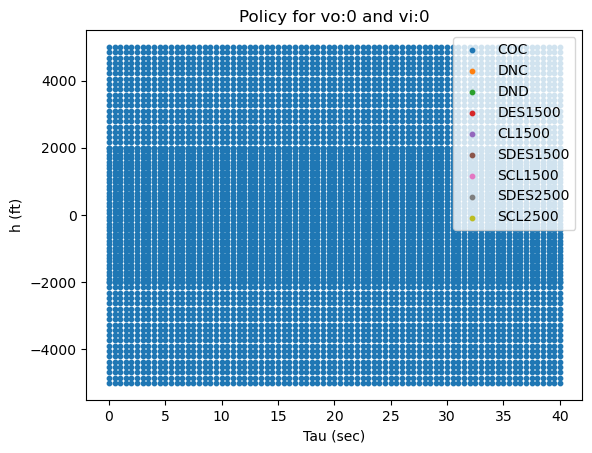

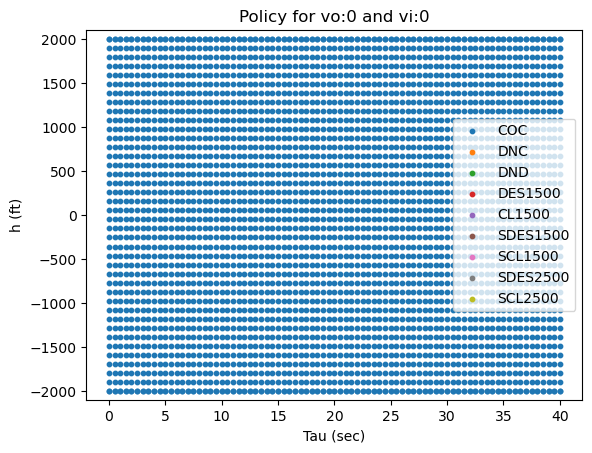

1/1 [==============================] - 0s 11ms/step
['COC', 'COC', 'COC', 'COC', 'COC', 'COC', 'COC', 'COC']
Epoch 1/5
15834/15834 [==============================] - 399s 25ms/step - loss: 0.0098 - accuracy: 0.9753
Epoch 2/5
15834/15834 [==============================] - 403s 25ms/step - loss: 0.0094 - accuracy: 0.9755
Epoch 3/5
15834/15834 [==============================] - 401s 25ms/step - loss: 0.0091 - accuracy: 0.9759
Epoch 4/5
15834/15834 [==============================] - 402s 25ms/step - loss: 0.0089 - accuracy: 0.9762
Epoch 5/5
203/203 [==============================] - 1s 2ms/step


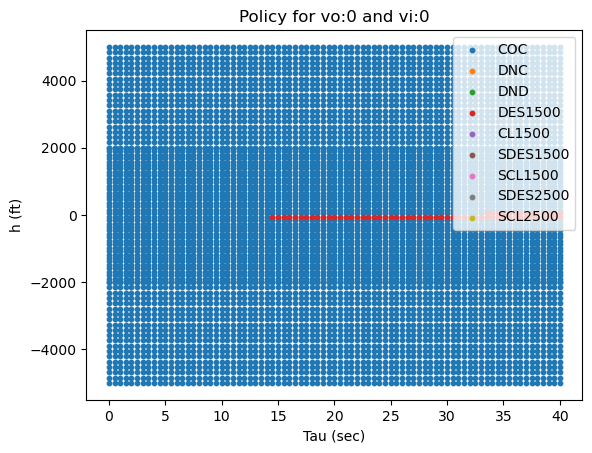

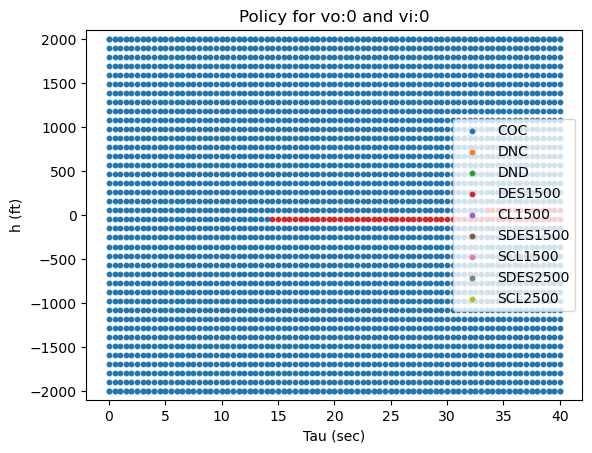

1/1 [==============================] - 0s 20ms/step
['COC', 'COC', 'COC', 'COC', 'COC', 'COC', 'COC', 'COC']
Epoch 1/5
15834/15834 [==============================] - 402s 25ms/step - loss: 0.0083 - accuracy: 0.9767
Epoch 2/5
15834/15834 [==============================] - 401s 25ms/step - loss: 0.0078 - accuracy: 0.9773
Epoch 3/5
15834/15834 [==============================] - 402s 25ms/step - loss: 0.0078 - accuracy: 0.9773
Epoch 4/5
15834/15834 [==============================] - 403s 25ms/step - loss: 0.0075 - accuracy: 0.9777
Epoch 5/5
203/203 [==============================] - 0s 2ms/step


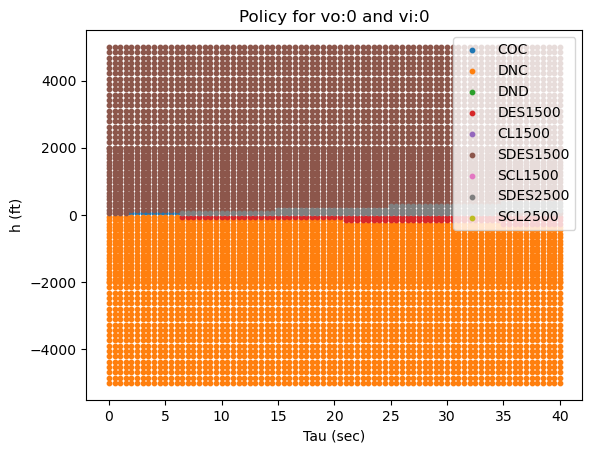

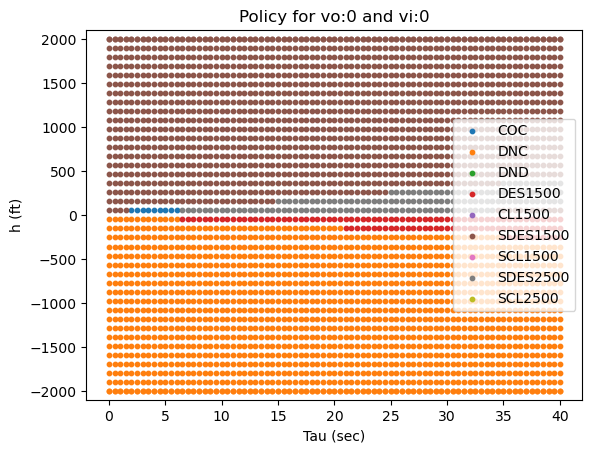

1/1 [==============================] - 0s 14ms/step
['SDES1500', 'COC', 'DNC', 'DNC', 'SDES1500', 'SDES1500', 'SDES1500', 'SDES1500']
Epoch 1/5
15834/15834 [==============================] - 413s 26ms/step - loss: 0.0072 - accuracy: 0.9780
Epoch 2/5
15834/15834 [==============================] - 403s 25ms/step - loss: 0.0069 - accuracy: 0.9782
Epoch 3/5
15834/15834 [==============================] - 405s 26ms/step - loss: 0.0067 - accuracy: 0.9785
Epoch 4/5
15834/15834 [==============================] - 397s 25ms/step - loss: 0.0066 - accuracy: 0.9785
Epoch 5/5
203/203 [==============================] - 1s 2ms/step


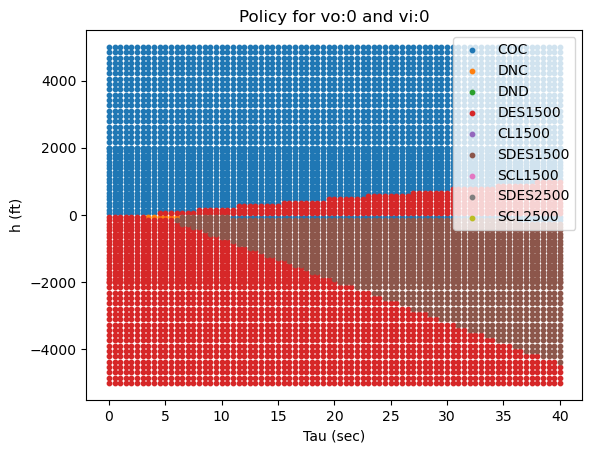

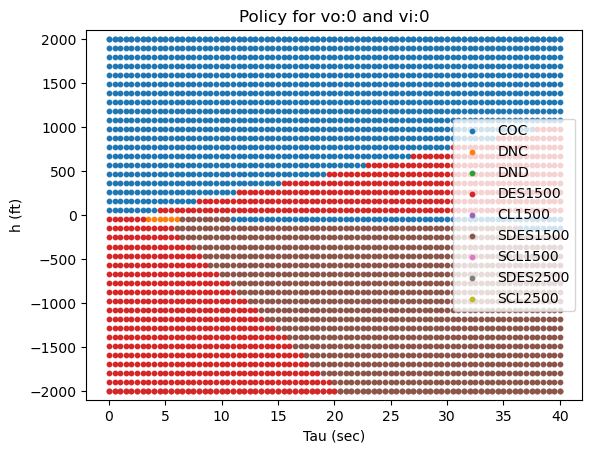

1/1 [==============================] - 0s 12ms/step
['DES1500', 'COC', 'SDES1500', 'DES1500', 'COC', 'COC', 'COC', 'COC']
Epoch 1/5
15834/15834 [==============================] - 399s 25ms/step - loss: 0.0065 - accuracy: 0.9789
Epoch 2/5
15834/15834 [==============================] - 399s 25ms/step - loss: 0.0061 - accuracy: 0.9792
Epoch 3/5
15834/15834 [==============================] - 400s 25ms/step - loss: 0.0061 - accuracy: 0.9793
Epoch 4/5
15834/15834 [==============================] - 402s 25ms/step - loss: 0.0061 - accuracy: 0.9792
Epoch 5/5
203/203 [==============================] - 1s 2ms/step


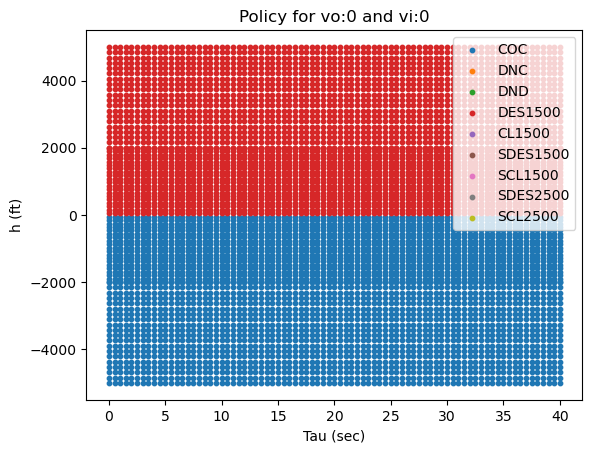

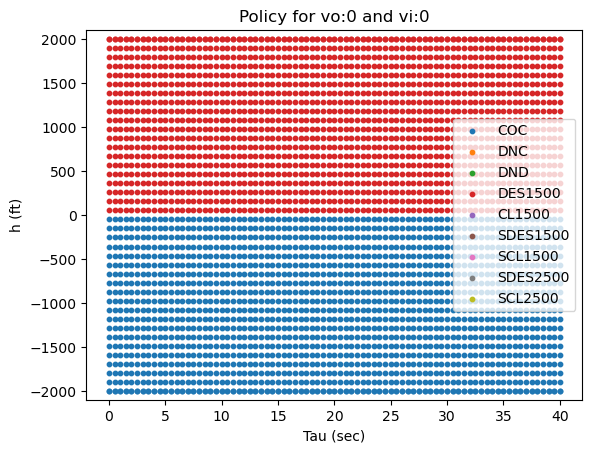

1/1 [==============================] - 0s 11ms/step
['DES1500', 'COC', 'COC', 'COC', 'DES1500', 'DES1500', 'DES1500', 'DES1500']
Epoch 1/5
15834/15834 [==============================] - 402s 25ms/step - loss: 0.0060 - accuracy: 0.9794
Epoch 2/5
15834/15834 [==============================] - 402s 25ms/step - loss: 0.0058 - accuracy: 0.9796
Epoch 3/5
15834/15834 [==============================] - 403s 25ms/step - loss: 0.0058 - accuracy: 0.9797
Epoch 4/5
15834/15834 [==============================] - 403s 25ms/step - loss: 0.0056 - accuracy: 0.9799
Epoch 5/5
203/203 [==============================] - 1s 3ms/step


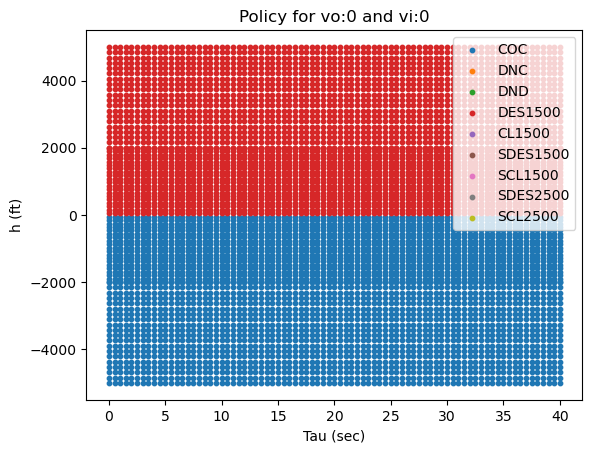

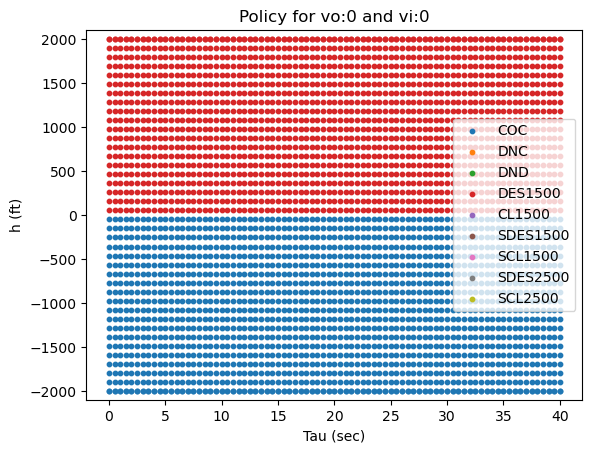

1/1 [==============================] - 0s 20ms/step
['DES1500', 'COC', 'COC', 'COC', 'DES1500', 'DES1500', 'DES1500', 'DES1500']
Epoch 1/5
15834/15834 [==============================] - 405s 26ms/step - loss: 0.0056 - accuracy: 0.9801
Epoch 2/5
15834/15834 [==============================] - 407s 26ms/step - loss: 0.0054 - accuracy: 0.9803
Epoch 3/5
15834/15834 [==============================] - 405s 26ms/step - loss: 0.0051 - accuracy: 0.9803
Epoch 4/5
15834/15834 [==============================] - 403s 25ms/step - loss: 0.0051 - accuracy: 0.9805
Epoch 5/5
203/203 [==============================] - 1s 2ms/step


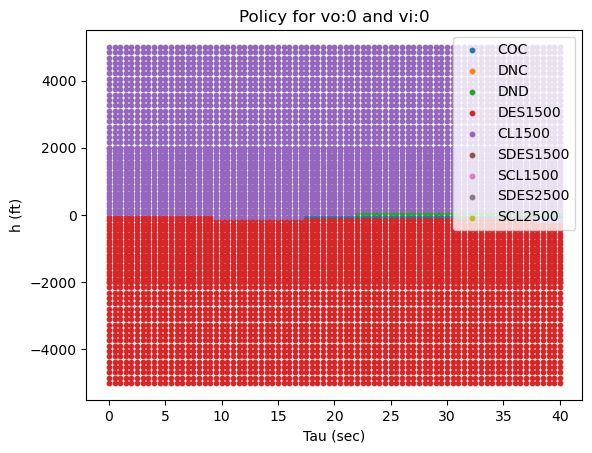

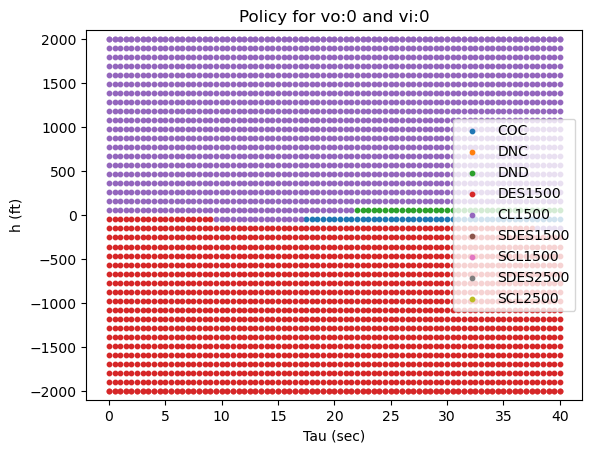

1/1 [==============================] - 0s 12ms/step
['CL1500', 'COC', 'DES1500', 'DES1500', 'CL1500', 'CL1500', 'CL1500', 'CL1500']
Epoch 1/5
15834/15834 [==============================] - 400s 25ms/step - loss: 0.0050 - accuracy: 0.9806
Epoch 2/5
15834/15834 [==============================] - 400s 25ms/step - loss: 0.0049 - accuracy: 0.9807
Epoch 3/5
15834/15834 [==============================] - 400s 25ms/step - loss: 0.0050 - accuracy: 0.9809
Epoch 4/5
15834/15834 [==============================] - 401s 25ms/step - loss: 0.0051 - accuracy: 0.9808
Epoch 5/5
203/203 [==============================] - 1s 2ms/step


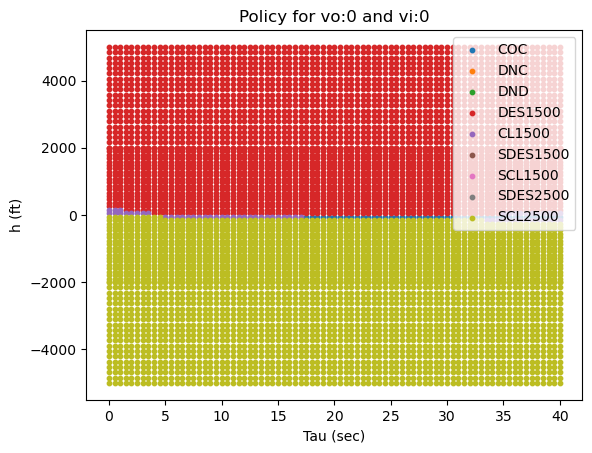

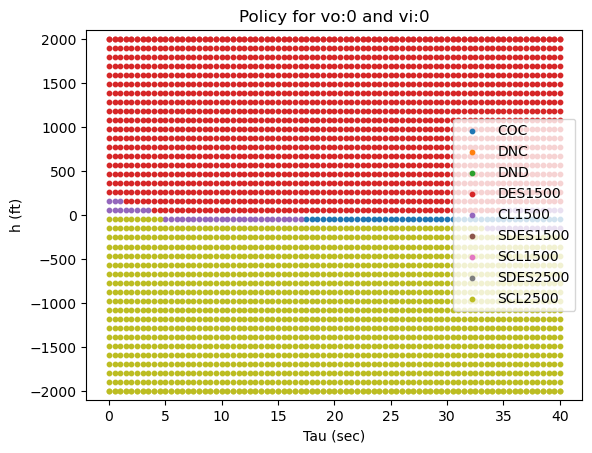

1/1 [==============================] - 0s 12ms/step
['DES1500', 'DND', 'SCL2500', 'SCL2500', 'DES1500', 'DES1500', 'DES1500', 'DES1500']
Epoch 1/5
15834/15834 [==============================] - 404s 25ms/step - loss: 0.0048 - accuracy: 0.9809
Epoch 2/5
15834/15834 [==============================] - 405s 26ms/step - loss: 0.0048 - accuracy: 0.9811
Epoch 3/5
15834/15834 [==============================] - 398s 25ms/step - loss: 0.0051 - accuracy: 0.9811
Epoch 4/5
15834/15834 [==============================] - 385s 24ms/step - loss: 0.0049 - accuracy: 0.9812
Epoch 5/5
203/203 [==============================] - 1s 3ms/step


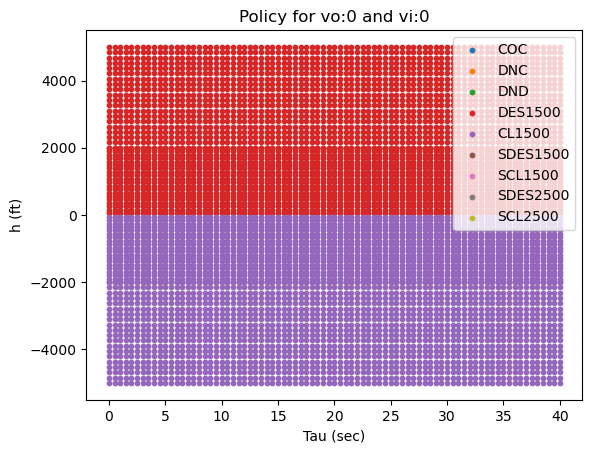

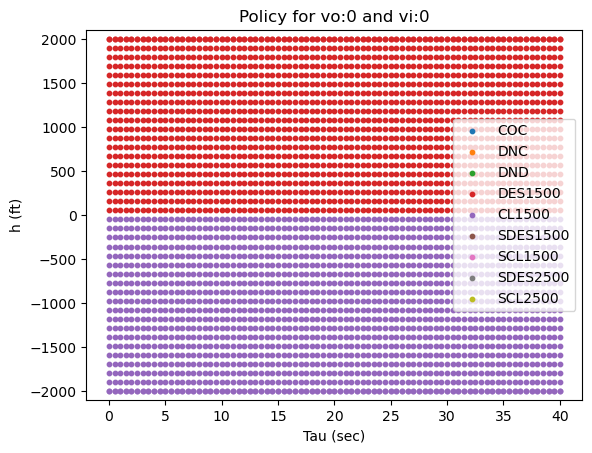

1/1 [==============================] - 0s 18ms/step
['DES1500', 'DND', 'CL1500', 'CL1500', 'DES1500', 'DES1500', 'DES1500', 'DES1500']
Epoch 1/5
15834/15834 [==============================] - 390s 25ms/step - loss: 0.0049 - accuracy: 0.9814
Epoch 2/5
15834/15834 [==============================] - 390s 25ms/step - loss: 0.0048 - accuracy: 0.9815
Epoch 3/5
15834/15834 [==============================] - 384s 24ms/step - loss: 0.0050 - accuracy: 0.9815
Epoch 4/5
15834/15834 [==============================] - 383s 24ms/step - loss: 0.0048 - accuracy: 0.9817
Epoch 5/5
203/203 [==============================] - 0s 2ms/step


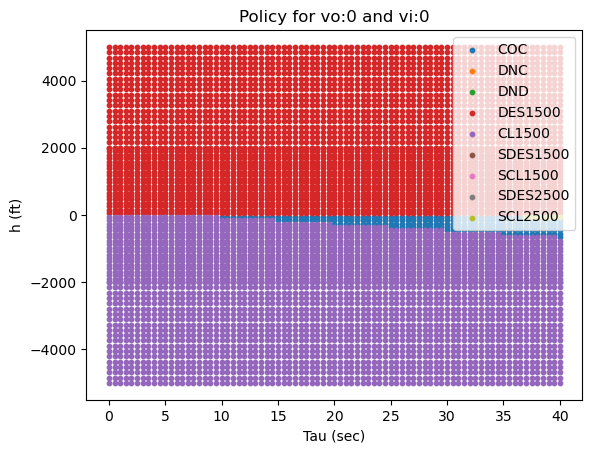

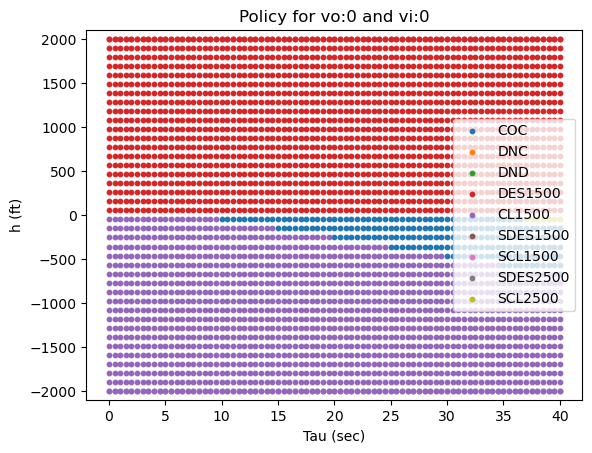

1/1 [==============================] - 0s 11ms/step
['DES1500', 'DND', 'COC', 'CL1500', 'DES1500', 'DES1500', 'DES1500', 'DES1500']
Epoch 1/5
15834/15834 [==============================] - 382s 24ms/step - loss: 0.0046 - accuracy: 0.9820
Epoch 2/5
15834/15834 [==============================] - 385s 24ms/step - loss: 0.0046 - accuracy: 0.9820
Epoch 3/5
15834/15834 [==============================] - 383s 24ms/step - loss: 0.0047 - accuracy: 0.9818
Epoch 4/5
15834/15834 [==============================] - 384s 24ms/step - loss: 0.0046 - accuracy: 0.9821
Epoch 5/5
203/203 [==============================] - 0s 2ms/step


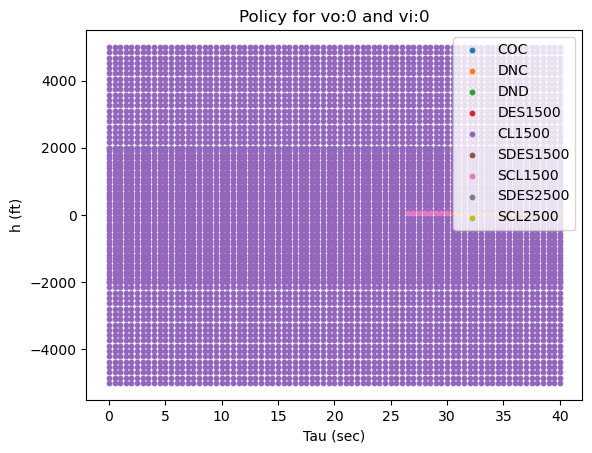

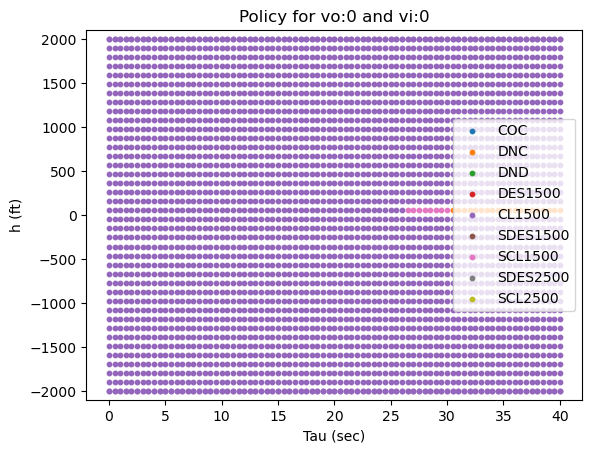

1/1 [==============================] - 0s 15ms/step
['CL1500', 'CL1500', 'CL1500', 'CL1500', 'CL1500', 'CL1500', 'CL1500', 'CL1500']
Epoch 1/5
15834/15834 [==============================] - 384s 24ms/step - loss: 0.0047 - accuracy: 0.9820
Epoch 2/5
15834/15834 [==============================] - 385s 24ms/step - loss: 0.0045 - accuracy: 0.9822
Epoch 3/5
15834/15834 [==============================] - 385s 24ms/step - loss: 0.0044 - accuracy: 0.9822
Epoch 4/5
15834/15834 [==============================] - 385s 24ms/step - loss: 0.0043 - accuracy: 0.9823
Epoch 5/5
203/203 [==============================] - 0s 2ms/step


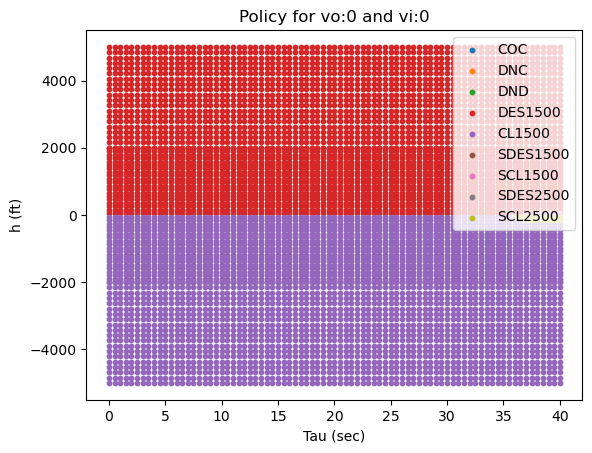

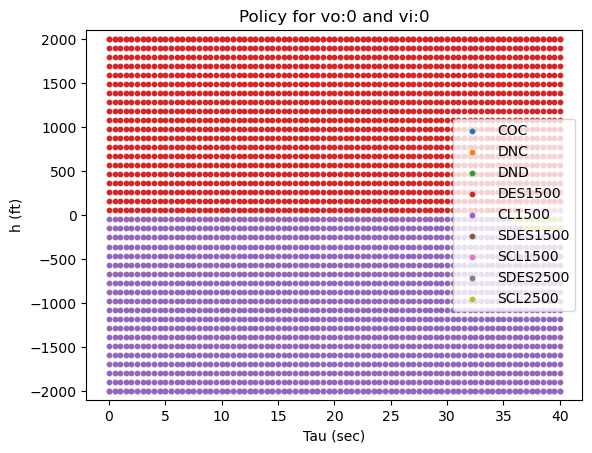

1/1 [==============================] - 0s 18ms/step
['DES1500', 'COC', 'CL1500', 'CL1500', 'DES1500', 'DES1500', 'DES1500', 'DES1500']
Epoch 1/5
15834/15834 [==============================] - 386s 24ms/step - loss: 0.0044 - accuracy: 0.9824
Epoch 2/5
15834/15834 [==============================] - 385s 24ms/step - loss: 0.0046 - accuracy: 0.9823
Epoch 3/5
15834/15834 [==============================] - 379s 24ms/step - loss: 0.0044 - accuracy: 0.9825
Epoch 4/5
15834/15834 [==============================] - 380s 24ms/step - loss: 0.0044 - accuracy: 0.9825
Epoch 5/5
203/203 [==============================] - 0s 2ms/step


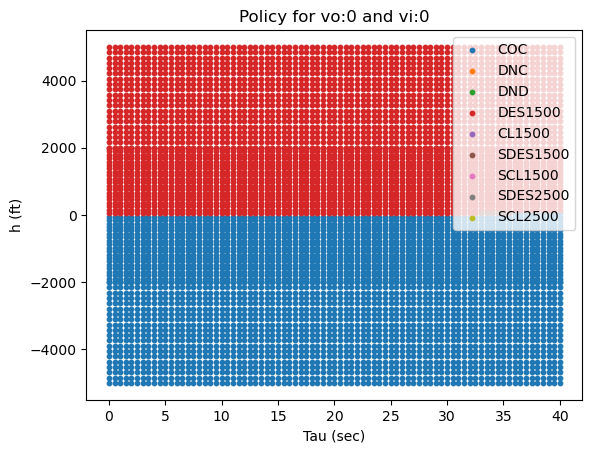

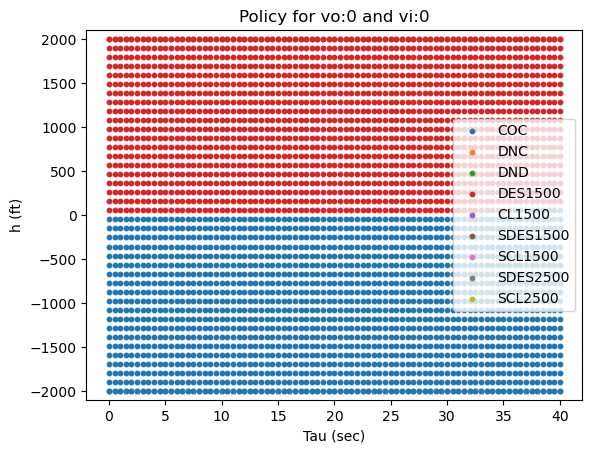

1/1 [==============================] - 0s 12ms/step
['DES1500', 'DND', 'COC', 'COC', 'DES1500', 'DES1500', 'DES1500', 'DES1500']
Epoch 1/5
15834/15834 [==============================] - 380s 24ms/step - loss: 0.0045 - accuracy: 0.9824
Epoch 2/5
15834/15834 [==============================] - 381s 24ms/step - loss: 0.0043 - accuracy: 0.9824
Epoch 3/5
15834/15834 [==============================] - 382s 24ms/step - loss: 0.0042 - accuracy: 0.9826
Epoch 4/5
15834/15834 [==============================] - 382s 24ms/step - loss: 0.0044 - accuracy: 0.9825
Epoch 5/5
203/203 [==============================] - 0s 2ms/step


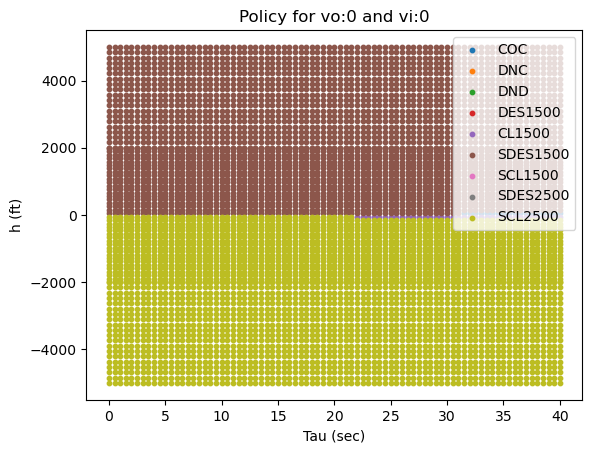

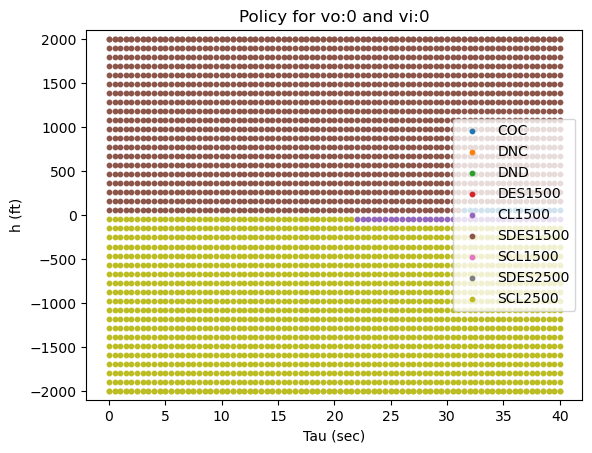

1/1 [==============================] - 0s 12ms/step
['SDES1500', 'DND', 'SCL2500', 'SCL2500', 'SDES1500', 'SDES1500', 'SDES1500', 'SDES1500']
Epoch 1/5
15834/15834 [==============================] - 386s 24ms/step - loss: 0.0044 - accuracy: 0.9827
Epoch 2/5
15834/15834 [==============================] - 383s 24ms/step - loss: 0.0043 - accuracy: 0.9826
Epoch 3/5
15834/15834 [==============================] - 384s 24ms/step - loss: 0.0043 - accuracy: 0.9825
Epoch 4/5
15834/15834 [==============================] - 395s 25ms/step - loss: 0.0043 - accuracy: 0.9827
Epoch 5/5
203/203 [==============================] - 0s 2ms/step


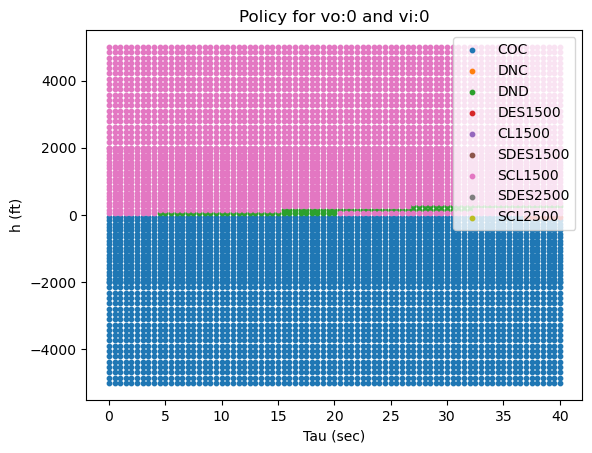

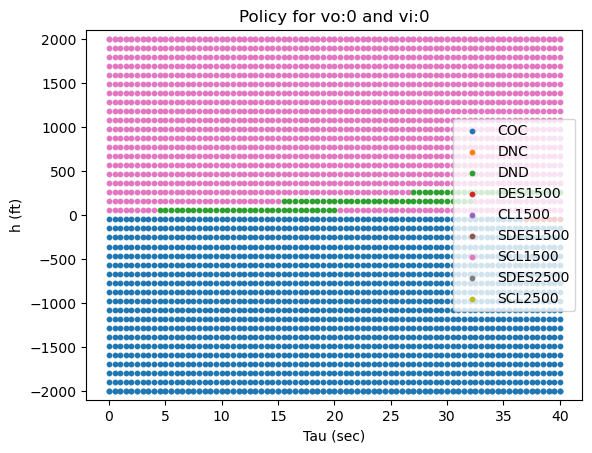

1/1 [==============================] - 0s 13ms/step
['SCL1500', 'DND', 'COC', 'COC', 'SCL1500', 'SCL1500', 'SCL1500', 'SCL1500']
Epoch 1/5
15834/15834 [==============================] - 386s 24ms/step - loss: 0.0042 - accuracy: 0.9826
Epoch 2/5
15834/15834 [==============================] - 382s 24ms/step - loss: 0.0043 - accuracy: 0.9825
Epoch 3/5
15834/15834 [==============================] - 380s 24ms/step - loss: 0.0043 - accuracy: 0.9826
Epoch 4/5
15834/15834 [==============================] - 379s 24ms/step - loss: 0.0042 - accuracy: 0.9827
Epoch 5/5
203/203 [==============================] - 0s 2ms/step


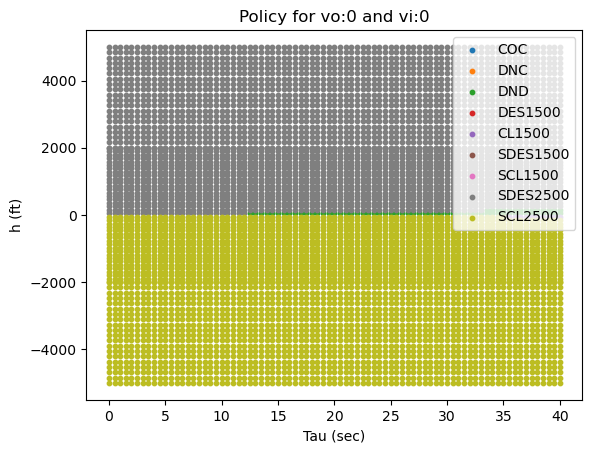

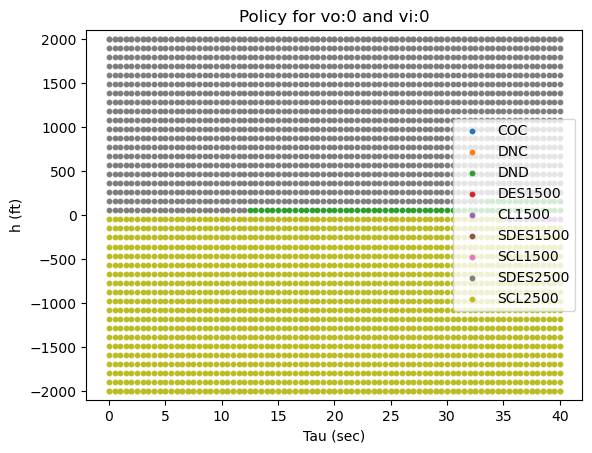

1/1 [==============================] - 0s 11ms/step
['SDES2500', 'DES1500', 'SCL2500', 'SCL2500', 'SDES2500', 'SDES2500', 'SDES2500', 'SDES2500']
Epoch 1/5
15834/15834 [==============================] - 381s 24ms/step - loss: 0.0042 - accuracy: 0.9826
Epoch 2/5
15834/15834 [==============================] - 382s 24ms/step - loss: 0.0044 - accuracy: 0.9826
Epoch 3/5
15834/15834 [==============================] - 382s 24ms/step - loss: 0.0042 - accuracy: 0.9825
Epoch 4/5
15834/15834 [==============================] - 382s 24ms/step - loss: 0.0044 - accuracy: 0.9826
Epoch 5/5
203/203 [==============================] - 0s 2ms/step


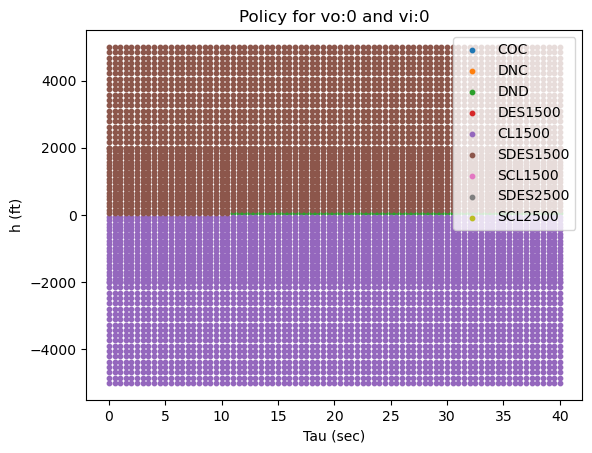

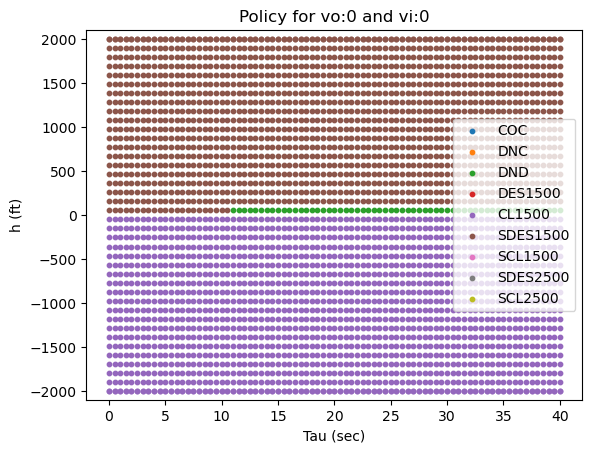

1/1 [==============================] - 0s 10ms/step
['SDES1500', 'DES1500', 'CL1500', 'CL1500', 'SDES1500', 'SDES1500', 'SDES1500', 'SDES1500']


In [130]:
# Define model architecture
model = Sequential()
# model.add(Dense(hu, init='uniform', activation='relu', input_dim=4))
# model.add(Dense(hu, init='uniform', activation='relu'))
# model.add(Dense(hu, init='uniform', activation='relu'))
# model.add(Dense(hu, init='uniform', activation='relu'))
# model.add(Dense(hu, init='uniform', activation='relu'))
# model.add(Dense(hu, init='uniform', activation='relu'))
model.add(Dense(hu, activation="relu", input_dim=4))
model.add(Dense(hu, activation="relu"))
model.add(Dense(hu, activation="relu"))
model.add(Dense(hu, activation="relu"))
model.add(Dense(hu, activation="relu"))
model.add(Dense(hu, activation="relu"))

# model.add(Dense(numOut, init="uniform"))
model.add(Dense(numOut))
opt = Nadam(learning_rate=0.0003)
model.compile(loss=asymMSE, optimizer=opt, metrics=["accuracy"])

# # Train and write nnet files
epoch = saveEvery
while epoch <= totalEpochs:
    model.fit(X_train, Q, epochs=saveEvery, batch_size=2**8, shuffle=True)
    # saveFile = nnetFiles % (pra, ver, epoch)
    # saveNNet(model, saveFile, means, ranges, min_inputs, max_inputs)
    epoch += saveEvery
    # output_interval, penultimate_interval = propagate_interval(
    #     [
    #         interval[400, 500],
    #         interval[50, 51],
    #         interval[-51, -50],
    #         interval[20, 21],
    #     ],
    #     model,
    #     graph=False,
    # )
    # print(output_interval)
    plot_policy(model, f"images/standard_vcas_policy_viz_vo{vo}_vi{vi}_epoch{epoch}.pdf", zoom=True, vo=vo, vi=vi)
    
    # Print out some advisories at a few sample points
    advisory_indices = np.argmax(
        model.predict(
            np.array(
                [
                    [200, 0, 0, 12],
                    [0, 0, 0, 10],
                    [-200, 0, 0, 20],
                    [-400, 0, 0, 2],
                    [400, 0, 0, 2],
                    [400, 0, 0, 4],
                    [400, 0, 0, 6],
                    [400, 0, 0, 8],
                ]
            )
        ),
        axis=1,
    )
    print([action_names[idx] for idx in advisory_indices])

In [131]:
def normalize_point(x: np.array):
    if type(x) is list:
        x = np.array(x)
    mean = np.array([0., 0., 0., 20.])
    ranges = np.array([16000.,   200.,   200.,    40.])
    return (x - mean) / ranges

def denormalize_point(p: np.array):
    if type(p) is list:
        p = np.array(p)
    mean = np.array([0., 0., 0., 20.])
    ranges = np.array([16000.,   200.,   200.,    40.])
    return p * ranges + mean

In [137]:
sample_points = np.array(
            [
                [200, 0, 0, 12],
                [0, 0, 0, 10],
                [-200, 0, 0, 20],
                [-400, 0, 0, 2],
                [400, 0, 0, 2],
                [400, 0, 0, 4],
                [400, 0, 0, 6],
                [400, 0, 0, 8],
            ]
        )

normalized_points = normalize_point(sample_points)
normalized_points

array([[ 0.0125,  0.    ,  0.    , -0.2   ],
       [ 0.    ,  0.    ,  0.    , -0.25  ],
       [-0.0125,  0.    ,  0.    ,  0.    ],
       [-0.025 ,  0.    ,  0.    , -0.45  ],
       [ 0.025 ,  0.    ,  0.    , -0.45  ],
       [ 0.025 ,  0.    ,  0.    , -0.4   ],
       [ 0.025 ,  0.    ,  0.    , -0.35  ],
       [ 0.025 ,  0.    ,  0.    , -0.3   ]])

203/203 [==============================] - 0s 2ms/step


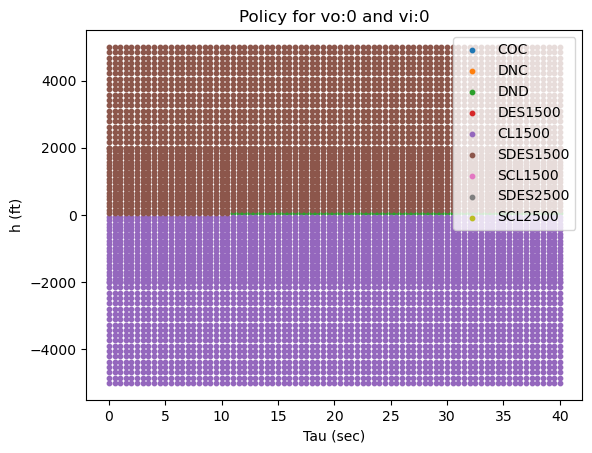

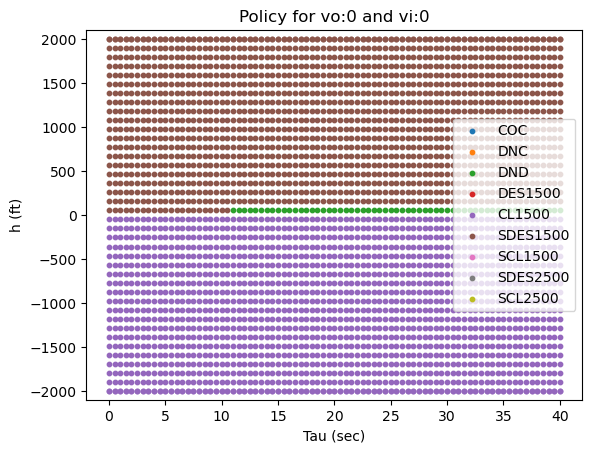

1/1 [==============================] - 0s 14ms/step
['DES1500', 'DES1500', 'CL1500', 'COC', 'COC', 'COC', 'COC', 'COC']


In [141]:
plot_policy(model, f"images/normalized_standard_vcas_policy_viz_vo{vo}_vi{vi}_epoch{epoch}.pdf", zoom=True, vo=vo, vi=vi)

# Print out some advisories at a few sample points
advisory_indices = np.argmax(
    model.predict(
        normalized_points
    ),
    axis=1,
)
print([action_names[idx] for idx in advisory_indices])

# Querying standard model for estimates of loss values

In [11]:
COC_INTERVAL = [
    interval[400, 500],
    interval[50, 51],
    interval[-51, -50],
    interval[20, 21],
]
action_names = [
    "COC",
    "DNC",
    "DND",
    "DES1500",
    "CL1500",
    "SDES1500",
    "SCL1500",
    "SDES2500",
    "SCL2500",
]

In [36]:
np.meshgrid(*[np.arange(400, 510, 25), np.arange(50, 51.1, 0.25), np.arange(-51, -49.9, 0.25)[::-1], np.arange(20, 21.1, 0.25)]).T

AttributeError: 'list' object has no attribute 'T'

In [18]:
x_pred = np.vstack([np.arange(400, 510, 25), np.arange(50, 51.1, 0.25), np.arange(-51, -49.9, 0.25)[::-1], np.arange(20, 21.1, 0.25)]).T
x_pred

array([[400.  ,  50.  , -50.  ,  20.  ],
       [425.  ,  50.25, -50.25,  20.25],
       [450.  ,  50.5 , -50.5 ,  20.5 ],
       [475.  ,  50.75, -50.75,  20.75],
       [500.  ,  51.  , -51.  ,  21.  ]])

In [37]:
y_pred = model.predict(x_pred)
y_pred

1/1 [==============================] - 0s 59ms/step


2023-07-06 16:54:58.319197: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


array([[   2.1117406,  -25.305393 , -105.46683  ,   23.38856  ,
         -49.87453  ,    7.3431063,  -59.64245  ,    3.7353091,
        -125.51994  ],
       [   2.0379605,  -26.951893 , -112.79345  ,   24.86896  ,
         -53.393635 ,    7.789525 ,  -63.536037 ,    3.7780623,
        -133.70781  ],
       [   1.9820409,  -28.641804 , -120.36947  ,   26.239069 ,
         -56.988605 ,    8.124721 ,  -67.56136  ,    3.6754508,
        -141.94951  ],
       [   1.9261479,  -30.331684 , -127.945435 ,   27.609188 ,
         -60.583523 ,    8.459882 ,  -71.58665  ,    3.5728612,
        -150.19115  ],
       [   1.870255 ,  -32.021557 , -135.52133  ,   28.979275 ,
         -64.17842  ,    8.795096 ,  -75.61192  ,    3.4702716,
        -158.4327   ]], dtype=float32)

In [38]:
advisory_idxs = np.argmax(y_pred, axis=1)

In [39]:
[action_names[idx] for idx in advisory_idxs]

['DES1500', 'DES1500', 'DES1500', 'DES1500', 'DES1500']

In [40]:
y_pred = model.predict(np.array([[400, 50, -50, 20]]))
action_names[np.argmax(y_pred)]

1/1 [==============================] - 0s 68ms/step


2023-07-06 16:55:04.428564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


'DES1500'

(80,)

# Plotting Policy

203/203 [==============================] - 1s 2ms/step


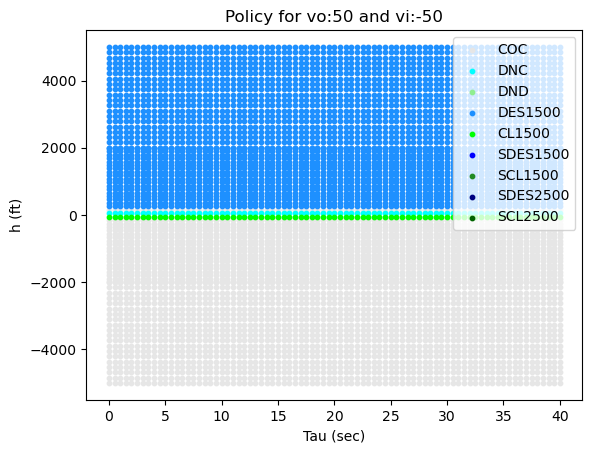

In [85]:
plot_policy(model)

In [83]:
action_names

['COC',
 'DNC',
 'DND',
 'DES1500',
 'CL1500',
 'SDES1500',
 'SCL1500',
 'SDES2500',
 'SCL2500']

In [78]:
hs = np.hstack([np.linspace(-5000, -2000, 20), np.linspace(-2000, 2000, 40), np.linspace(2000, 5000, 20)])
hs.shape

vo = 50
vi = -50
x_grid = None
taus = np.linspace(0, 40, 81)
for tau in taus:
    grid_component = np.vstack([hs, np.ones(hs.shape)*vo, np.ones(hs.shape) * vi, np.ones(hs.shape)*tau]).T
    if x_grid is not None:
        x_grid = np.vstack([x_grid, grid_component])
    else:
        x_grid = grid_component
    
x_grid.shape

(6480, 4)

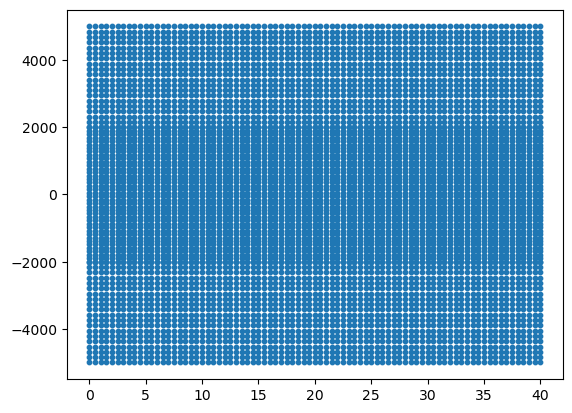

In [79]:
plt.scatter(x_grid[:, 3], x_grid[:, 0], s=10)

In [80]:
y_pred = model.predict(x_grid)
advisory_idxs = np.argmax(y_pred, axis=1)
commands = [action_names[idx] for idx in advisory_idxs]

ra1 = (0.9,0.9,0.9) # white
ra2 = (.0,1.0,1.0) # cyan
ra3 = (144.0/255.0,238.0/255.0,144.0/255.0) # lightgreen
ra4 = (30.0/255.0,144.0/255.0,1.0) # dodgerblue
ra5 = (0.0,1.0,.0) # lime
ra6 = (0.0,0.0,1.0) # blue
ra7 = (34.0/255.0,139.0/255.0,34.0/255.0) # forestgreen
ra8 = (0.0,0.0,128.0/255.0) # navy
ra9 = (0.0,100.0/255.0,0.0) # darkgreen
colors = [ra1,ra2,ra3,ra4,ra5,ra6,ra7,ra8,ra9]
bg_colors = [(1.0,1.0,1.0)]

203/203 [==============================] - 1s 2ms/step


In [81]:
# dict indexed by color/advisory of all points
xs = {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}
ys = {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}

for i, advisory_idx in enumerate(advisory_idxs):
    color = colors[advisory_idx]
    scatter_x = x_grid[i, 3] # tau
    scatter_y = x_grid[i, 0] # h 
    xs[advisory_idx].append(scatter_x)
    ys[advisory_idx].append(scatter_y)
print("done constructing dicts")

done constructing dicts


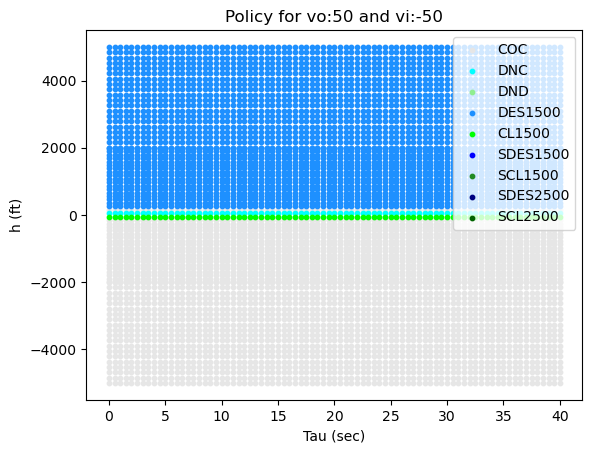

In [82]:
plt.figure()
plt.tight_layout()
for i in range(len(colors)):
    plt.scatter(xs[i], ys[i], s = 10, c = [colors[i]])
plt.legend(action_names)
plt.xlabel("Tau (sec)")
plt.ylabel("h (ft)")
plt.title(f"Policy for vo:{vo} and vi:{vi}")
plt.savefig(f"viz_policy_vo{vo}_vi{vi}.pdf")
plt.show()

# Training: "safe" with projection

In [67]:
np.mean([1, 2, 3.4]).round(3)

2.133

In [63]:
# Redefine model architecture
model = Sequential()
model.add(Dense(hu, activation="relu", input_dim=4))
model.add(Dense(hu, activation="relu"))
model.add(Dense(hu, activation="relu"))
model.add(Dense(hu, activation="relu"))
model.add(Dense(hu, activation="relu"))
model.add(Dense(hu, activation="relu"))

# model.add(Dense(numOut, init="uniform"))
model.add(Dense(numOut))
opt = Nadam(learning_rate=0.0003)

epoch_losses = []
epoch_accuracies = []
weights_before_projection = []
weights_after_projection = []
for epoch in range(totalEpochs):
    print(f"on epoch {epoch}")

    rng = np.random.default_rng()

    train_indices = np.arange(X_train.shape[0])

    rng.shuffle(train_indices)  # in-place

    x_shuffled = X_train[train_indices, :]
    y_shuffled = Q[train_indices, :]

    x_batched = np.split(
        x_shuffled, np.arange(BATCH_SIZE, len(x_shuffled), BATCH_SIZE)
    )
    y_batched = np.split(
        y_shuffled, np.arange(BATCH_SIZE, len(y_shuffled), BATCH_SIZE)
    )

    dataset_batched = list(zip(x_batched, y_batched))
    batch_losses = []
    epoch_accuracy = keras.metrics.CategoricalAccuracy()
    for step, (x_batch_train, y_batch_train) in enumerate(dataset_batched):
        with tf.GradientTape() as tape:
            y_pred = model(x_batch_train, training=True)  # Forward pass
            loss = asymMSE(y_batch_train, y_pred)
            batch_losses.append(loss.numpy())
            epoch_accuracy.update_state(y_batch_train, y_pred)

        if step % int(num_batches / 500) == 0:
            print(
                f"{np.round(step / num_batches * 100, 1)}% through this epoch with loss",
                f"{loss.numpy()} and accuracy {epoch_accuracy.result()}\r",
                end="",
            )

        # Compute gradients
        trainable_vars = model.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        opt.apply_gradients(zip(gradients, trainable_vars))
        
    epoch_accuracies.append(epoch_accuracy.result())
    epoch_losses.append(np.mean(batch_losses))

    print("")
    print(f"Mean loss over this epoch: {np.mean(batch_losses)}")
    print(f"Mean accuracy over this epoch: {epoch_accuracy.result()}")
    
    weights_before_projection.append(model.layers[-1].weights)
    
    # Parameters:
    # - h (ft): Altitude of intruder relative to ownship, [-8000, 8000]
    # - vO (ft/s): ownship vertical climb rate, [-100, 100]
    # - vI (ft/s): intruder vertical climb rate, [-100, 100]
    # - τ (sec): time to loss of horizontal separation
    output_interval, penultimate_interval = propagate_interval(
        [
            interval[7880, 7900],
            interval[95, 96],
            interval[5, 6],
            interval[38, 40],
        ],
        model,
        graph=False,
    )
    
    if not check_intervals(output_interval, desired_interval):
        print(f"safe region test FAILED, interval was {output_interval}")
        if epoch % EPOCH_TO_PROJECT == 0:
            print(f"\nProjecting weights at epoch {epoch}.")
            intervals_to_project = []
            assert type(output_interval) == type(desired_interval)
            if type(output_interval) is list:
                assert len(output_interval) == len(desired_interval)
                for i in range(len(output_interval)):
                    if (
                        desired_interval[i] is not None
                        and output_interval[i] not in desired_interval[i]
                    ):
                        intervals_to_project.append(i)
            else:
                intervals_to_project.append(0)

            weights_tf = model.layers[-1].weights
            weights_np = weights_tf[0].numpy()
            biases_np = weights_tf[1].numpy()

            for idx in intervals_to_project:
                weights_to_project = np.hstack([weights_np[:, idx], biases_np[idx]])
                proj = project_weights(
                    desired_interval[idx], penultimate_interval, weights_to_project
                )
                weights_np[:, idx] = proj[:-1]
                biases_np[idx] = proj[-1]

            model.layers[-1].set_weights([weights_np, biases_np])
            output_interval, _ = propagate_interval(
                COC_INTERVAL,
                model,
                graph=False,
            )
            weights_after_projection.append(model.layers[-1].weights)
            print(f"After projecting, output interval is {output_interval}")
    else:
        print(f"safe region test passed, interval was {output_interval}")
        
    with open("projection_acas.pickle", "wb") as f:
        data = {
            "accuracies": epoch_accuracies,
            "losses": epoch_losses,
            "weights_before_projection": weights_before_projection,
            "weights_after_projection" : weights_after_projection
        }
        pickle.dump()

on epoch 0


KeyboardInterrupt: 

In [53]:
# Redefine model architecture
model = Sequential()
model.add(Dense(hu, activation="relu", input_dim=4))
model.add(Dense(hu, activation="relu"))
model.add(Dense(hu, activation="relu"))
model.add(Dense(hu, activation="relu"))
model.add(Dense(hu, activation="relu"))
model.add(Dense(hu, activation="relu"))

# model.add(Dense(numOut, init="uniform"))
model.add(Dense(numOut))
opt = Nadam(learning_rate=0.0003)

epoch_losses = []
epoch_accuracies = []

rng = np.random.default_rng()

train_indices = np.arange(X_train.shape[0])

rng.shuffle(train_indices)  # in-place

x_shuffled = X_train[train_indices, :]
y_shuffled = Q[train_indices, :]

x_batched = np.split(
    x_shuffled, np.arange(BATCH_SIZE, len(x_shuffled), BATCH_SIZE)
)
y_batched = np.split(
    y_shuffled, np.arange(BATCH_SIZE, len(y_shuffled), BATCH_SIZE)
)

dataset_batched = list(zip(x_batched, y_batched))
batch_losses = []
epoch_accuracy = keras.metrics.CategoricalAccuracy()

In [54]:
x_batch_train, y_batch_train = dataset_batched[0]

In [55]:
x_batch_train

array([[ 0.4375   ,  0.25     , -0.175    ,  0.15     ],
       [ 0.025    ,  0.12     , -0.06     , -0.4      ],
       [ 0.040625 ,  0.25     , -0.075    ,  0.05     ],
       ...,
       [-0.4375   ,  0.015    , -0.5      , -0.475    ],
       [-0.015625 ,  0.045    ,  0.12     , -0.05     ],
       [-0.0015625, -0.045    ,  0.06     , -0.125    ]])

In [56]:
x_batch_train.shape

(256, 4)

In [57]:
y_batch_train

array([[ 0.13927838,  0.13645189, -0.18857282, ..., -0.51120441,
        -0.18661046, -0.51120441],
       [ 0.13571988,  0.13384362, -0.18826263, ..., -0.18824708,
        -0.1888686 , -0.18954008],
       [ 0.13747425,  0.13410574, -0.19035361, ..., -0.5129852 ,
        -0.18921361, -0.5129852 ],
       ...,
       [ 0.13944473,  0.13390045,  0.1371561 , ..., -0.18569146,
        -0.1891341 , -0.18585266],
       [ 0.11733818,  0.11729585,  0.11470255, ..., -0.20474957,
        -0.19969331, -0.20416035],
       [ 0.12247093, -0.20109898,  0.11854088, ..., -0.20117969,
        -0.19518805, -0.20012412]])

In [58]:
y_batch_train.shape

(256, 9)

In [59]:
with tf.GradientTape() as tape:
    y_pred = model(x_batch_train, training=True)  # Forward pass
    loss = asymMSE(y_batch_train, y_pred)
    batch_losses.append(loss.numpy())
    epoch_accuracy.update_state(y_batch_train, y_pred)
    print(epoch_accuracy.result())

tf.Tensor(0.0390625, shape=(), dtype=float32)


In [60]:
y_pred.numpy()

array([[-0.00497785,  0.0056028 , -0.00372787, ...,  0.00801963,
        -0.01277333, -0.0002428 ],
       [ 0.01163118,  0.00183113, -0.01509215, ..., -0.00548706,
        -0.0139334 ,  0.00178872],
       [-0.00148563,  0.00527574, -0.00504732, ...,  0.00068474,
        -0.00919728, -0.002542  ],
       ...,
       [ 0.03237238,  0.00771668, -0.07727925, ..., -0.03789406,
        -0.04581362,  0.0197723 ],
       [ 0.00262024,  0.00610623, -0.00543152, ...,  0.00349135,
        -0.01140925, -0.0003101 ],
       [ 0.00386393,  0.0011455 , -0.00564399, ..., -0.00172006,
        -0.00725277,  0.00049856]], dtype=float32)

In [61]:
y_pred.numpy().shape

(256, 9)

In [62]:
np.argmin(y_pred, axis=1)

array([7, 2, 4, 2, 7, 4, 2, 7, 2, 2, 2, 4, 2, 2, 7, 2, 2, 2, 7, 4, 7, 7,
       2, 2, 2, 7, 2, 4, 5, 7, 2, 2, 7, 7, 7, 4, 2, 4, 2, 4, 7, 7, 2, 4,
       7, 4, 4, 7, 7, 7, 7, 4, 2, 2, 7, 4, 7, 7, 4, 7, 7, 7, 7, 7, 4, 7,
       7, 7, 7, 7, 2, 2, 7, 2, 4, 2, 4, 2, 4, 7, 4, 4, 4, 2, 7, 4, 2, 7,
       4, 7, 7, 4, 2, 7, 4, 2, 2, 4, 7, 2, 2, 2, 4, 7, 7, 4, 2, 4, 2, 4,
       7, 7, 7, 7, 7, 7, 7, 2, 2, 2, 2, 4, 2, 7, 7, 7, 2, 7, 7, 2, 4, 2,
       2, 2, 7, 4, 7, 7, 2, 2, 2, 4, 4, 2, 2, 2, 7, 7, 2, 2, 2, 7, 7, 7,
       4, 4, 2, 4, 2, 7, 7, 4, 7, 2, 7, 7, 2, 7, 7, 2, 7, 4, 2, 2, 7, 7,
       4, 4, 7, 4, 7, 7, 7, 7, 4, 4, 7, 4, 2, 7, 4, 2, 4, 2, 7, 7, 4, 4,
       2, 7, 2, 2, 7, 2, 2, 7, 7, 7, 2, 4, 2, 4, 7, 4, 4, 7, 7, 2, 4, 7,
       7, 7, 4, 2, 2, 4, 7, 7, 2, 2, 7, 7, 2, 4, 7, 2, 7, 4, 7, 2, 7, 7,
       2, 2, 4, 2, 7, 7, 4, 7, 7, 7, 7, 2, 7, 7])

In [43]:
np.argmin(y_batch_train, axis=1)

array([8, 8, 8, 7, 7, 6, 5, 5, 5, 8, 8, 5, 8, 8, 8, 6, 8, 8, 8, 8, 5, 7,
       8, 7, 6, 6, 8, 8, 6, 8, 8, 8, 8, 5, 7, 7, 8, 6, 8, 7, 7, 7, 6, 6,
       1, 8, 7, 7, 8, 6, 8, 5, 6, 7, 8, 6, 7, 8, 7, 5, 8, 8, 7, 8, 5, 7,
       8, 7, 8, 5, 8, 8, 5, 5, 6, 8, 8, 7, 6, 5, 6, 6, 7, 8, 7, 8, 7, 6,
       6, 7, 7, 5, 5, 7, 8, 7, 7, 8, 6, 7, 6, 7, 7, 8, 2, 8, 8, 7, 7, 7,
       8, 7, 8, 8, 6, 8, 8, 6, 5, 5, 8, 1, 5, 5, 6, 8, 6, 8, 1, 7, 8, 8,
       8, 7, 5, 6, 7, 5, 8, 7, 7, 8, 6, 8, 7, 5, 8, 7, 7, 7, 6, 8, 6, 6,
       7, 8, 6, 8, 6, 8, 6, 5, 5, 6, 8, 8, 7, 7, 6, 7, 7, 6, 8, 7, 8, 5,
       1, 6, 7, 8, 6, 5, 7, 8, 8, 8, 5, 8, 7, 6, 8, 5, 5, 1, 7, 5, 7, 5,
       8, 5, 7, 8, 5, 7, 5, 8, 5, 1, 8, 7, 8, 7, 5, 6, 7, 6, 7, 8, 5, 8,
       6, 7, 1, 2, 7, 7, 7, 8, 6, 8, 5, 5, 5, 5, 5, 7, 5, 8, 2, 7, 8, 6,
       7, 5, 8, 5, 8, 8, 7, 7, 5, 7, 8, 7, 7, 8])

In [44]:
np.mean(np.argmin(y_pred, axis=1) == np.argmin(y_batch_train, axis=1))

0.03515625